# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [110]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


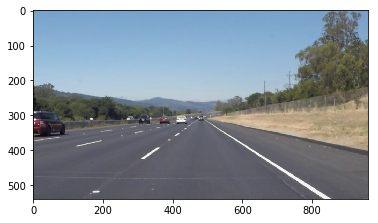

In [111]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [112]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    color_select = np.copy(img)
    # Define color selection criteria
    ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    red_threshold = 205
    green_threshold = 140
    blue_threshold = 50
    ######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    thresholds = (img[:,:,0] < rgb_threshold[0]) \
                | (img[:,:,1] < rgb_threshold[1]) \
                | (img[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    
    return cv2.cvtColor(color_select, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            print(line)
    """
    #print("Start image.")
    ## Plan:
    ## Find the average of each value (y1, y2...)
    ## For each one if the x values are less than the average it is on the left.
    ## Otherwise, it is on the right.
    ## For each one if the y values are less than the average it is on the bottom.
    ## Otherwise, it is on the top.
    ## Find the far left, the far right of each.
    ## 
    s_1 = 0.8
    s_2 = 0.5
    
    long_lines = []
    average_slope = 0
    ##print(type(lines), lines.shape)
    ## Test
    #verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (130, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    imshape = img.shape
    '''(imshape[1] * 0.6, imshape[0] * 0.63),
                             (410, imshape[0] * 0.63),
                             (imshape[1] * 0.1, imshape[0]),
                             (imshape[1] * 0.9, imshape[0])'''
    cv2.line(img, (int(imshape[1] * 0.6), int(imshape[0] * 0.63)), (int(imshape[1] * 0.43), int(imshape[0] * 0.63)), [0, 0, 255], 10)
    cv2.line(img, (int(imshape[1] * 0.43), int(imshape[0] * 0.63)), (int(imshape[1] * 0.1), int(imshape[0])), [0, 0, 255], 10)
    #cv2.line(img, (int(imshape[1] * 0.6), int(imshape[0] * 0.63)), (int(imshape[1] * 0.76), int(imshape[0] * 0.63)), [0, 0, 255], 10)
    cv2.line(img, (int(imshape[1] * 0.6), int(imshape[0] * 0.63)), (int(imshape[1] * 0.96), int(imshape[0])), [0, 0, 255], 10)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            line_len = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
            temp_slope = ((y2-y1)/(x2-x1))
            print(temp_slope)
            if line_len >= 100 and temp_slope < s_1 and temp_slope > s_2 or temp_slope > - s_1 and temp_slope < - s_2:
                
                long_lines.append(np.array([[x1, y1, x2, y2]]))
                temp_slope = ((y2-y1)/(x2-x1))
                average_slope += temp_slope
                cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], thickness)
                
    long_lines = np.array(long_lines)
    print(type(long_lines), long_lines.shape)
    average_slope /= long_lines.shape[0]
    
    ##left_lines = []
    ##right_lines = []
    
    left_average_x = 0
    left_average_y = 0
    right_average_x = 0
    right_average_y = 0
    
    left_average_slope = 0
    right_average_slope = 0
    
    left_total = 0
    right_total = 0
    
    for line in long_lines:
        for x1, y1, x2, y2 in line:
            ##cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            temp_slope = ((y2-y1)/(x2-x1))
            if temp_slope >= average_slope:
                ## On the left side.
                ##left_lines.append(np.array([[x1, y1, x2, y2]]))
                left_average_x += x1 + x2
                left_average_y += y1 + y2
                left_average_slope += ((y2-y1)/(x2-x1))
                left_total += 1
            else:
                ## On the right side.
                ##right_lines.append(np.array([[x1, y1, x2, y2]]))
                right_average_x += x1 + x2
                right_average_y += y1 + y2
                right_average_slope += ((y2-y1)/(x2-x1))
                right_total += 1
        
    try:
        left_average_x /= left_total * 2
        left_average_y /= left_total * 2
        left_average_slope /= left_total
    except:
        left_average_x = 1
        left_average_y = 1
        left_average_slope = 1
        
    try:
        right_average_x /= right_total * 2
        right_average_y /= right_total * 2
        right_average_slope /= right_total
    except:
        right_average_x = 1
        right_average_y = 1
        right_average_slope = 1
    
    ## Calculate the new lines to show.
    top_limit = 360
    bottom_limit = img.shape[0]
    
    ## y = mx + b
    ## b = y - mx
    ## x = (y-b)/m
    try:
        left_b = left_average_y - left_average_slope * left_average_x
        left_top_x = (top_limit - left_b) / left_average_slope
        left_bottom_x = (bottom_limit - left_b) / left_average_slope
    except:
        left_top_x = 1
        left_bottom_x = 1
    
    try:
        right_b = right_average_y - right_average_slope * right_average_x
        right_top_x = (top_limit - right_b) / right_average_slope
        right_bottom_x = (bottom_limit - right_b) / right_average_slope
    except:
        right_top_x = 1
        right_bottom_x = 1

    if np.isnan(left_bottom_x) or np.isnan(left_top_x):
        left_bottom_x = 1
        left_top_x = 1
        
    if np.isnan(right_bottom_x) or np.isnan(right_top_x):
        right_bottom_x = 1
        right_top_x = 1
    
    ##print(left_bottom_x, left_top_x, right_bottom_x, right_top_x)
    ##print(left_bottom_x, bottom_limit, left_top_x, top_limit)
    ##print(right_bottom_x, bottom_limit, right_top_x, top_limit)
    cv2.line(img, (int(left_bottom_x), bottom_limit), (int(left_top_x), top_limit), color, thickness*2)
    cv2.line(img, (int(right_bottom_x), bottom_limit), (int(right_top_x), top_limit), color, thickness*2)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [113]:
import os
os.listdir("test_images/")

['challenge.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

-0.696296296296
-0.861111111111
0.548387096774
-0.726890756303
-0.825910931174
-0.826923076923
-0.828571428571
0.573863636364
-0.7
-0.827338129496
-0.826446280992
0.550802139037
-0.8625
0.577380952381
-0.701754385965
-0.694214876033
0.551351351351
-0.692913385827
-0.794736842105
-0.796875
<class 'numpy.ndarray'> (13, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (653, 1162, 3)
0.579104477612
0.551532033426
0.576023391813
-0.828767123288
0.550218340611
-0.727272727273
-0.824324324324
-0.795454545455
-0.825174825175
-0.72131147541
-0.828125
0.550595238095
<class 'numpy.ndarray'> (8, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
0.60594795539
0.643564356436
0.60663507109
0.555555555556
-0.691358024691
0.608843537415
-0.725806451613
-0.725321888412
0.64
-0.693277310924
-0.690607734807
-0.725806451613
0.636363636364
-0.726457399103
<class 'numpy.ndarray'> (14, 1, 4)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.7311827

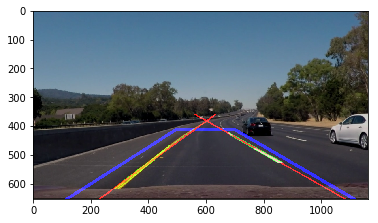

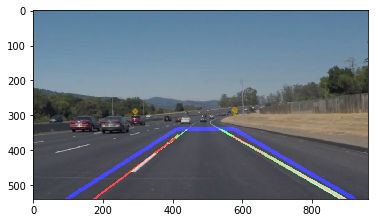

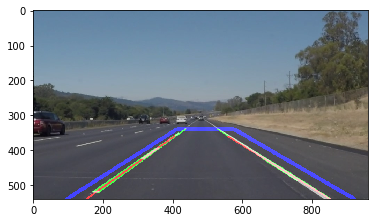

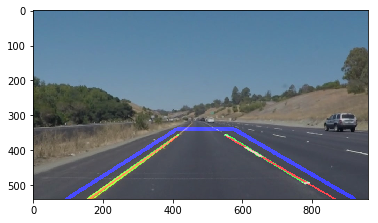

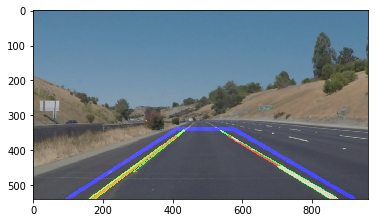

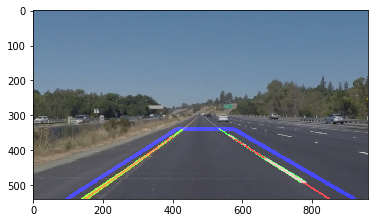

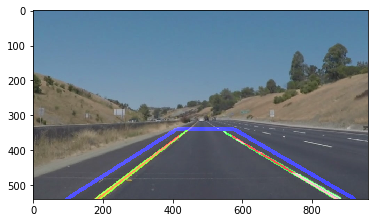

In [114]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def load_image(s):
    return mpimg.imread(s)

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(img)
    
    gaus_kernel = 7
    gaus = gaussian_blur(gray, gaus_kernel)
    
    canny_low = 80
    canny_high = 125
    canny_img = canny(gaus, canny_low, canny_high)
    #plt.figure()
    #plt.imshow(canny_img)
    
    imshape = img.shape
    verticies_1 = np.array([[(imshape[1] * 0.6, imshape[0] * 0.63),
                             (imshape[1] * 0.43, imshape[0] * 0.63),
                             (imshape[1] * 0.1, imshape[0]),
                             (imshape[1] * 0.96, imshape[0])]],
                           dtype=np.int32)
    reg_1 = region_of_interest(canny_img, verticies_1)
    verticies_2 = np.array([[(420,350),(420, 300), (550, 300), (550, 350)]], dtype=np.int32)
    
    rho = 1
    theta = np.pi/150
    threshold = 5
    min_line_length = 100
    max_line_gap = 200
    
    rho_2 = 1
    theta_2 = np.pi/180
    threshold_2 = 10
    min_line_length_2 = 1
    max_line_gap_2 = 20
    
    hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)

    #hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)
    ##hough_2 = hough_lines(reg_2, rho_2, theta_2, threshold_2, min_line_length_2, max_line_gap_2)
    
    
    result = weighted_img(hough_1, img)
    return result
    #return canny_img

def process_images(imgs):
    for img_str in imgs:
        img = load_image('test_images/' + img_str)
        final_image = process_image(img)
        #printing out some stats and plotting
        print('This image is:', type(final_image), 'with dimensions:', final_image.shape)
        plt.figure()
        plt.imshow(final_image)

img_list = os.listdir('test_images/')
process_images(img_list)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [115]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [116]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(img)
    
    gaus_kernel = 5
    gaus = gaussian_blur(gray, gaus_kernel)
    
    canny_low = 80
    canny_high = 120
    canny_img = canny(gaus, canny_low, canny_high)
    #plt.figure()
    #plt.imshow(canny_img)
    
    imshape = img.shape
    verticies_1 = np.array([[(imshape[1] * 0.6, imshape[0] * 0.63),
                             (imshape[1] * 0.43, imshape[0] * 0.63),
                             (imshape[1] * 0.1, imshape[0]),
                             (imshape[1] * 0.96, imshape[0])]],
                           dtype=np.int32)
    reg_1 = region_of_interest(canny_img, verticies_1)
    verticies_2 = np.array([[(420,350),(420, 300), (550, 300), (550, 350)]], dtype=np.int32)
    
    rho = 1
    theta = np.pi/90
    threshold = 10
    min_line_length = 100
    max_line_gap = 250
    
    rho_2 = 1
    theta_2 = np.pi/180
    threshold_2 = 10
    min_line_length_2 = 1
    max_line_gap_2 = 20
    
    hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)

    #hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)
    ##hough_2 = hough_lines(reg_2, rho_2, theta_2, threshold_2, min_line_length_2, max_line_gap_2)
    
    
    result = weighted_img(hough_1, img)
    #backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

    #return cv2.cvtColor(gaus, cv2.COLOR_GRAY2RGB)
    return result
    #return canny_img

Let's try the one with the solid white lane on the right first ...

In [117]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

0.625730994152
0.61875
-0.72380952381
-0.723849372385
0.618055555556
0.627819548872
-0.727272727273
0.626984126984
0.617391304348
-0.675
-0.728033472803
-0.725
<class 'numpy.ndarray'> (12, 1, 4)
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|          | 2/222 [00:00<00:11, 19.37it/s]

0.625730994152
0.61875
-0.72380952381
-0.723849372385
0.618055555556
0.627819548872
-0.727272727273
0.626984126984
0.617391304348
-0.675
-0.728033472803
-0.725
<class 'numpy.ndarray'> (12, 1, 4)
0.626865671642
0.671568627451
-0.730158730159
0.619318181818
-0.779735682819
0.671717171717
0.62091503268
-0.779411764706
-0.78021978022
-0.728
0.675
-0.777777777778
-0.724137931034
0.624203821656
0.673913043478
0.67027027027
0.671428571429
<class 'numpy.ndarray'> (17, 1, 4)
0.627192982456
-0.725806451613
0.620253164557
-0.778894472362
0.617647058824
0.630136986301
-0.72514619883
-0.78125
0.624060150376
-0.726744186047
<class 'numpy.ndarray'> (10, 1, 4)
0.580912863071
0.578616352201
0.580086580087
0.628378378378
0.58407079646
-0.779816513761
0.581632653061
0.581027667984
-0.678571428571
-0.728155339806
-0.72380952381
-0.781094527363
-0.725961538462
0.577319587629
-0.778947368421
0.579545454545
0.627376425856
-0.674157303371
<class 'numpy.ndarray'> (18, 1, 4)
0.625
0.626623376623
0.617391304348


  4%|▎         | 8/222 [00:00<00:09, 21.61it/s]

0.626865671642
0.625
0.618705035971
-0.723880597015
0.619834710744
0.619469026549
-0.724637681159
0.528455284553
-0.727941176471
-0.78125
0.62660944206
<class 'numpy.ndarray'> (11, 1, 4)
0.627177700348
0.626865671642
0.616666666667
0.626016260163
-0.727848101266
-0.722222222222
0.622641509434
-0.728476821192
-0.723270440252
-0.726114649682
<class 'numpy.ndarray'> (10, 1, 4)
0.626582278481
0.618644067797
0.626373626374
0.625407166124
-0.723958333333
-0.724867724868
-0.728205128205
-0.726315789474
-0.727272727273
-0.725352112676
<class 'numpy.ndarray'> (10, 1, 4)
0.62641509434
0.581151832461
0.580508474576
0.579505300353
0.579831932773
-0.728813559322
-0.724279835391
-0.725738396624
0.627118644068
-0.722826086957
0.669724770642
0.530303030303
0.580786026201
-0.727272727273
-0.725738396624
0.625
<class 'numpy.ndarray'> (16, 1, 4)
0.627906976744
0.61875
0.622807017544
0.627450980392
-0.675862068966
0.625592417062
-0.776785714286
-0.78
-0.672
-0.67619047619
0.619718309859
<class 'numpy.ndar

  5%|▍         | 11/222 [00:00<00:09, 22.65it/s]


<class 'numpy.ndarray'> (14, 1, 4)
0.582010582011
0.629411764706
-0.727748691099
0.582781456954
0.584905660377
0.580508474576
0.581967213115
-0.726804123711
0.578703703704
0.625
-0.678260869565
0.579207920792
-0.726744186047
-0.727848101266
-0.675977653631
0.63025210084
<class 'numpy.ndarray'> (16, 1, 4)
-0.727659574468
0.622448979592
-0.723214285714
0.672619047619
0.624454148472
-0.726890756303
0.629310344828
-0.725663716814
0.672131147541
0.533834586466
-0.672268907563
-0.72641509434
0.53781512605
-0.67619047619
0.536585365854
-0.725
0.629921259843
<class 'numpy.ndarray'> (17, 1, 4)
0.624505928854
-0.729323308271
0.631578947368
0.669291338583


  6%|▋         | 14/222 [00:00<00:09, 22.88it/s]

0.621875
-0.676328502415
0.668965517241
-0.677130044843
-0.678391959799
-0.720338983051
-0.671532846715
-0.779411764706
-0.724832214765
-0.676470588235
<class 'numpy.ndarray'> (14, 1, 4)
-0.727611940299
0.622641509434
0.624584717608
0.670454545455
0.672340425532
-0.674897119342
-0.728395061728
-0.678571428571
0.625
-0.723529411765
<class 'numpy.ndarray'> (10, 1, 4)
0.625
0.674796747967
-0.726937269373
0.669950738916
0.674576271186
-0.673076923077
-0.729007633588
-0.726937269373
0.624605678233
-0.673611111111
-0.726829268293
0.672131147541
<class 'numpy.ndarray'> (12, 1, 4)


  8%|▊         | 17/222 [00:00<00:08, 23.23it/s]

0.625396825397
0.672297297297
0.67027027027
-0.676
-0.675
0.625615763547
-0.675
0.627450980392
-0.781456953642
-0.72962962963
-0.724770642202
-0.676991150442
<class 'numpy.ndarray'> (12, 1, 4)
0.624605678233
0.666666666667
0.67027027027
0.672297297297
-0.671428571429
-0.725190839695
-0.676691729323
0.673758865248
0.625531914894
-0.671428571429
-0.673913043478
<class 'numpy.ndarray'> (11, 1, 4)
0.624605678233
0.626582278481


  9%|▉         | 20/222 [00:00<00:08, 23.72it/s]

0.670886075949
-0.669491525424
-0.672727272727
-0.727272727273
0.674740484429
-0.722972972973
0.671641791045
<class 'numpy.ndarray'> (9, 1, 4)
0.622641509434
0.672839506173
0.624595469256
-0.676923076923
-0.727272727273
-0.726775956284
-0.724867724868
0.673684210526
0.675090252708
-0.673469387755
<class 'numpy.ndarray'> (10, 1, 4)
0.624605678233
0.670807453416
0.62582781457
-0.725714285714
-0.725806451613
-0.722891566265
0.671641791045
-0.725714285714
-0.725321888412
0.624595469256
-0.725321888412
<class 'numpy.ndarray'> (11, 1, 4)


 10%|█         | 23/222 [00:00<00:08, 22.72it/s]

0.625786163522
0.666666666667
0.624561403509
-0.676056338028
-0.727941176471
0.673913043478
-0.673913043478
0.671232876712
0.677042801556
-0.678321678322
0.624161073826
<class 'numpy.ndarray'> (11, 1, 4)
0.622641509434
0.675159235669
-0.723270440252
-0.675862068966
0.674157303371
-0.676646706587
0.624584717608
-0.727848101266
0.673913043478
<class 'numpy.ndarray'> (9, 1, 4)


 12%|█▏        | 26/222 [00:01<00:08, 23.34it/s]

0.625396825397
0.624605678233
-0.671641791045
0.670588235294
-0.675392670157
-0.726315789474
-0.726708074534
-0.722513089005
-0.725609756098
<class 'numpy.ndarray'> (9, 1, 4)
0.624605678233
-0.677551020408
0.631067961165
0.625396825397
-0.727272727273
-0.724890829694
-0.725321888412
-0.676348547718
-0.674698795181
0.670212765957
0.669902912621
<class 'numpy.ndarray'> (11, 1, 4)
0.625396825397
-0.724907063197
0.631578947368
0.625
-0.674329501916
-0.675862068966
-0.776
-0.724137931034
-0.673469387755
0.6735395189
-0.676923076923
<class 'numpy.ndarray'> (11, 1, 4)
0.622641509434
-0.729323308271
0.625396825397
-0.675958188153
0.624521072797
-0.72514619883
-0.673228346457
-0.722543352601
<class 'numpy.ndarray'> (8, 1, 4)
0.622641509434
-0.729007633588
0.625396825397
-0.676
-0.679611650485
-0.726851851852
0.625396825397
-0.676470588235
-0.724637681159
<class 'numpy.ndarray'> (9, 1, 4)


 13%|█▎        | 29/222 [00:01<00:08, 23.60it/s]

0.625786163522
-0.724409448819
0.624605678233
-0.727626459144
-0.724409448819
-0.725490196078
-0.727272727273
-0.727272727273
-0.727272727273
<class 'numpy.ndarray'> (9, 1, 4)
0.624605678233
0.625786163522
0.63
-0.723880597015
-0.723076923077
-0.727272727273
<class 'numpy.ndarray'> (6, 1, 4)
0.624605678233
0.625396825397
-0.727272727273
-0.726114649682
-0.720720720721
-0.725490196078
<class 'numpy.ndarray'> (6, 1, 4)


 14%|█▍        | 32/222 [00:01<00:08, 21.26it/s]

0.623824451411
0.624605678233
0.624277456647
-0.728260869565
-0.724867724868
-0.72972972973
-0.723880597015
-0.72972972973
<class 'numpy.ndarray'> (8, 1, 4)


 16%|█▌        | 35/222 [00:01<00:08, 21.20it/s]

0.625786163522
0.625
0.666666666667
-0.722943722944
-0.726872246696
-0.721893491124
-0.725663716814
0.672413793103
0.624605678233
-0.726086956522
-0.724890829694
<class 'numpy.ndarray'> (11, 1, 4)
0.625
-0.674796747967
-0.721739130435
0.672413793103
-0.676470588235
0.671814671815
0.622641509434
-0.72268907563
-0.720720720721
<class 'numpy.ndarray'> (9, 1, 4)
0.622641509434
0.624595469256
0.666666666667
-0.668965517241
-0.776
0.673076923077
-0.668965517241
0.672514619883
-0.78
-0.676470588235
0.672727272727
<class 'numpy.ndarray'> (11, 1, 4)
0.623693379791
0.624605678233
0.668831168831
-0.728395061728
-0.67816091954
0.67
-0.678571428571
0.673151750973
-0.72380952381
0.672619047619
<class 'numpy.ndarray'> (10, 1, 4)
0.622073578595
0.670807453416
0.669491525424
-0.727722772277
-0.719626168224
0.622641509434
-0.728155339806
0.673913043478
-0.723684210526
-0.724890829694
-0.724137931034
0.672597864769
<class 'numpy.ndarray'> (12, 1, 4)


 18%|█▊        | 41/222 [00:01<00:08, 22.49it/s]

0.626262626263
-0.677290836653
0.669117647059
0.670658682635
-0.676616915423
-0.725388601036
0.624521072797
0.625396825397
-0.677725118483
-0.675925925926
-0.726744186047
<class 'numpy.ndarray'> (11, 1, 4)
0.672619047619
0.624535315985
0.625850340136
-0.676113360324
0.666666666667
-0.777142857143
-0.776223776224
-0.676056338028
0.674576271186
-0.777777777778
-0.72514619883
-0.775
0.672897196262
<class 'numpy.ndarray'> (13, 1, 4)
0.622641509434
0.671232876712
-0.677551020408
0.625468164794
-0.676
0.674576271186
-0.726744186047
-0.722543352601
0.673469387755
-0.723529411765
0.675925925926
-0.725490196078
-0.726368159204
<class 'numpy.ndarray'> (13, 1, 4)
0.622641509434
0.670781893004
0.626297577855
0.673758865248
-0.676113360324
-0.678260869565
0.671755725191
0.624605678233
-0.78
-0.777777777778
-0.675213675214
0.671717171717
-0.785046728972
<class 'numpy.ndarray'> (13, 1, 4)
0.624605678233
0.668965517241
0.625786163522
0.627450980392
0.670886075949
-0.723880597015
-0.728682170543
0.6699

 20%|█▉        | 44/222 [00:01<00:08, 20.86it/s]

0.673003802281
0.622641509434
0.672413793103
-0.726114649682
0.627906976744
0.675862068966
-0.72641509434
-0.730263157895
-0.723684210526
0.672413793103
<class 'numpy.ndarray'> (10, 1, 4)
0.672897196262
0.625806451613
0.624203821656
0.671428571429
-0.723404255319
0.675767918089
-0.726495726496
-0.725806451613
-0.727272727273
-0.728260869565
-0.673076923077
<class 'numpy.ndarray'> (11, 1, 4)
0.672297297297
0.673366834171
0.626984126984
-0.724137931034
-0.730088495575
0.669491525424
-0.728915662651
0.624561403509
-0.675496688742
-0.724890829694
-0.728070175439
-0.78125
<class 'numpy.ndarray'> (12, 1, 4)
0.625786163522
0.673228346457
0.718446601942
-0.721739130435
0.721153846154
0.675862068966
-0.782178217822
0.67094017094
-0.725663716814
-0.780952380952
0.672
0.627376425856
<class 'numpy.ndarray'> (12, 1, 4)


 21%|██        | 47/222 [00:02<00:08, 19.96it/s]

0.673611111111
0.67094017094
0.627450980392
-0.727941176471
-0.780487804878
-0.722222222222
0.623824451411
-0.723880597015
<class 'numpy.ndarray'> (8, 1, 4)
0.625786163522
0.628318584071
0.673611111111
-0.675496688742
-0.779310344828
0.673267326733
0.624605678233
-0.725
-0.777777777778
<class 'numpy.ndarray'> (9, 1, 4)
0.671641791045
-0.718446601942
0.630769230769
0.673640167364
0.624605678233
-0.677248677249
-0.674846625767
-0.678899082569
-0.725
0.672131147541
-0.673611111111
<class 'numpy.ndarray'> (11, 1, 4)


 23%|██▎       | 50/222 [00:02<00:08, 20.21it/s]

0.671641791045
0.624584717608
-0.728301886792
0.673553719008
-0.731092436975
0.628099173554
-0.678571428571
-0.678217821782
-0.67619047619
0.625786163522
<class 'numpy.ndarray'> (10, 1, 4)


 24%|██▍       | 53/222 [00:02<00:08, 19.46it/s]

0.624605678233
0.673228346457
0.628787878788
-0.677290836653
-0.729323308271
-0.72641509434
0.672131147541
-0.625
0.627218934911
-0.720588235294
-0.723926380368
0.625874125874
-0.730061349693
-0.626086956522
<class 'numpy.ndarray'> (14, 1, 4)
0.671296296296
0.671586715867
-0.727611940299
0.627530364372
0.629032258065
-0.674603174603
-0.676470588235
0.625786163522
-0.671875
-0.726804123711
-0.676348547718
-0.676991150442
<class 'numpy.ndarray'> (12, 1, 4)
0.672727272727
0.624203821656
0.628571428571
0.671794871795
-0.675958188153
-0.673469387755
-0.669491525424
0.625786163522
-0.781456953642
-0.779411764706
-0.673387096774
<class 'numpy.ndarray'> (11, 1, 4)
0.622641509434
0.671698113208
0.628440366972
0.624113475177
0.673684210526
-0.723076923077
-0.679104477612
0.673469387755
0.623824451411
-0.723076923077
<class 'numpy.ndarray'> (10, 1, 4)


 25%|██▍       | 55/222 [00:02<00:09, 17.64it/s]

0.627906976744
0.671698113208
0.666666666667
0.675767918089
-0.722222222222
0.628415300546
-0.721854304636
-0.72
-0.723684210526
-0.723684210526
-0.722222222222
<class 'numpy.ndarray'> (11, 1, 4)
0.674576271186
0.625514403292
0.670807453416
0.669421487603
0.627819548872
-0.725274725275
-0.671428571429
-0.672727272727
0.673469387755
-0.721804511278
-0.72625698324
<class 'numpy.ndarray'> (11, 1, 4)
0.625
0.624605678233
0.670588235294
0.671875
-0.676136363636
0.674657534247
-0.676470588235
-0.673076923077
-0.673640167364
-0.675105485232
<class 'numpy.ndarray'> (10, 1, 4)


 26%|██▌       | 57/222 [00:02<00:09, 17.79it/s]

0.624605678233
0.670731707317
0.625
-0.720338983051
-0.674796747967
0.668874172185
-0.668965517241
0.675471698113
<class 'numpy.ndarray'> (8, 1, 4)


 27%|██▋       | 61/222 [00:02<00:09, 17.26it/s]

0.624605678233
0.670731707317
-0.671232876712
0.672354948805
-0.724637681159
-0.722627737226
0.668874172185
-0.673611111111
-0.674556213018
0.673758865248
0.672413793103
0.627009646302
-0.672727272727
<class 'numpy.ndarray'> (13, 1, 4)
0.622641509434
-0.671717171717
0.673151750973
0.62962962963
-0.72192513369
-0.674418604651
0.627450980392
0.626728110599
0.623824451411
-0.673267326733
-0.728395061728
0.672316384181
-0.674285714286
<class 'numpy.ndarray'> (13, 1, 4)
0.673151750973
0.631578947368
0.625396825397
-0.72380952381
-0.725490196078
0.626086956522
0.672354948805
-0.671232876712
-0.674796747967
-0.725490196078
0.62676056338
-0.674796747967
-0.674897119342
0.578947368421
-0.673469387755
<class 'numpy.ndarray'> (15, 1, 4)
0.673469387755
0.674157303371
0.62987012987
-0.723849372385
-0.675767918089


 28%|██▊       | 63/222 [00:03<00:09, 16.67it/s]

-0.726495726496
-0.674576271186
0.625454545455
-0.673333333333
-0.728682170543
-0.724137931034
-0.674641148325
<class 'numpy.ndarray'> (12, 1, 4)
0.673611111111
0.628571428571
-0.672354948805
-0.722488038278
0.627737226277
0.674576271186
-0.675862068966
-0.670391061453
0.674698795181
0.631067961165
-0.776785714286
-0.678571428571
<class 'numpy.ndarray'> (12, 1, 4)
0.673003802281
-0.723404255319
0.629411764706
0.674576271186
-0.674740484429
-0.676056338028
0.626943005181
-0.673913043478
-0.724528301887
-0.674418604651
<class 'numpy.ndarray'> (10, 1, 4)
0.6735395189
0.627777777778
0.626373626374
-0.622950819672
-0.674329501916
-0.725225225225
0.626198083067
0.673796791444
-0.676470588235
-0.674740484429
-0.723214285714
<class 'numpy.ndarray'> (11, 1, 4)


 30%|███       | 67/222 [00:03<00:09, 16.22it/s]

0.674157303371
0.626016260163
0.671232876712
0.628415300546
-0.673913043478
-0.674074074074
-0.679104477612
0.627049180328
<class 'numpy.ndarray'> (8, 1, 4)
0.673469387755
0.631147540984
0.625
-0.674846625767
-0.670967741935
-0.668711656442
0.673640167364
0.629310344828
<class 'numpy.ndarray'> (8, 1, 4)
0.672354948805
0.625418060201
0.673796791444
-0.675392670157
0.62962962963

 31%|███       | 69/222 [00:03<00:09, 16.16it/s]


-0.671794871795
-0.671957671958
-0.676923076923
0.581699346405
0.674528301887
0.624161073826
-0.670103092784
<class 'numpy.ndarray'> (12, 1, 4)
0.672297297297
0.631578947368
-0.675
0.624203821656
-0.672340425532
0.624605678233
-0.674285714286
-0.670833333333
0.673913043478
-0.675105485232
-0.674285714286
<class 'numpy.ndarray'> (11, 1, 4)


 32%|███▏      | 71/222 [00:03<00:09, 16.15it/s]

0.673469387755
0.672297297297
0.630769230769
-0.725663716814
-0.675
0.674208144796
-0.672268907563
-0.675
0.62987012987
-0.675213675214
<class 'numpy.ndarray'> (10, 1, 4)
0.673469387755
0.630769230769
-0.625
0.675
-0.725190839695
-0.63025210084
0.674576271186
-0.727272727273
<class 'numpy.ndarray'> (8, 1, 4)
0.673469387755
-0.674556213018
0.630434782609
0.627272727273
0.674576271186
-0.671875
-0.723076923077
0.624161073826
0.674418604651
-0.721854304636
<class 'numpy.ndarray'> (10, 1, 4)
0.673469387755
0.62987012987
-0.623529411765
-0.676470588235
-0.674757281553
0.674757281553


 33%|███▎      | 73/222 [00:03<00:09, 15.91it/s]

-0.675213675214
-0.676328502415
-0.617391304348
-0.630434782609
0.627358490566
<class 'numpy.ndarray'> (11, 1, 4)
0.673469387755
0.674657534247
-0.624161073826
0.630136986301
-0.674528301887
-0.622641509434
-0.677419354839
-0.6735395189
-0.62962962963
0.624277456647
-0.627586206897
-0.669117647059
-0.673333333333
-0.672354948805
0.628318584071
<class 'numpy.ndarray'> (15, 1, 4)
0.676870748299
-0.675392670157
0.625
0.628318584071
-0.675438596491
0.627737226277
-0.671957671958
-0.626213592233
0.625954198473
-0.670588235294
-0.62015503876
0.582191780822
0.674897119342
-0.674285714286
-0.673758865248
<class 'numpy.ndarray'> (15, 1, 4)


 34%|███▍      | 76/222 [00:03<00:08, 17.23it/s]

0.627906976744
-0.628712871287
0.67
0.624521072797
0.675555555556
-0.675531914894
-0.626943005181
-0.674641148325
-0.625615763547
0.676975945017
-0.673170731707
-0.674641148325
-0.671497584541
0.62893081761
<class 'numpy.ndarray'> (14, 1, 4)
0.676470588235
0.626923076923
0.629213483146
0.625954198473
-0.674418604651
-0.673306772908
-0.673228346457
0.676579925651
-0.677215189873
0.677852348993
-0.675889328063
-0.676470588235
0.628318584071
-0.627118644068
0.62447257384
<class 'numpy.ndarray'> (15, 1, 4)


 35%|███▌      | 78/222 [00:03<00:08, 17.08it/s]

0.677083333333
0.626459143969
0.628865979381
0.62962962963
-0.671532846715
0.626086956522
0.626086956522
-0.679104477612
-0.674242424242
-0.673913043478
0.721804511278
0.627192982456
<class 'numpy.ndarray'> (12, 1, 4)
0.678362573099
0.680555555556
0.668918918919
0.67
0.676470588235
-0.675159235669
-0.672839506173
-0.669642857143
0.669565217391
0.679245283019
-0.67701863354
<class 'numpy.ndarray'> (11, 1, 4)


 36%|███▌      | 80/222 [00:04<00:07, 17.76it/s]

0.670886075949
0.6796875
0.68
0.666666666667
-0.673575129534
-0.673684210526
0.675925925926
0.67
-0.672043010753
0.669064748201
-0.673575129534
-0.675392670157
<class 'numpy.ndarray'> (12, 1, 4)
0.670050761421
0.68
0.666666666667
0.584615384615
-0.674008810573
0.675213675214
0.669491525424
-0.673728813559
0.579831932773
-0.673819742489
0.582089552239
0.578125
0.583333333333
-0.673728813559
-0.721212121212
-0.673469387755
<class 'numpy.ndarray'> (16, 1, 4)


 37%|███▋      | 83/222 [00:04<00:07, 18.06it/s]

0.680327868852
0.673076923077
0.680672268908
0.669014084507
-0.720720720721
-0.620967741935
0.725190839695
0.724550898204
-0.621848739496
-0.672131147541
<class 'numpy.ndarray'> (10, 1, 4)
0.722488038278
0.628140703518
-0.628378378378
0.628205128205
0.725225225225
-0.671428571429
0.627906976744
0.723684210526
0.626984126984
0.724137931034
0.725490196078
-0.671328671329
0.626794258373
0.626666666667
0.627777777778
-0.671328671329
<class 'numpy.ndarray'> (16, 1, 4)
0.671328671329
-0.625
-0.622857142857
0.67027027027
0.681415929204
0.682242990654
-0.673684210526
0.722727272727
0.674418604651
-0.722222222222
-0.629310344828
<class 'numpy.ndarray'> (11, 1, 4)
0.675675675676
0.678899082569


 38%|███▊      | 85/222 [00:04<00:08, 16.53it/s]

0.668674698795
-0.67094017094
0.723214285714
-0.622807017544
0.725961538462
0.722488038278
-0.626213592233
-0.673076923077
0.726114649682
0.629921259843
-0.673076923077
-0.673076923077
0.673170731707
<class 'numpy.ndarray'> (15, 1, 4)
-0.674740484429
0.723004694836
0.673469387755
-0.62331838565
0.725609756098
0.722727272727
0.671428571429
-0.627118644068
0.723502304147
0.725888324873
-0.6735395189
-0.621621621622
<class 'numpy.ndarray'> (12, 1, 4)
0.671568627451
-0.672413793103
0.672413793103
-0.627376425856
-0.622727272727
0.674242424242
-0.672413793103
-0.674740484429
0.672862453532
-0.674418604651
<class 'numpy.ndarray'> (10, 1, 4)


 40%|███▉      | 88/222 [00:04<00:07, 17.48it/s]

0.672340425532
0.722222222222
-0.624390243902
0.721153846154
0.673267326733
0.724137931034
-0.672473867596
-0.672514619883
0.724770642202
-0.626050420168
-0.625615763547
-0.677777777778
0.730538922156
0.724299065421
-0.674876847291
0.671232876712
-0.674825174825
<class 'numpy.ndarray'> (17, 1, 4)


 41%|████      | 90/222 [00:04<00:07, 16.99it/s]

0.720338983051
0.673913043478
0.673469387755
-0.673684210526
-0.620689655172
0.723270440252
-0.675889328063
-0.672897196262
-0.625668449198
-0.673684210526
-0.674603174603
0.672727272727
<class 'numpy.ndarray'> (12, 1, 4)
0.672297297297
0.673469387755
0.721854304636
0.718446601942
-0.674074074074
0.674796747967
0.724719101124
-0.671875
-0.671641791045
<class 'numpy.ndarray'> (9, 1, 4)
0.674876847291
0.674509803922
0.723926380368
0.682242990654
0.673469387755
-0.670886075949
-0.627118644068
0.627906976744
-0.670731707317
0.675
<class 'numpy.ndarray'> (10, 1, 4)
0.674157303371


 42%|████▏     | 94/222 [00:04<00:07, 16.83it/s]

0.726495726496
0.722488038278
0.674576271186
0.724137931034
-0.675392670157
-0.671641791045
-0.677248677249
-0.671794871795
0.672566371681
0.726277372263
<class 'numpy.ndarray'> (11, 1, 4)
0.675958188153
0.672661870504
0.720588235294
-0.672514619883
0.721518987342
-0.673819742489
0.725663716814
0.675767918089
-0.673819742489
-0.672413793103
-0.675213675214
0.723404255319
-0.674846625767
<class 'numpy.ndarray'> (13, 1, 4)
0.674576271186
0.72027972028
-0.675213675214
0.727272727273
0.677083333333
-0.624
0.725274725275
0.721212121212
-0.672131147541
<class 'numpy.ndarray'> (9, 1, 4)
0.725
0.674576271186
0.676056338028
0.723529411765
-0.676258992806
-0.620437956204
0.726937269373
0.670454545455
-0.673758865248
-0.626865671642
-0.673758865248
-0.621621621622
0.726923076923
<class 'numpy.ndarray'> (13, 1, 4)


 43%|████▎     | 96/222 [00:05<00:07, 16.08it/s]

0.672862453532
0.674576271186
-0.676646706587
0.677083333333
0.724358974359
0.72131147541
0.727941176471
-0.623456790123
-0.676470588235
0.722222222222
<class 'numpy.ndarray'> (10, 1, 4)
0.674576271186
0.723214285714
-0.676855895197
0.724867724868
-0.669902912621
0.676258992806
0.718446601942
0.674285714286
-0.673913043478
-0.669811320755
0.726937269373
-0.674876847291
-0.62380952381
<class 'numpy.ndarray'> (13, 1, 4)
0.724890829694
0.673796791444
0.723636363636
-0.672535211268
-0.628205128205
0.674657534247
-0.674603174603
-0.625592417062
-0.627450980392
0.727626459144
-0.674911660777
-0.579365079365
0.674074074074


 45%|████▍     | 99/222 [00:05<00:07, 16.57it/s]

0.725490196078
-0.580952380952
-0.582608695652
<class 'numpy.ndarray'> (16, 1, 4)
0.725738396624
0.680327868852
-0.675767918089
0.674657534247
0.724637681159
0.727272727273
-0.626459143969
-0.625925925926
-0.674556213018
-0.670658682635
-0.674740484429
0.776119402985
-0.676975945017
-0.625
<class 'numpy.ndarray'> (14, 1, 4)


 45%|████▌     | 101/222 [00:05<00:07, 15.89it/s]

0.724264705882
-0.674657534247
0.723076923077
0.674657534247
0.727941176471
-0.626373626374
-0.624505928854
0.683168316832
-0.673267326733
0.675
-0.674418604651
-0.628571428571
<class 'numpy.ndarray'> (12, 1, 4)
0.675767918089
0.675767918089
0.721518987342
0.679738562092
0.722727272727
-0.625925925926
-0.6735395189
-0.625925925926
-0.619834710744
-0.627177700348
-0.673387096774
<class 'numpy.ndarray'> (11, 1, 4)
0.676579925651
0.722627737226
0.727941176471
0.723140495868
0.677570093458
-0.628571428571
0.675862068966
-0.671755725191
-0.677165354331
<class 'numpy.ndarray'> (9, 1, 4)
0.67615658363
0.721428571429
0.725
0.726277372263
-0.670807453416
-0.666666666667
-0.672839506173
0.726937269373
0.676991150442
-0.673202614379
<class 'numpy.ndarray'> (10, 1, 4)


 46%|████▋     | 103/222 [00:05<00:07, 15.36it/s]

0.675767918089
0.674157303371
0.722972972973
0.723320158103
-0.722222222222
-0.671641791045
0.776
-0.666666666667
-0.673796791444
-0.670157068063
0.675276752768
-0.673575129534
0.720338983051
-0.625
-0.669291338583
<class 'numpy.ndarray'> (15, 1, 4)


 48%|████▊     | 107/222 [00:05<00:07, 15.98it/s]

0.674576271186
0.718181818182
0.721854304636
0.774774774775
-0.672619047619
-0.675324675325
-0.672340425532
0.72380952381
-0.675555555556
0.673913043478
-0.673819742489
0.775
-0.676829268293
0.725581395349
-0.672489082969
0.726457399103
<class 'numpy.ndarray'> (16, 1, 4)
0.674576271186
0.673469387755
0.721428571429
0.723270440252
-0.669421487603
0.726277372263
-0.672268907563
<class 'numpy.ndarray'> (7, 1, 4)
0.723636363636
0.721088435374
0.725888324873
-0.673758865248
0.675
0.726495726496
0.582608695652
0.674576271186
-0.676258992806
<class 'numpy.ndarray'> (9, 1, 4)
0.674576271186
0.720588235294
0.674285714286
0.682692307692
-0.674556213018
-0.724137931034
0.72619047619
-0.719626168224
-0.673076923077
0.775862068966
0.674418604651
-0.671957671958
<class 'numpy.ndarray'> (12, 1, 4)


 50%|████▉     | 110/222 [00:05<00:06, 17.44it/s]

0.672727272727
0.722222222222
-0.673170731707
-0.676470588235
0.672297297297
0.718181818182
-0.675257731959
-0.673913043478
-0.675
-0.673913043478
-0.674876847291
-0.673076923077
<class 'numpy.ndarray'> (12, 1, 4)
0.672297297297
0.673913043478
-0.673684210526
0.720588235294
-0.677165354331
0.672727272727
-0.674509803922
-0.726618705036
-0.673913043478
-0.674825174825
-0.674418604651
<class 'numpy.ndarray'> (11, 1, 4)
0.673469387755
0.725609756098
-0.674576271186
-0.674242424242
-0.682692307692
0.7265625
0.722222222222
0.726315789474
-0.672514619883
0.673076923077
-0.672619047619
-0.674418604651
0.674157303371
<class 'numpy.ndarray'> (13, 1, 4)
0.672354948805
-0.674418604651
0.671140939597
-0.674657534247
0.672131147541
-0.72268907563
0.723684210526
-0.728033472803
0.673366834171
-0.721590909091
0.679245283019
<class 'numpy.ndarray'> (11, 1, 4)


 51%|█████     | 113/222 [00:05<00:05, 18.70it/s]

0.671936758893
0.722580645161
-0.674657534247
0.678260869565
-0.676229508197
-0.673387096774
0.673469387755
-0.725888324873
0.675438596491
0.623287671233
-0.674698795181
<class 'numpy.ndarray'> (11, 1, 4)


 52%|█████▏    | 116/222 [00:06<00:05, 18.91it/s]

0.722222222222
0.671232876712
0.721212121212
0.725581395349
-0.724409448819
0.724137931034
0.675213675214
-0.676691729323
-0.724409448819
0.77358490566
0.726775956284
<class 'numpy.ndarray'> (11, 1, 4)
0.66985645933
0.680672268908
0.675
0.669902912621
-0.727891156463
0.675438596491
-0.673076923077
-0.72602739726
-0.668789808917
<class 'numpy.ndarray'> (9, 1, 4)
0.670391061453
0.676258992806
0.672839506173
0.676470588235
-0.727272727273
-0.7265625
0.68
0.672514619883
-0.723076923077
-0.727272727273
-0.72514619883
<class 'numpy.ndarray'> (11, 1, 4)
0.669117647059
0.675257731959
0.668674698795
-0.723004694836
0.676229508197
-0.676646706587
0.675213675214
0.629310344828
-0.627450980392
-0.676056338028
0.723618090452
0.671328671329
<class 'numpy.ndarray'> (12, 1, 4)


 54%|█████▍    | 120/222 [00:06<00:05, 17.91it/s]

0.675
0.674897119342
0.668711656442
0.669565217391
-0.672811059908
-0.722222222222
-0.672811059908
0.724489795918
-0.673835125448
-0.674074074074
0.673267326733
0.669064748201
<class 'numpy.ndarray'> (12, 1, 4)
0.675324675325
0.673076923077
0.672
-0.724409448819
0.62893081761
0.673469387755
0.666666666667
0.632075471698
-0.725490196078
0.674657534247
<class 'numpy.ndarray'> (10, 1, 4)
0.673469387755
0.630769230769
0.675392670157
0.629310344828
-0.673913043478
-0.673913043478
0.627272727273
-0.674846625767
0.583333333333
0.674576271186
-0.675824175824
-0.674846625767
0.626728110599
<class 'numpy.ndarray'> (13, 1, 4)
0.675471698113
-0.67
0.625
0.629139072848
0.674576271186
-0.724358974359
0.625806451613
-0.673366834171
-0.725352112676
0.674242424242
-0.673267326733
<class 'numpy.ndarray'> (11, 1, 4)


 55%|█████▌    | 123/222 [00:06<00:05, 18.97it/s]

0.671480144404
-0.676691729323
0.624183006536
-0.725806451613
0.630434782609
-0.725
0.622641509434
0.676975945017
-0.722543352601
-0.676923076923
-0.724409448819
-0.678899082569
0.672661870504
-0.672727272727
<class 'numpy.ndarray'> (14, 1, 4)
0.671875
0.630434782609
0.624605678233
-0.673076923077
-0.674603174603
-0.724550898204
-0.729166666667
0.672661870504
-0.672619047619
-0.674846625767
0.627218934911
0.625441696113
<class 'numpy.ndarray'> (12, 1, 4)
0.675767918089
0.622641509434
0.628712871287
0.626865671642
-0.722222222222
-0.623595505618
-0.720779220779
0.625
-0.673469387755
0.627450980392
-0.678391959799
-0.673469387755
<class 'numpy.ndarray'> (12, 1, 4)
0.626984126984
0.673151750973
-0.724550898204
0.625786163522
-0.722891566265
0.673469387755
-0.673819742489
0.672727272727
0.628787878788
-0.622222222222
-0.676470588235
-0.676724137931
0.627659574468
-0.673728813559
<class 'numpy.ndarray'> (14, 1, 4)


 56%|█████▋    | 125/222 [00:06<00:05, 18.55it/s]

0.674576271186
0.669291338583
0.624605678233
0.627450980392
-0.669230769231
-0.671755725191
0.62441314554
-0.674418604651
0.673913043478
<class 'numpy.ndarray'> (9, 1, 4)


 57%|█████▋    | 127/222 [00:06<00:05, 17.46it/s]

0.625396825397
-0.675324675325
0.673611111111
0.671378091873
-0.677631578947
-0.67619047619
-0.673202614379
<class 'numpy.ndarray'> (7, 1, 4)
0.624605678233
0.624605678233
-0.674418604651
-0.673913043478
-0.677595628415
-0.674157303371
0.673553719008
-0.675824175824
<class 'numpy.ndarray'> (8, 1, 4)
0.623824451411
-0.67264573991
0.671480144404
-0.725961538462
-0.672619047619
0.674757281553
-0.672811059908
0.675
-0.671532846715
0.623529411765
<class 'numpy.ndarray'> (10, 1, 4)


 59%|█████▊    | 130/222 [00:06<00:04, 18.86it/s]

0.623824451411
0.672316384181
-0.676328502415
-0.673469387755
0.624242424242
0.666666666667
-0.673913043478
-0.677248677249
0.672413793103
0.673728813559
-0.674074074074
-0.728971962617
<class 'numpy.ndarray'> (12, 1, 4)
0.622950819672
0.618421052632
-0.668789808917
0.666666666667
-0.723577235772
0.671111111111
-0.724409448819
0.616822429907
-0.725352112676
0.67032967033
-0.72602739726
0.672619047619
-0.722222222222
<class 'numpy.ndarray'> (13, 1, 4)


 59%|█████▉    | 132/222 [00:06<00:05, 17.93it/s]

0.623824451411
-0.673913043478
-0.727810650888
0.666666666667
0.624605678233
-0.673913043478
0.625
-0.673913043478
-0.728323699422
0.672131147541
<class 'numpy.ndarray'> (10, 1, 4)
-0.672727272727
0.623824451411
0.674033149171
0.620192307692
-0.724637681159
0.631067961165
-0.677272727273
-0.727777777778
-0.727272727273
0.623430962343
<class 'numpy.ndarray'> (10, 1, 4)


 60%|██████    | 134/222 [00:07<00:04, 18.45it/s]

0.625786163522
-0.727272727273
0.624183006536
-0.723577235772
-0.7265625
-0.7265625
-0.725806451613
-0.72480620155
<class 'numpy.ndarray'> (8, 1, 4)
0.625396825397
-0.727941176471
-0.725
0.666666666667
-0.674911660777
-0.674418604651
0.673758865248
0.671755725191
0.669565217391
-0.677248677249
-0.722580645161
<class 'numpy.ndarray'> (11, 1, 4)


 61%|██████▏   | 136/222 [00:07<00:05, 17.18it/s]

0.624605678233
0.666666666667
-0.677083333333
0.625396825397
-0.726937269373
0.67
-0.726937269373
0.670967741935
-0.676113360324
-0.722222222222
-0.725274725275
<class 'numpy.ndarray'> (11, 1, 4)
0.625786163522
0.624454148472
0.669642857143
-0.677083333333
0.67
-0.728624535316
-0.725925925926
-0.678571428571
-0.722222222222
0.675213675214
-0.675824175824
<class 'numpy.ndarray'> (11, 1, 4)


 62%|██████▏   | 138/222 [00:07<00:04, 17.58it/s]

0.622149837134
0.672727272727
0.631578947368
0.624365482234
-0.725806451613
-0.727272727273
0.625786163522
-0.723577235772
0.675
<class 'numpy.ndarray'> (9, 1, 4)
0.621875
0.666666666667
0.630769230769
0.62441314554
-0.675496688742
-0.725352112676
-0.673267326733
-0.676056338028
0.624031007752
<class 'numpy.ndarray'> (9, 1, 4)


 64%|██████▎   | 141/222 [00:07<00:04, 18.32it/s]

0.624113475177
0.63025210084
0.625
0.671755725191
0.67
0.624605678233
-0.723529411765
-0.727810650888
-0.72619047619
0.622641509434
-0.72
-0.729411764706
<class 'numpy.ndarray'> (12, 1, 4)
0.623728813559
0.669230769231
0.63
-0.725490196078
0.623824451411
-0.726829268293
-0.727941176471
0.673267326733
-0.778761061947
0.625
0.624203821656
-0.675862068966
<class 'numpy.ndarray'> (12, 1, 4)


 64%|██████▍   | 143/222 [00:07<00:04, 17.56it/s]

0.624521072797
-0.725274725275
0.625786163522
0.669014084507
0.669724770642
0.63
-0.723320158103
-0.723958333333
-0.674641148325
-0.724264705882
0.674556213018
-0.727272727273
<class 'numpy.ndarray'> (12, 1, 4)
0.623824451411
-0.777777777778
0.628571428571
0.624535315985
-0.677852348993
-0.677631578947
-0.677419354839
<class 'numpy.ndarray'> (7, 1, 4)
0.625786163522
-0.72619047619
-0.675324675325
0.674208144796
0.673076923077
0.625396825397
-0.6796875
0.672
-0.675438596491
-0.72602739726
<class 'numpy.ndarray'> (10, 1, 4)
0.622641509434
0.625
-0.724137931034
0.624203821656
-0.724637681159
-0.725490196078
-0.726829268293
-0.724637681159
<class 'numpy.ndarray'> (8, 1, 4)


 66%|██████▌   | 146/222 [00:07<00:04, 18.73it/s]

-0.720338983051
0.62457337884
-0.728
0.622641509434
-0.727272727273
-0.728
-0.724409448819
-0.727272727273
-0.724409448819
-0.725663716814
0.675324675325
<class 'numpy.ndarray'> (11, 1, 4)
0.623824451411
-0.776470588235
-0.72268907563
0.673728813559
0.631067961165
-0.774647887324
0.623003194888
-0.725490196078
0.624309392265
-0.778761061947
-0.831683168317
-0.720779220779
-0.677777777778
-0.728723404255
<class 'numpy.ndarray'> (13, 1, 4)
0.624242424242
0.578947368421
0.580808080808
0.58282208589
0.632075471698
0.582010582011
-0.674418604651
-0.73023255814
-0.726775956284
0.577540106952
-0.72625698324
-0.779761904762
-0.724832214765
-0.725274725275
0.622727272727
<class 'numpy.ndarray'> (15, 1, 4)


 67%|██████▋   | 148/222 [00:07<00:03, 18.75it/s]

0.619883040936
0.62962962963
0.62015503876
0.618055555556
0.629032258065
-0.727272727273
-0.679775280899
-0.677570093458
-0.727848101266
0.628099173554
0.625
-0.72602739726
-0.726851851852
-0.728110599078
-0.726775956284
<class 'numpy.ndarray'> (15, 1, 4)
0.628571428571
0.622857142857
0.621761658031
0.627118644068
0.630434782609
-0.725806451613
0.616071428571
0.624113475177
-0.727272727273
-0.777777777778
-0.725
<class 'numpy.ndarray'> (11, 1, 4)


 68%|██████▊   | 151/222 [00:08<00:03, 19.26it/s]

0.620689655172
0.625730994152
0.580912863071
-0.725352112676
0.578260869565
-0.724137931034
0.578431372549
-0.722772277228
-0.725352112676
0.577464788732
0.622377622378
0.627586206897
<class 'numpy.ndarray'> (12, 1, 4)
0.62
0.580786026201
0.627777777778
0.577981651376
0.624060150376
0.625
-0.72514619883
0.621848739496
-0.724137931034
-0.723529411765
-0.727272727273
0.577669902913
0.622317596567
-0.724137931034
<class 'numpy.ndarray'> (14, 1, 4)
0.621818181818
0.621399176955
0.629370629371
0.627906976744
0.627272727273
0.627906976744
-0.723300970874
-0.724637681159
-0.722580645161
-0.732283464567
<class 'numpy.ndarray'> (10, 1, 4)


 69%|██████▉   | 154/222 [00:08<00:03, 19.75it/s]

0.621993127148
0.620833333333
0.625850340136
0.630434782609
-0.725
0.627450980392
-0.728346456693
-0.72619047619
-0.782608695652
-0.727272727273
<class 'numpy.ndarray'> (10, 1, 4)
0.627118644068
0.621323529412
0.629921259843
0.627450980392
0.619047619048
-0.72
-0.781512605042
0.627777777778
0.623456790123
-0.78431372549
-0.773913043478
<class 'numpy.ndarray'> (11, 1, 4)


 70%|███████   | 156/222 [00:08<00:03, 19.08it/s]

0.621722846442
0.620689655172
0.628571428571
0.623853211009
0.631067961165
0.626582278481
-0.778571428571
-0.776119402985
-0.676470588235
0.623076923077
<class 'numpy.ndarray'> (10, 1, 4)
-0.777777777778
0.671232876712
0.66875
0.623931623932
0.576923076923
0.67027027027
0.58282208589
0.669421487603
0.724770642202
-0.780487804878
0.728155339806
-0.675675675676
0.581818181818
-0.672131147541
0.61963190184
<class 'numpy.ndarray'> (15, 1, 4)


 71%|███████   | 158/222 [00:08<00:03, 19.11it/s]

0.61963190184
0.626229508197
-0.777777777778
0.618320610687
0.618055555556
0.624309392265
-0.72131147541
0.627450980392
-0.724324324324
-0.781609195402
-0.777777777778
-0.728346456693
0.621359223301
0.624390243902
-0.778443113772
<class 'numpy.ndarray'> (15, 1, 4)
0.625
0.618421052632
-0.779816513761
-0.725888324873
0.616071428571
0.624060150376
0.616071428571
0.625396825397
-0.726666666667
-0.777027027027
-0.78453038674
-0.726495726496
0.618181818182
0.624595469256
-0.723684210526
<class 'numpy.ndarray'> (15, 1, 4)


 73%|███████▎  | 161/222 [00:08<00:03, 19.36it/s]

0.623728813559
0.616071428571
-0.777777777778
0.623824451411
0.579365079365
-0.777272727273
-0.72625698324
-0.780612244898
0.578947368421
-0.726775956284
-0.727272727273
<class 'numpy.ndarray'> (11, 1, 4)
0.624605678233
0.582278481013
0.62457337884
-0.723247232472
-0.780821917808
-0.729357798165
0.578431372549
-0.725225225225
0.577712609971
0.578313253012
-0.677215189873
-0.779411764706
<class 'numpy.ndarray'> (12, 1, 4)


 73%|███████▎  | 163/222 [00:08<00:03, 19.43it/s]

0.622641509434
0.578171091445
0.623824451411
0.58024691358
0.581151832461
-0.72131147541
-0.778761061947
0.577464788732
-0.780701754386
0.62457337884
-0.728813559322
<class 'numpy.ndarray'> (11, 1, 4)
0.622149837134
0.623824451411
0.575581395349
0.535087719298
0.536585365854
-0.778625954198
0.579310344828
0.537735849057
-0.725352112676
0.538461538462
-0.730496453901
0.623728813559
-0.731884057971
<class 'numpy.ndarray'> (13, 1, 4)
0.577702702703
0.58273381295
0.576811594203
0.579881656805
-0.727810650888
0.624584717608
-0.730434782609
-0.72619047619
-0.779874213836
-0.723926380368
0.578199052133
<class 'numpy.ndarray'> (11, 1, 4)
0.622775800712
0.537931034483
0.620689655172
-0.726829268293
-0.783068783069
0.536585365854
0.623134328358
0.537313432836
0.578171091445
-0.781690140845
-0.726829268293
0.536
0.622406639004
-0.777202072539
<class 'numpy.ndarray'> (14, 1, 4)
0.577259475219
0.584
-0.726277372263
0.581699346405
-0.781512605042
-0.7265625
-0.780952380952

 75%|███████▍  | 166/222 [00:08<00:02, 19.30it/s]


0.54
0.625
<class 'numpy.ndarray'> (9, 1, 4)
0.575581395349
0.582677165354
-0.781954887218
-0.780303030303
0.623574144487
0.577712609971
-0.784482758621
-0.725
-0.776119402985
<class 'numpy.ndarray'> (9, 1, 4)
0.575581395349
0.578171091445
-0.783582089552
-0.727272727273
0.584


 76%|███████▌  | 169/222 [00:08<00:02, 19.91it/s]

-0.727272727273
0.583333333333
0.577712609971
-0.782051282051
-0.779527559055
<class 'numpy.ndarray'> (10, 1, 4)
0.578488372093
-0.782608695652
0.583333333333
-0.781914893617
-0.729591836735
-0.778947368421
-0.727810650888
-0.726315789474
-0.726804123711
0.624
0.576687116564
<class 'numpy.ndarray'> (11, 1, 4)


 77%|███████▋  | 171/222 [00:09<00:02, 19.65it/s]

0.576811594203
0.577712609971
-0.781818181818
0.581818181818
-0.728155339806
-0.728571428571
0.585585585586
-0.781659388646
-0.781115879828
0.57476635514
-0.727659574468
<class 'numpy.ndarray'> (11, 1, 4)
0.575581395349
-0.726368159204
-0.782178217822
0.584745762712
-0.728723404255
0.585585585586
-0.78431372549
0.576923076923
-0.784172661871
-0.781690140845
-0.780141843972
-0.727722772277
-0.780952380952
<class 'numpy.ndarray'> (13, 1, 4)
0.576923076923
0.584905660377
0.574007220217
-0.73
-0.728323699422
-0.78125
-0.781065088757
-0.779411764706
-0.78313253012
0.628099173554
-0.723926380368
<class 'numpy.ndarray'>

 78%|███████▊  | 173/222 [00:09<00:02, 19.03it/s]

 (11, 1, 4)
0.576811594203
0.579104477612
-0.841379310345
0.62
-0.72972972973
0.624060150376
-0.838235294118
-0.726708074534
-0.73
-0.78
-0.781094527363
-0.840579710145
<class 'numpy.ndarray'> (9, 1, 4)


 79%|███████▉  | 175/222 [00:09<00:02, 19.05it/s]

0.621722846442
0.618320610687
0.623574144487
0.622754491018
0.623481781377
-0.778761061947
0.534722222222
0.533707865169
-0.783018867925
-0.779816513761
-0.778761061947
0.53488372093
0.537414965986
-0.774774774775
<class 'numpy.ndarray'> (14, 1, 4)
0.578787878788
0.621621621622
0.585585585586
-0.785714285714
0.578947368421
-0.778625954198
0.576923076923
-0.778625954198
-0.784615384615
-0.78125
0.625899280576
<class 'numpy.ndarray'> (11, 1, 4)


 80%|███████▉  | 177/222 [00:09<00:02, 17.65it/s]

0.622149837134
0.621468926554
0.620833333333
0.623015873016
-0.779220779221
-0.777777777778
0.623255813953
0.536231884058
0.537037037037
-0.777027027027
0.536231884058
0.534591194969
0.530726256983
-0.782894736842
0.530973451327
<class 'numpy.ndarray'> (15, 1, 4)
0.575667655786
0.583333333333
0.618055555556
-0.779411764706
0.577507598784
-0.777777777778
-0.781420765027
0.622047244094
-0.781914893617
-0.779569892473
<class 'numpy.ndarray'> (10, 1, 4)
0.576811594203
0.618055555556
-0.779661016949
0.62380952381
-0.778409090909
-0.78354978355
0.622149837134
-0.780172413793
0.621118012422
0.623693379791
<class 'numpy.ndarray'> (10, 1, 4)
0.577259475219
0.577464788732
-0.785714285714
0.580060422961
0.62323943662
-0.838095238095
0.619047619048
-0.776785714286
-0.781818181818
0.577380952381
<class 'numpy.ndarray'> (9, 1, 4)


 81%|████████  | 180/222 [00:09<00:02, 18.40it/s]

0.576811594203
0.579439252336
-0.785185185185
0.616666666667
-0.832167832168
0.620689655172
-0.84126984127
-0.786259541985
0.622754491018
<class 'numpy.ndarray'> (7, 1, 4)
0.576811594203
-0.838323353293
0.579113924051
-0.838150289017
-0.780487804878
0.583333333333
0.577639751553
-0.781818181818
-0.831775700935
<class 'numpy.ndarray'> (6, 1, 4)
0.577922077922
0.61963190184
-0.781659388646
0.584615384615
-0.840375586854
0.577259475219
0.584158415842
-0.837438423645
-0.780487804878
0.574898785425
-0.833333333333
<class 'numpy.ndarray'> (8, 1, 4)


 82%|████████▏ | 183/222 [00:09<00:02, 19.07it/s]

0.575581395349
0.619047619048
-0.783464566929
-0.839622641509
0.621468926554
-0.833333333333
0.621794871795
0.578635014837
0.669902912621
0.584905660377
-0.835365853659
-0.838983050847
<class 'numpy.ndarray'> (8, 1, 4)


 84%|████████▍ | 186/222 [00:09<00:01, 19.31it/s]

0.574923547401
0.578431372549
0.582089552239
-0.778443113772
-0.836206896552
0.575539568345
-0.781746031746
-0.781746031746
0.624031007752
0.578313253012
-0.838095238095
-0.783950617284
<class 'numpy.ndarray'> (10, 1, 4)
0.578488372093
0.621527777778
0.624489795918
0.58
-0.781746031746
0.576323987539
-0.780876494024
-0.839024390244
0.623417721519
-0.778894472362
0.619565217391
0.624137931034
-0.78
-0.840517241379
<class 'numpy.ndarray'> (12, 1, 4)
0.618421052632
0.581081081081
0.578488372093
0.622222222222
-0.780876494024
-0.785046728972
0.622580645161
-0.781376518219
0.622222222222
-0.780373831776
0.536363636364
-0.781990521327
-0.780373831776
<class 'numpy.ndarray'> (13, 1, 4)
0.580291970803
0.579710144928
0.576811594203
0.622073578595
-0.78125
-0.842975206612
0.622302158273
-0.784615384615
-0.788617886179
<class 'numpy.ndarray'> (8, 1, 4)


 86%|████████▌ | 190/222 [00:10<00:01, 18.19it/s]

0.577259475219
0.621739130435
-0.78431372549
0.616071428571
-0.840277777778
-0.779220779221
0.622448979592
0.62037037037
-0.777777777778
0.666666666667
-0.776315789474
<class 'numpy.ndarray'> (10, 1, 4)
0.574850299401
0.580357142857
0.581818181818
0.58
-0.785185185185
0.575645756458
0.576323987539
-0.782608695652
-0.782608695652
-0.780748663102
-0.835227272727
<class 'numpy.ndarray'> (10, 1, 4)
0.574660633484
0.574780058651
0.583333333333
0.583333333333
0.583333333333
-0.779220779221
0.571428571429
-0.839449541284
-0.839449541284
-0.780172413793
-0.780701754386
<class 'numpy.ndarray'> (9, 1, 4)
0.578703703704
0.580188679245
0.572972972973
0.574585635359
0.575
-0.778761061947
-0.839622641509
0.5703125
0.579150579151
-0.780952380952
-0.780701754386
-0.833333333333
<class 'numpy.ndarray'> (10, 1, 4)


 87%|████████▋ | 193/222 [00:10<00:01, 17.84it/s]

0.572864321608
0.582089552239
0.58024691358
-0.781954887218
-0.834645669291
0.575268817204
0.574358974359
-0.780701754386
0.584615384615
0.578595317726
-0.781954887218
<class 'numpy.ndarray'> (10, 1, 4)
0.573913043478
0.582278481013
0.582352941176
-0.838150289017
0.534562211982
-0.838235294118
-0.776397515528
0.57345971564
-0.783950617284
0.530612244898
-0.83660130719
0.534482758621
0.577142857143
0.576923076923
<class 'numpy.ndarray'> (11, 1, 4)
0.575757575758
-0.836734693878
0.578616352201
-0.728915662651
0.581395348837
0.577981651376
-0.837837837838
0.581395348837
0.575438596491
-0.725190839695
-0.72514619883
-0.730263157895
-0.83734939759
<class 'numpy.ndarray'> (10, 1, 4)


 88%|████████▊ | 195/222 [00:10<00:01, 18.26it/s]

0.574780058651
0.583333333333
-0.777777777778
-0.838095238095
0.581005586592
-0.836633663366
-0.775862068966
0.577259475219
-0.781395348837
-0.778571428571
-0.836538461538
-0.78102189781
<class 'numpy.ndarray'> (9, 1, 4)


 89%|████████▊ | 197/222 [00:10<00:01, 17.99it/s]

0.576470588235
0.584615384615
0.576576576577
-0.834951456311
0.58
-0.726708074534
-0.83606557377
-0.835106382979
0.619047619048
-0.777777777778
<class 'numpy.ndarray'> (7, 1, 4)
0.576811594203
0.579617834395
0.577075098814
0.58064516129
-0.839285714286
-0.728915662651
-0.835820895522
-0.777108433735
-0.729927007299
0.577235772358
-0.778894472362
<class 'numpy.ndarray'> (9, 1, 4)
0.576923076923
0.576023391813
0.578313253012
0.583333333333
-0.783018867925
-0.783018867925
0.57037037037
0.575916230366
-0.838095238095
-0.843137254902
<class 'numpy.ndarray'> (8, 1, 4)


 90%|████████▉ | 199/222 [00:10<00:01, 17.48it/s]

0.574257425743
0.580487804878
0.57399103139
0.582677165354
-0.840336134454
-0.78125
0.578947368421
0.572192513369
<class 'numpy.ndarray'> (7, 1, 4)


 91%|█████████ | 201/222 [00:10<00:01, 15.67it/s]

0.581280788177
0.575971731449
0.62443438914
-0.836879432624
0.620535714286
-0.782894736842
0.580357142857
-0.840277777778
0.578125
0.575539568345
-0.780821917808
0.619791666667
0.623711340206
0.61963190184
-0.780952380952
<class 'numpy.ndarray'> (13, 1, 4)
0.574468085106
0.574380165289
0.573033707865
0.581395348837
-0.778378378378
0.577889447236
-0.837209302326
0.584158415842
0.58
-0.837209302326
0.57264957265
-0.840909090909
-0.833333333333
<class 'numpy.ndarray'> (9, 1, 4)
0.574074074074
0.571428571429
0.58024691358
0.581818181818
0.573913043478
0.581395348837
-0.838709677419
-0.780172413793
-0.837962962963
0.578947368421
-0.841121495327
-0.78125
-0.838323353293
<class 'numpy.ndarray'> (9, 1, 4)
0.58064516129
0.580808080808


 92%|█████████▏| 205/222 [00:10<00:01, 16.21it/s]

0.573529411765
-0.839622641509
0.573770491803
0.570422535211
-0.784482758621
-0.841121495327
-0.841121495327
0.578571428571
0.533632286996
<class 'numpy.ndarray'> (8, 1, 4)
0.53642384106
0.582089552239
0.58024691358
0.571428571429
-0.779411764706
0.580188679245
-0.838709677419
0.572815533981
-0.838709677419
0.578231292517
-0.777777777778
0.574712643678
<class 'numpy.ndarray'> (10, 1, 4)
0.577380952381
-0.775757575758
0.572864321608
0.571428571429
-0.834319526627
0.582010582011
0.575757575758
0.578947368421
-0.838709677419
-0.780487804878
0.574712643678
-0.839622641509
<class 'numpy.ndarray'> (9, 1, 4)
0.579439252336
-0.782608695652
0.62
-0.838862559242
0.572972972973
0.572727272727
0.576923076923
0.574257425743
0.580152671756
-0.837209302326
-0.782608695652
0.578512396694
-0.781553398058
-0.84126984127
-0.835443037975
0.619883040936
<class 'numpy.ndarray'> (12, 1, 4)


 94%|█████████▍| 209/222 [00:11<00:00, 16.53it/s]

0.578260869565
0.580882352941
0.570422535211
0.57037037037
-0.730769230769
0.573643410853
-0.837004405286
0.573770491803
-0.839662447257
-0.728
-0.836257309942
0.574074074074
0.577519379845
-0.78125
0.576923076923
-0.838862559242
-0.836257309942
-0.78021978022
<class 'numpy.ndarray'> (13, 1, 4)
0.579754601227
-0.84188034188
0.570247933884
0.57037037037
-0.780392156863
0.5703125
0.577380952381
0.582608695652
0.575471698113
-0.834951456311
-0.777251184834
0.578512396694
-0.782608695652
0.571428571429
-0.840206185567
-0.83829787234
<class 'numpy.ndarray'> (12, 1, 4)
0.577259475219
0.56880733945
0.56862745098
-0.780392156863
-0.835443037975
0.570175438596
0.577181208054
-0.838983050847
-0.836633663366
0.578488372093
-0.83829787234
-0.837606837607
-0.780269058296
0.572815533981
<class 'numpy.ndarray'> (9, 1, 4)
0.575581395349
0.568965517241
-0.779816513761
0.570175438596
-0.834951456311
0.624060150376
-0.836538461538
-0.779816513761
0.536082474227
<class 'numpy.ndarray'> (7, 1, 4)


 96%|█████████▌| 213/222 [00:11<00:00, 17.05it/s]

0.576811594203
0.576119402985
0.568965517241
0.56862745098
-0.841666666667
-0.78125
0.618055555556
<class 'numpy.ndarray'> (6, 1, 4)
0.577259475219
0.5703125
0.572815533981
-0.781456953642
-0.781456953642
0.576208178439
-0.777777777778
0.574074074074
-0.78431372549
-0.78
<class 'numpy.ndarray'> (10, 1, 4)
0.578947368421
0.570247933884
0.56880733945
0.57
-0.83908045977
-0.779569892473
0.577712609971
-0.83908045977
0.485714285714
<class 'numpy.ndarray'> (6, 1, 4)
0.576470588235
0.570175438596
0.53125
-0.781115879828
0.578947368421
-0.839449541284
-0.781115879828
-0.838709677419
-0.839449541284
<class 'numpy.ndarray'> (6, 1, 4)


 97%|█████████▋| 215/222 [00:11<00:00, 17.55it/s]

0.577712609971
0.576023391813
0.57
-0.838095238095
-0.781818181818
0.568965517241
0.578199052133
-0.837606837607
0.571428571429
-0.838095238095
-0.785714285714
<class 'numpy.ndarray'> (8, 1, 4)
0.578171091445
-0.776119402985
0.576470588235
-0.834645669291
0.579310344828
0.570093457944
-0.782051282051
-0.840277777778
-0.78064516129
<class 'numpy.ndarray'> (7, 1, 4)
0.577712609971
-0.782608695652
-0.838150289017
0.578616352201
0.571428571429
0.571428571429
0.57
-0.837662337662
-0.779569892473
-0.780748663102
<class 'numpy.ndarray'> (8, 1, 4)


 98%|█████████▊| 218/222 [00:11<00:00, 17.87it/s]

0.580060422961
0.577380952381
-0.838541666667
0.573529411765
-0.777777777778
0.56880733945
-0.840425531915
-0.779735682819
-0.782178217822
-0.78431372549
-0.778894472362
-0.779661016949
<class 'numpy.ndarray'> (10, 1, 4)


100%|█████████▉| 221/222 [00:11<00:00, 18.66it/s]

0.578461538462
0.57957957958
-0.838095238095
0.57
-0.785714285714
0.572327044025
-0.836734693878
0.572580645161
-0.781818181818
-0.78102189781
-0.782178217822
-0.839024390244
<class 'numpy.ndarray'> (9, 1, 4)
0.579439252336
0.574585635359
0.579335793358
0.56880733945
-0.836538461538
0.575221238938
-0.782352941176
-0.779141104294
-0.837563451777
0.578125
-0.841025641026
<class 'numpy.ndarray'> (8, 1, 4)
0.578767123288
0.573770491803
-0.837438423645
0.571428571429
-0.782828282828
-0.783439490446
0.579310344828
-0.838235294118
-0.837837837838
<class 'numpy.ndarray'> (6, 1, 4)


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 10.4 s, sys: 660 ms, total: 11.1 s
Wall time: 12.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [119]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.62893081761
0.673913043478
-0.619883040936
-0.627192982456
-0.619469026549
-0.6171875
0.68
0.670995670996
-0.619469026549
0.676855895197
-0.629032258065
0.625
0.675324675325
-0.626459143969
0.730158730159
0.623853211009
0.672413793103
<class 'numpy.ndarray'> (17, 1, 4)
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:30, 22.30it/s]

-0.62893081761
0.673913043478
-0.619883040936
-0.627192982456
-0.619469026549
-0.6171875
0.68
0.670995670996
-0.619469026549
0.676855895197
-0.629032258065
0.625
0.675324675325
-0.626459143969
0.730158730159
0.623853211009
0.672413793103
<class 'numpy.ndarray'> (17, 1, 4)
-0.626666666667
-0.627659574468
0.726804123711
-0.6171875
0.672661870504
-0.619318181818
0.723300970874
0.669811320755
-0.619834710744
0.722772277228
-0.625954198473
0.723529411765
-0.627272727273
0.723404255319
0.720930232558
0.774509803922
<class 'numpy.ndarray'> (16, 1, 4)
-0.628205128205
0.672413793103
-0.629411764706
-0.61935483871
0.678260869565
-0.619047619048
0.671875
-0.621621621622
-0.629411764706
0.676646706587
0.670588235294
0.725118483412
-0.577380952381
<class 'numpy.ndarray'> (13, 1, 4)
-0.671875
-0.620689655172
-0.670731707317
-0.670103092784
0.627118644068
-0.670103092784
-0.623762376238
-0.671794871795
0.723502304147
-0.670520231214
0.625
0.72380952381
0.673366834171
-0.674285714286
0.72625698324
-0.

  1%|          | 7/682 [00:00<00:34, 19.80it/s]

-0.623188405797
-0.622950819672
-0.630434782609
-0.622448979592
0.627218934911
0.625668449198
0.673469387755
0.675675675676
-0.724867724868
0.621848739496
<class 'numpy.ndarray'> (10, 1, 4)
-0.631578947368
-0.623333333333
-0.625418060201
0.674242424242
0.674074074074
0.671641791045
-0.724576271186
-0.62447257384
0.676923076923
<class 'numpy.ndarray'> (9, 1, 4)
-0.624548736462
-0.623376623377
0.675496688742
-0.666666666667
0.675159235669
0.675324675325
0.669172932331
<class 'numpy.ndarray'> (7, 1, 4)
-0.625407166124
-0.673267326733
-0.671698113208
0.672222222222
-0.673611111111
0.673913043478
0.674033149171
-0.669642857143
0.672955974843
-0.675105485232
<class 'numpy.ndarray'> (10, 1, 4)
-0.674825174825


  1%|▏         | 10/682 [00:00<00:32, 20.75it/s]

-0.67
-0.672199170124
-0.675925925926
0.626086956522
-0.623693379791
-0.625925925926
0.674418604651
0.625
0.622093023256
0.671171171171
0.675392670157
<class 'numpy.ndarray'> (12, 1, 4)
-0.625
-0.625
0.72380952381
-0.673611111111
0.623693379791
-0.668639053254
-0.670157068063
0.625
0.62443438914
-0.625454545455
0.627240143369
<class 'numpy.ndarray'> (11, 1, 4)
-0.673835125448
-0.67
0.72
0.622047244094
-0.625850340136
-0.67615658363
-0.672413793103
0.618705035971
0.624
-0.627450980392
0.68
<class 'numpy.ndarray'> (11, 1, 4)
-0.675
-0.669117647059
0.672316384181
-0.673758865248
0.624242424242
0.676136363636
0.673758865248
0.623853211009
-0.674603174603
0.621301775148
<class 'numpy.ndarray'> (10, 1, 4)


  2%|▏         | 13/682 [00:00<00:30, 21.59it/s]

-0.674825174825
-0.673796791444
0.621145374449
-0.673758865248
0.672043010753
0.672985781991
-0.672727272727
-0.669421487603
0.626262626263
-0.675958188153
<class 'numpy.ndarray'> (10, 1, 4)
0.625899280576
-0.677655677656
-0.673758865248
-0.677725118483
0.674418604651

  2%|▏         | 16/682 [00:00<00:29, 22.63it/s]


-0.625
-0.672897196262
-0.672955974843
0.671875
0.673076923077
-0.780952380952
0.626728110599
0.626086956522
-0.58407079646
<class 'numpy.ndarray'> (14, 1, 4)
-0.678048780488
0.673151750973
-0.672316384181
0.674576271186
-0.625531914894
0.582089552239
0.672727272727
-0.672566371681
0.673387096774
0.581196581197
-0.674698795181
-0.7265625
0.673553719008
-0.625
0.676328502415
-0.625641025641
-0.782258064516
0.673228346457
-0.676691729323
<class 'numpy.ndarray'> (19, 1, 4)
-0.675675675676
-0.679012345679
-0.681034482759
0.623417721519
0.622641509434
0.627450980392
-0.671052631579
-0.675
0.623115577889
-0.67816091954
-0.78
0.725925925926
-0.726708074534
0.623966942149
-0.782608695652
-0.672727272727
<class 'numpy.ndarray'> (16, 1, 4)
-0.677419354839
-0.671586715867
-0.675105485232
0.624605678233
-0.674876847291
-0.727272727273
-0.725806451613
0.625531914894
0.625396825397
0.677966101695
0.575
0.673913043478
-0.673267326733
-0.728260869565
<class 'numpy.ndarray'> (14, 1, 4)
-0.675
-0.72625

  3%|▎         | 22/682 [00:01<00:30, 21.98it/s]

-0.671428571429
-0.724137931034
-0.674657534247
-0.682692307692
0.625
-0.682692307692
0.624203821656
0.625850340136
0.623376623377
-0.672955974843
0.625850340136
0.624203821656
<class 'numpy.ndarray'> (12, 1, 4)
-0.672354948805
-0.682692307692
-0.721854304636
0.625
0.625
0.626436781609
-0.673469387755
-0.72641509434
0.626984126984
0.620879120879
0.622950819672
-0.723076923077
<class 'numpy.ndarray'> (12, 1, 4)
-0.674576271186
-0.727272727273
-0.720720720721
0.622727272727
-0.726495726496
-0.724264705882
0.624060150376
0.625
0.625
-0.674418604651
<class 'numpy.ndarray'> (10, 1, 4)
-0.674576271186
-0.673469387755
-0.673835125448
-0.720720720721
0.623134328358
0.621212121212
0.623134328358
0.625
0.622641509434
0.580110497238
<class 'numpy.ndarray'> (10, 1, 4)
-0.724770642202
-0.674657534247
0.625
-0.727272727273
-0.725190839695
-0.724137931034
0.672268907563
0.677685950413
0.622222222222
<class 'numpy.ndarray'> (9, 1, 4)


  4%|▎         | 25/682 [00:01<00:29, 22.26it/s]

-0.670520231214
-0.682242990654
-0.674825174825
0.669014084507
0.625
-0.681415929204
-0.674657534247
0.627329192547
0.624203821656
0.673076923077
0.624203821656
<class 'numpy.ndarray'> (11, 1, 4)
-0.672297297297
-0.725925925926
0.621761658031
-0.674825174825
0.623255813953
-0.722627737226
0.674285714286
-0.726277372263
0.622340425532
0.674556213018
-0.723404255319
0.620689655172
<class 'numpy.ndarray'> (12, 1, 4)
-0.6735395189
-0.681415929204
0.580882352941
-0.724832214765
0.622807017544
0.580110497238
0.576
-0.72641509434
0.623595505618
-0.675958188153
0.579365079365
0.624521072797
-0.727941176471
-0.674576271186
<class 'numpy.ndarray'> (14, 1, 4)
-0.674911660777
0.628712871287
-0.725563909774
0.621212121212
0.627586206897
0.619047619048
-0.725
-0.674740484429
0.625
-0.726277372263
0.624060150376
-0.726872246696
0.618320610687
0.625
-0.677655677656
0.621951219512
<class 'numpy.ndarray'> (16, 1, 4)


  4%|▍         | 28/682 [00:01<00:29, 22.34it/s]

-0.726923076923
0.627376425856
-0.72625698324
-0.671428571429
0.580786026201
0.578703703704
0.621052631579
-0.674329501916
0.58064516129
0.621848739496
0.622448979592
-0.72641509434
0.580952380952
<class 'numpy.ndarray'> (13, 1, 4)


  5%|▍         | 31/682 [00:01<00:28, 23.25it/s]

-0.726086956522
-0.673913043478
0.625454545455
0.622727272727
-0.675090252708
0.621359223301
-0.728624535316
-0.67803030303
0.627705627706
0.579831932773
0.581818181818
0.622807017544
<class 'numpy.ndarray'> (12, 1, 4)
-0.72972972973
-0.728744939271
-0.726495726496
-0.723404255319
0.579136690647
0.627306273063
0.576642335766
0.578358208955
0.623134328358
<class 'numpy.ndarray'> (9, 1, 4)
-0.72972972973
-0.728033472803
-0.725490196078
0.539215686275
-0.674157303371
0.625850340136
0.624161073826
0.533980582524
-0.729281767956
-0.679012345679
<class 'numpy.ndarray'> (10, 1, 4)
-0.67803030303
-0.728888888889
-0.674603174603
0.625
-0.68
0.624242424242
0.58064516129
-0.72619047619
0.625730994152
<class 'numpy.ndarray'> (9, 1, 4)
-0.73023255814
-0.677290836653
-0.727272727273
-0.677725118483
0.624390243902
0.624338624339
-0.676348547718
0.579439252336
0.626213592233
0.630434782609
<class 'numpy.ndarray'> (10, 1, 4)
-0.676470588235
-0.730337078652
-0.73
-0.678571428571
0.621951219512
0.625
-0.

  5%|▌         | 37/682 [00:01<00:26, 24.30it/s]

-0.781512605042
-0.779661016949
-0.725490196078
0.579113924051
0.575510204082
-0.723849372385
-0.776315789474
-0.779761904762
0.578703703704
-0.781818181818
-0.777777777778
0.578125
-0.777777777778
-0.787878787879
0.578125
<class 'numpy.ndarray'> (15, 1, 4)
-0.778301886792
-0.676991150442
-0.777777777778
-0.779310344828
0.624113475177
-0.781065088757
0.58
-0.780612244898
0.625
-0.676470588235
-0.781456953642
0.58
0.573913043478
-0.778378378378
<class 'numpy.ndarray'> (14, 1, 4)
-0.72641509434
-0.777777777778
-0.724528301887
-0.783333333333
0.623595505618
-0.724137931034
0.622222222222
-0.732824427481
0.625730994152
0.627118644068
0.624277456647
-0.731543624161
-0.725738396624
-0.726708074534
0.625
<class 'numpy.ndarray'> (15, 1, 4)
-0.723502304147
-0.78064516129
0.626262626263
-0.72972972973
0.571428571429
-0.725925925926
0.580952380952
0.623188405797
-0.776397515528
0.622009569378
-0.724832214765
-0.727272727273
<class 'numpy.ndarray'> (12, 1, 4)
0.623529411765
-0.724867724868
0.57534

  6%|▌         | 40/682 [00:01<00:27, 23.31it/s]

-0.781659388646
0.621993127148
-0.678048780488
-0.680555555556
0.576687116564
0.580392156863
-0.677595628415
-0.778656126482
-0.78021978022
-0.778443113772
0.624137931034
-0.781818181818
0.621212121212
-0.678260869565
-0.679012345679
0.626297577855
-0.781376518219
-0.677419354839
<class 'numpy.ndarray'> (18, 1, 4)
-0.780487804878
-0.780487804878
0.579661016949
0.62676056338
-0.724528301887
-0.781094527363
-0.724264705882
0.624561403509
-0.779569892473
0.575471698113
-0.833333333333
0.622093023256
-0.783783783784
-0.833333333333
0.579591836735
<class 'numpy.ndarray'> (13, 1, 4)
-0.780487804878
-0.778723404255
-0.780701754386
0.579124579125
-0.776223776224
-0.782122905028
0.624605678233
-0.724264705882
0.577235772358
0.576576576577
-0.834862385321
0.671140939597
-0.782352941176
-0.725118483412
0.625899280576
<class 'numpy.ndarray'> (14, 1, 4)


  6%|▋         | 43/682 [00:01<00:30, 20.62it/s]

-0.726114649682
-0.732876712329
-0.677419354839
-0.727272727273
-0.841025641026
-0.724770642202
0.578231292517
-0.675925925926
0.579310344828
0.578014184397
0.576388888889
-0.83615819209
0.623762376238
-0.676923076923
-0.72972972973
0.674285714286
-0.840206185567
0.674556213018
<class 'numpy.ndarray'> (15, 1, 4)


  7%|▋         | 46/682 [00:02<00:32, 19.28it/s]

-0.776223776224
-0.725
-0.726457399103
-0.733870967742
-0.726530612245
0.574850299401
0.575221238938
0.582524271845
-0.735294117647
0.57264957265
<class 'numpy.ndarray'> (10, 1, 4)
-0.677884615385
-0.781553398058
-0.77868852459
-0.780487804878
-0.67955801105
0.576530612245
-0.781914893617
-0.678832116788
0.576642335766
-0.673469387755
-0.681034482759
0.577319587629
-0.778571428571
0.575757575758
0.578512396694
<class 'numpy.ndarray'> (15, 1, 4)
-0.775
-0.723404255319
-0.727941176471
0.67
-0.723684210526
0.577586206897
0.575107296137
-0.627450980392
-0.7265625
0.577586206897
0.576
-0.785714285714
<class 'numpy.ndarray'> (12, 1, 4)
-0.677570093458
-0.77990430622
0.577464788732
-0.780104712042
-0.675977653631
-0.678391959799
0.626086956522
-0.680555555556
-0.780612244898
-0.777777777778
0.623134328358
-0.679611650485
0.577464788732
-0.781512605042
<class 'numpy.ndarray'> (14, 1, 4)


  7%|▋         | 48/682 [00:02<00:34, 18.61it/s]

-0.733333333333
-0.722943722944
-0.72373540856
0.617647058824
-0.776699029126
-0.721893491124
0.621359223301
-0.776119402985
0.625
0.624
0.621428571429
-0.783333333333
0.621428571429
<class 'numpy.ndarray'> (13, 1, 4)
-0.726086956522
-0.779761904762
-0.724907063197
0.669724770642
-0.781954887218
0.577380952381
0.669565217391
0.578313253012
-0.732673267327
-0.726114649682
-0.681034482759
0.626666666667
<class 'numpy.ndarray'> (12, 1, 4)
-0.726495726496
-0.77519379845
0.622340425532
-0.723636363636
0.622516556291
-0.781818181818
0.625
-0.726666666667
0.619791666667
0.626315789474
<class 'numpy.ndarray'> (10, 1, 4)
0.622807017544
-0.723577235772
-0.73275862069
-0.723684210526
0.621848739496
-0.675675675676
0.623376623377
0.669642857143
0.623376623377
-0.723926380368
0.625


  7%|▋         | 51/682 [00:02<00:32, 19.35it/s]

<class 'numpy.ndarray'> (11, 1, 4)


  8%|▊         | 53/682 [00:02<00:35, 17.81it/s]

0.577557755776
-0.722222222222
-0.733333333333
-0.733944954128
-0.721804511278
0.624203821656
0.578397212544
0.625441696113
0.622837370242
-0.726495726496
0.622837370242
0.579505300353
-0.72641509434
<class 'numpy.ndarray'> (13, 1, 4)
-0.779569892473
-0.678571428571
0.579470198675
0.623824451411
-0.676300578035
-0.677419354839
-0.777202072539
-0.777777777778
-0.777173913043
0.627027027027
0.58024691358
-0.68115942029
-0.678048780488
-0.632075471698
0.576791808874
0.577235772358
0.624548736462
-0.62962962963
<class 'numpy.ndarray'> (18, 1, 4)
-0.724137931034

  8%|▊         | 55/682 [00:02<00:35, 17.70it/s]


-0.731707317073
0.623003194888
-0.724137931034
-0.730434782609
0.623417721519
-0.677272727273
-0.678391959799
-0.673170731707
0.576791808874
-0.726495726496
0.577586206897
0.577868852459
-0.672566371681
0.622641509434
-0.727272727273
-0.838235294118
<class 'numpy.ndarray'> (16, 1, 4)
-0.722222222222
-0.728395061728
-0.678260869565
0.578767123288
0.578767123288
-0.7265625
0.624605678233
-0.733333333333
-0.728813559322
-0.721893491124
0.576923076923
0.624605678233
0.575892857143
-0.840236686391
-0.728476821192
<class 'numpy.ndarray'> (14, 1, 4)
-0.731428571429
-0.676855895197
-0.723076923077
-0.729323308271
0.58
-0.722222222222
-0.734513274336
0.574257425743
-0.676470588235
-0.837320574163
0.625
-0.675799086758
<class 'numpy.ndarray'> (11, 1, 4)
-0.718181818182
-0.730061349693
-0.728070175439
-0.731707317073
-0.675675675676
-0.721212121212
0.622754491018
0.61963190184
-0.734513274336
-0.73275862069
0.622754491018
<class 'numpy.ndarray'> (11, 1, 4)
-0.679144385027
-0.678260869565
-0.7777

  9%|▊         | 58/682 [00:02<00:33, 18.41it/s]


0.576388888889
-0.673366834171
0.574803149606
-0.679389312977
0.574257425743
-0.728070175439
0.578231292517
-0.676767676768
<class 'numpy.ndarray'> (15, 1, 4)
-0.732876712329
-0.721804511278
-0.732394366197
0.577868852459
-0.718446601942
-0.718446601942
0.622641509434
-0.732673267327
0.623376623377
-0.731543624161
<class 'numpy.ndarray'> (10, 1, 4)


  9%|▉         | 60/682 [00:02<00:35, 17.73it/s]

-0.677685950413
-0.679012345679
-0.678217821782
-0.726495726496
-0.729957805907
0.672413793103
0.576666666667
0.669724770642
-0.721739130435
-0.730061349693
<class 'numpy.ndarray'> (10, 1, 4)
-0.730038022814
-0.721153846154
-0.719696969697
0.626865671642
-0.72864321608
0.577181208054
0.578231292517
-0.728260869565
0.623287671233
0.576388888889
<class 'numpy.ndarray'> (10, 1, 4)


  9%|▉         | 62/682 [00:03<00:36, 17.19it/s]

-0.72962962963
-0.720720720721
0.624242424242
0.622093023256
-0.727272727273
0.625954198473
-0.675572519084
0.622754491018
0.62015503876
0.622093023256
<class 'numpy.ndarray'> (10, 1, 4)
-0.727941176471
0.58
0.579207920792
-0.675925925926
-0.675
0.575471698113
0.624365482234
-0.675090252708
-0.676616915423
-0.726923076923
<class 'numpy.ndarray'> (10, 1, 4)


  9%|▉         | 64/682 [00:03<00:36, 17.09it/s]

-0.726937269373
0.625
0.575609756098
-0.72
-0.677419354839
0.577868852459
0.572463768116
0.622950819672
-0.677304964539
-0.727611940299
-0.725806451613
0.626016260163
<class 'numpy.ndarray'> (12, 1, 4)
-0.673835125448
0.626334519573
0.574297188755
-0.773913043478
-0.677192982456
-0.774774774775
0.573248407643
-0.677631578947
-0.776785714286
-0.674796747967
0.625441696113
-0.674157303371
-0.677852348993
0.578947368421
-0.839285714286
0.624113475177
-0.775862068966
0.574898785425
<class 'numpy.ndarray'> (17, 1, 4)


 10%|▉         | 66/682 [00:03<00:35, 17.45it/s]

-0.726277372263
0.627737226277
0.579399141631
-0.678832116788
-0.676258992806
0.624548736462
-0.726937269373
0.626262626263
-0.726495726496
0.579661016949
0.576271186441
0.623711340206
-0.675373134328
0.623115577889
0.578181818182
<class 'numpy.ndarray'> (15, 1, 4)
-0.726937269373
0.627306273063
-0.720338983051
-0.725274725275
0.577981651376
-0.675090252708
0.623430962343
0.625
-0.724324324324
0.577981651376
-0.678217821782
0.620833333333
0.62447257384
0.579925650558
<class 'numpy.ndarray'> (14, 1, 4)


 10%|▉         | 68/682 [00:03<00:35, 17.33it/s]

-0.727941176471
-0.726368159204
-0.674157303371
0.627819548872
-0.676470588235
0.62962962963
0.625468164794
-0.677165354331
0.624137931034
0.572972972973
0.624137931034
-0.67680608365
-0.777027027027
-0.781512605042
<class 'numpy.ndarray'> (14, 1, 4)
-0.67615658363
-0.725925925926
-0.676136363636
-0.724137931034
0.623376623377
0.621359223301
0.578947368421
0.625
-0.674074074074
<class 'numpy.ndarray'> (9, 1, 4)


 10%|█         | 70/682 [00:03<00:37, 16.28it/s]

-0.675675675676
-0.676056338028
-0.7265917603
-0.727611940299
0.580110497238
0.619834710744
0.621468926554
0.625
-0.675373134328
<class 'numpy.ndarray'> (9, 1, 4)
-0.677083333333
-0.724867724868
-0.727941176471
-0.677725118483
0.625


 11%|█         | 72/682 [00:03<00:40, 15.12it/s]

-0.628571428571
0.577586206897
-0.724409448819
0.626213592233
-0.676691729323
0.624161073826
0.624390243902
<class 'numpy.ndarray'> (12, 1, 4)
-0.724907063197
-0.675182481752
-0.724264705882
0.625498007968
0.619565217391
-0.676056338028
0.623481781377
0.623529411765
-0.726618705036
0.624
-0.676470588235
<class 'numpy.ndarray'> (11, 1, 4)
-0.724907063197
-0.725190839695
-0.677192982456
0.618320610687
0.67
-0.728937728938
0.624
0.623076923077
-0.772277227723
-0.675862068966
0.623076923077
<class 'numpy.ndarray'> (11, 1, 4)


 11%|█         | 76/682 [00:03<00:36, 16.40it/s]

-0.677192982456
-0.677083333333
0.622516556291
-0.776699029126
0.61935483871
-0.777777777778
-0.726937269373
-0.724890829694
0.622516556291
-0.728813559322
0.621848739496
0.622807017544
<class 'numpy.ndarray'> (12, 1, 4)
-0.726851851852
-0.723880597015
-0.719626168224
0.672727272727
0.579310344828
0.579310344828
-0.781512605042
-0.777777777778
0.671532846715
0.582352941176
-0.725663716814
-0.7265625
0.670807453416
<class 'numpy.ndarray'> (13, 1, 4)
-0.725099601594
0.622641509434
-0.725663716814
-0.726829268293
0.62100456621
0.626556016598
-0.774436090226
0.622950819672
0.622641509434
-0.727626459144
-0.673611111111
0.622093023256
-0.728
-0.675471698113
0.58
<class 'numpy.ndarray'> (15, 1, 4)
-0.677192982456
0.621428571429
0.625418060201
-0.725806451613
-0.725563909774
-0.677215189873
0.623853211009
-0.726937269373
0.62641509434
0.622895622896
0.619402985075
-0.674603174603
0.626262626263
<class 'numpy.ndarray'> (13, 1, 4)


 12%|█▏        | 79/682 [00:04<00:34, 17.67it/s]

-0.67615658363
0.579487179487
-0.726086956522
-0.725925925926
0.624060150376
0.574324324324
-0.72
0.624060150376
0.577319587629
0.625
0.578947368421
-0.677192982456
0.671296296296
-0.7265625
0.581081081081
<class 'numpy.ndarray'> (15, 1, 4)
-0.72619047619
0.62
0.576576576577
-0.719626168224
-0.721739130435
-0.724264705882
0.578651685393
-0.672727272727
0.575221238938
0.623966942149
0.581005586592
0.623853211009
0.67032967033
0.580952380952
-0.67615658363
-0.727642276423
<class 'numpy.ndarray'> (16, 1, 4)
-0.725490196078
-0.677192982456
-0.725925925926
-0.67615658363
0.669642857143
0.674876847291
0.623417721519
-0.725274725275
0.670807453416
0.676829268293
<class 'numpy.ndarray'> (10, 1, 4)


 12%|█▏        | 81/682 [00:04<00:36, 16.55it/s]

-0.724528301887
-0.721153846154
-0.724637681159
0.617647058824
-0.726937269373
-0.727611940299
0.626984126984
0.622222222222
<class 'numpy.ndarray'> (8, 1, 4)


 12%|█▏        | 83/682 [00:04<00:34, 17.38it/s]

-0.673684210526
-0.677192982456
-0.681034482759
-0.724279835391
0.621359223301
0.673611111111
0.624161073826
-0.725
0.623376623377
0.623376623377
-0.673992673993
<class 'numpy.ndarray'> (11, 1, 4)
-0.723140495868
-0.673469387755
-0.7265917603
-0.726277372263
-0.723163841808
0.624309392265
0.626086956522
-0.676923076923
0.622950819672
0.624309392265
0.623595505618
<class 'numpy.ndarray'> (11, 1, 4)
-0.726141078838
-0.676923076923
-0.672473867596
0.676923076923
0.62441314554
0.621794871795
-0.725
0.671794871795
-0.719298245614
0.623762376238
-0.673913043478
<class 'numpy.ndarray'> (11, 1, 4)


 12%|█▏        | 85/682 [00:04<00:36, 16.55it/s]

-0.675767918089
-0.727941176471
-0.675767918089
0.669724770642
-0.7265917603
0.621621621622
-0.725581395349
-0.679738562092
0.624031007752
0.623529411765
0.623529411765
0.624489795918
0.626373626374
<class 'numpy.ndarray'> (13, 1, 4)


 13%|█▎        | 87/682 [00:04<00:34, 17.11it/s]

-0.674740484429
-0.724444444444
-0.724907063197
0.674418604651
0.620437956204
0.669291338583
-0.674740484429
-0.675889328063
0.626016260163
<class 'numpy.ndarray'> (9, 1, 4)
-0.675767918089
-0.672354948805
-0.721153846154
-0.725490196078
0.621118012422
0.622641509434
0.673333333333
-0.723926380368
0.67619047619
<class 'numpy.ndarray'> (9, 1, 4)
-0.673469387755
-0.673202614379
0.626315789474
-0.673796791444
-0.722627737226
0.670391061453
-0.674740484429
-0.673575129534
0.625
0.672955974843
0.673076923077
-0.673684210526
0.675977653631
-0.724637681159
0.627118644068
<class 'numpy.ndarray'> (15, 1, 4)


 13%|█▎        | 89/682 [00:04<00:34, 17.31it/s]

-0.672473867596
-0.723880597015
0.623376623377
0.671428571429
-0.673913043478
-0.674576271186
-0.674876847291
0.672811059908
-0.674157303371
0.622317596567
-0.72
0.625
0.623931623932
-0.78431372549
-0.674285714286
0.720720720721
<class 'numpy.ndarray'> (16, 1, 4)


 13%|█▎        | 92/682 [00:04<00:31, 18.67it/s]

-0.672413793103
0.622641509434
0.621513944223
-0.672955974843
-0.726804123711
0.631147540984
0.625
-0.723404255319
0.623076923077
-0.673469387755
0.623456790123
-0.628099173554
-0.777777777778
0.672043010753
<class 'numpy.ndarray'> (14, 1, 4)
0.623417721519
-0.672535211268
0.623824451411
-0.675862068966
-0.682242990654
0.674329501916
-0.674033149171
-0.723214285714
0.670731707317
-0.674074074074
-0.627272727273
0.623376623377
0.624338624339
0.624338624339
-0.628099173554
0.622641509434
-0.779411764706
<class 'numpy.ndarray'> (17, 1, 4)
-0.673611111111
0.673151750973
-0.72602739726
0.622895622896
-0.674311926606
-0.672473867596
0.62441314554
0.675126903553
0.623655913978
0.673170731707
-0.777777777778
0.625570776256
<class 'numpy.ndarray'> (12, 1, 4)
-0.675862068966
-0.673003802281
-0.724137931034
0.623188405797
0.675324675325
-0.727272727273
0.623376623377
0.621621621622
0.623794212219
-0.726495726496
0.625925925926
-0.834862385321
0.62441314554
<class 'numpy.ndarray'> (12, 1, 4)


 14%|█▍        | 96/682 [00:04<00:31, 18.77it/s]

-0.673913043478
-0.726907630522
-0.674911660777
-0.674285714286
0.623188405797
0.62015503876
-0.778723404255
<class 'numpy.ndarray'> (7, 1, 4)
-0.669811320755
-0.723577235772
-0.675862068966
0.669902912621
-0.726495726496
-0.724637681159
0.62037037037
-0.674740484429
0.575221238938
<class 'numpy.ndarray'> (9, 1, 4)
-0.671480144404
-0.724832214765
0.621621621622
-0.6735395189
-0.674740484429
0.619883040936
0.625
0.626582278481
<class 'numpy.ndarray'> (8, 1, 4)
-0.675958188153
-0.726775956284
0.625570776256
-0.725321888412
0.625
0.625570776256
-0.671755725191
0.58064516129
<class 'numpy.ndarray'> (8, 1, 4)


 15%|█▍        | 100/682 [00:05<00:30, 19.12it/s]

-0.674740484429
-0.727272727273
-0.722222222222
0.672727272727
0.674796747967
-0.72480620155
-0.676363636364
0.674897119342
0.674796747967
0.670731707317
-0.727626459144
0.673640167364
<class 'numpy.ndarray'> (12, 1, 4)
-0.677304964539
-0.672354948805
-0.722943722944
-0.722772277228
0.673758865248
0.627906976744
0.624161073826
-0.726277372263
-0.72602739726
<class 'numpy.ndarray'> (9, 1, 4)
-0.723320158103
0.672839506173
-0.722222222222
-0.726277372263
0.620481927711
-0.677304964539
-0.674657534247
0.625730994152
0.622516556291
<class 'numpy.ndarray'> (9, 1, 4)
-0.674576271186
-0.725
0.625615763547
0.675531914894
-0.673913043478
-0.674657534247
0.622448979592
0.626213592233
0.669565217391
0.673575129534
-0.723404255319
0.723214285714
<class 'numpy.ndarray'> (12, 1, 4)


 15%|█▌        | 104/682 [00:05<00:31, 18.13it/s]

-0.674657534247
0.672566371681
-0.723684210526
-0.725925925926
0.622119815668
-0.725581395349
-0.72380952381
0.673913043478
0.675438596491
0.628019323671
0.627049180328
-0.671641791045
<class 'numpy.ndarray'> (12, 1, 4)
-0.675767918089
0.625
-0.722972972973
0.672489082969
-0.724770642202
0.673758865248
-0.673913043478
-0.72380952381
0.673333333333
0.624584717608
-0.726277372263
0.625
<class 'numpy.ndarray'> (12, 1, 4)
-0.673469387755
-0.673684210526
0.624605678233
-0.683168316832
-0.72268907563
0.622073578595
0.625396825397
-0.726277372263
-0.674657534247
0.623287671233
-0.722543352601
-0.673469387755
0.674242424242
0.624309392265
0.62457337884
-0.683168316832
<class 'numpy.ndarray'> (16, 1, 4)
-0.674576271186
-0.675324675325
0.625396825397
-0.727272727273
0.671480144404
-0.726315789474
0.62380952381
0.672
0.627118644068
0.623728813559
0.671794871795
0.622568093385
-0.724264705882
0.673575129534
-0.726457399103
<class 'numpy.ndarray'> (15, 1, 4)


 16%|█▌        | 109/682 [00:05<00:31, 17.96it/s]

-0.674576271186
-0.671171171171
-0.683168316832
0.6735395189
-0.724832214765
0.623003194888
-0.675767918089
0.62441314554
0.624031007752
-0.674657534247
0.626943005181
0.622222222222
0.624595469256
-0.840277777778
<class 'numpy.ndarray'> (13, 1, 4)
-0.670886075949
-0.680327868852
-0.723076923077
-0.672354948805
0.622222222222
0.62676056338
-0.72625698324
0.625
<class 'numpy.ndarray'> (8, 1, 4)
-0.674876847291
-0.672354948805
0.61875
-0.725663716814
-0.727941176471
-0.675276752768
0.625
0.666666666667
-0.721739130435
<class 'numpy.ndarray'> (9, 1, 4)
-0.674825174825
-0.671957671958
-0.722972972973
-0.675862068966
0.620320855615
0.622222222222
-0.682692307692
0.625
0.576388888889
<class 'numpy.ndarray'> (9, 1, 4)


 17%|█▋        | 113/682 [00:05<00:32, 17.28it/s]

-0.674242424242
-0.727272727273
0.623376623377
-0.727272727273
-0.673469387755
-0.672316384181
0.576923076923
0.577142857143
-0.672413793103
0.623376623377
<class 'numpy.ndarray'> (10, 1, 4)
-0.675
-0.672413793103
-0.72
0.623762376238
-0.679245283019
0.672727272727
-0.675958188153
0.623762376238
0.669902912621
-0.674418604651
0.623931623932
<class 'numpy.ndarray'> (11, 1, 4)
-0.674796747967
-0.72
0.626582278481
-0.721893491124
-0.673611111111
0.671875
-0.730337078652
0.625
0.624203821656
0.624060150376
-0.727611940299
<class 'numpy.ndarray'> (11, 1, 4)
-0.6735395189
-0.674329501916
0.627027027027
-0.72602739726
0.672514619883
-0.725118483412
0.622340425532
-0.676975945017
0.672413793103
-0.72
0.622641509434
<class 'numpy.ndarray'> (11, 1, 4)


 17%|█▋        | 118/682 [00:06<00:29, 18.85it/s]

-0.672413793103
-0.725925925926
0.671497584541
-0.724637681159
0.625570776256
-0.724867724868
0.668965517241
-0.675958188153
-0.673796791444
0.626315789474
0.62443438914
0.674157303371
0.671428571429
<class 'numpy.ndarray'> (13, 1, 4)
-0.672413793103
-0.721951219512
-0.727272727273
0.627118644068
0.624060150376
-0.672413793103
0.621722846442
-0.673076923077
-0.673469387755
-0.673819742489
0.625
0.626086956522
0.625954198473
0.623134328358
-0.725
0.623853211009
<class 'numpy.ndarray'> (16, 1, 4)
-0.6735395189
0.672268907563
-0.724637681159
-0.672535211268
-0.725806451613
0.623417721519
0.672985781991
0.625
-0.676691729323
0.676328502415
0.673684210526
0.625
-0.672839506173
-0.726457399103
-0.781954887218
-0.727272727273
-0.627450980392
<class 'numpy.ndarray'> (17, 1, 4)
-0.674825174825
0.62962962963
-0.721893491124
0.623003194888
-0.675862068966
-0.673553719008
0.623188405797
0.622448979592
-0.723529411765
0.625668449198
-0.533333333333
-0.725925925926
0.625668449198
0.619047619048
-0.7

 18%|█▊        | 120/682 [00:06<00:32, 17.22it/s]

-0.671280276817
-0.724137931034
-0.725925925926
-0.723300970874
0.625899280576
-0.676056338028
0.621794871795
0.622881355932
-0.724696356275
0.578125
0.625454545455
0.673758865248
-0.726235741445
0.623616236162
<class 'numpy.ndarray'> (14, 1, 4)
-0.727272727273
-0.671586715867
-0.672413793103
-0.722727272727
-0.725925925926
0.623762376238
0.625
-0.677083333333
0.625850340136
0.625850340136
0.622516556291
<class 'numpy.ndarray'> (11, 1, 4)
-0.676975945017
-0.724576271186
-0.674576271186
-0.72131147541
-0.724137931034
0.624277456647
0.624
0.625
<class 'numpy.ndarray'> (8, 1, 4)
-0.674657534247
-0.674576271186
-0.723484848485
0.622641509434
-0.726829268293
-0.724907063197
0.626016260163
0.626262626263
0.625615763547
0.622950819672
0.579710144928
-0.7265625
<class 'numpy.ndarray'> (12, 1, 4)


 18%|█▊        | 125/682 [00:06<00:31, 17.72it/s]

-0.726277372263
-0.675767918089
-0.677655677656
0.625
-0.72380952381
0.62109375
0.623655913978
0.622568093385
0.623529411765
-0.729411764706
-0.675
0.625498007968
0.624505928854
-0.724770642202
<class 'numpy.ndarray'> (14, 1, 4)
-0.72480620155
-0.677304964539
0.673611111111
0.624060150376
-0.674576271186
-0.679245283019
-0.724299065421
-0.726890756303
-0.674657534247
0.578431372549
<class 'numpy.ndarray'> (10, 1, 4)
-0.676975945017
-0.723484848485
0.624277456647
-0.725274725275
0.623595505618
0.627450980392
-0.674740484429
-0.676691729323
0.673611111111
-0.72619047619
0.624309392265
<class 'numpy.ndarray'> (11, 1, 4)
-0.726937269373
-0.727941176471
0.62380952381
-0.677419354839
-0.677083333333
0.672413793103
0.621621621622
0.625
-0.675958188153
0.621495327103
<class 'numpy.ndarray'> (10, 1, 4)


 19%|█▉        | 130/682 [00:06<00:31, 17.36it/s]

-0.723247232472
-0.677272727273
0.671428571429
0.623529411765
-0.677419354839
0.674311926606
-0.675767918089
0.672955974843
0.625984251969
0.624031007752
-0.676975945017
-0.673913043478
<class 'numpy.ndarray'> (12, 1, 4)
-0.673992673993
-0.725274725275
-0.724264705882
-0.678217821782
0.622516556291
0.624203821656
0.624203821656
-0.672413793103
0.623376623377
0.625396825397
-0.723684210526
0.625
0.623376623377
0.578571428571
0.625806451613
<class 'numpy.ndarray'> (15, 1, 4)
-0.727941176471
-0.678294573643
0.628099173554
0.622222222222
-0.6735395189
-0.724637681159
0.621848739496
0.623762376238
-0.725
0.627737226277
0.624309392265
-0.673913043478
<class 'numpy.ndarray'> (12, 1, 4)
-0.675862068966
-0.674740484429
-0.72268907563
0.621890547264
0.670391061453
-0.676470588235
0.672955974843
0.671428571429
-0.722488038278
0.622950819672
0.623255813953
0.622222222222
0.677083333333
<class 'numpy.ndarray'> (13, 1, 4)


 20%|█▉        | 133/682 [00:07<00:31, 17.44it/s]

-0.7265917603
-0.677419354839
-0.676470588235
-0.723684210526
-0.673684210526
0.575
0.672897196262
0.674285714286
-0.724770642202
0.624521072797
0.678260869565
0.624060150376
<class 'numpy.ndarray'> (12, 1, 4)
-0.677419354839
-0.728301886792
0.619718309859
-0.677685950413
-0.726775956284
0.623188405797
-0.725888324873
<class 'numpy.ndarray'> (7, 1, 4)
-0.673835125448
-0.724907063197
0.621951219512
0.621951219512
-0.677192982456
0.628571428571
0.627329192547
-0.723404255319
0.624242424242
0.623853211009
-0.77868852459
<class 'numpy.ndarray'> (11, 1, 4)
-0.72619047619
-0.676258992806
-0.726315789474
-0.724137931034
-0.675675675676
-0.677824267782
0.621761658031
0.625
0.625
0.627906976744
0.623036649215
0.623036649215
<class 'numpy.ndarray'> (12, 1, 4)


 20%|██        | 137/682 [00:07<00:33, 16.20it/s]

-0.677304964539
-0.725563909774
-0.726235741445
0.623376623377
-0.725388601036
-0.676991150442
0.620967741935
0.625766871166
0.626506024096
0.624454148472
-0.728346456693
0.624454148472
<class 'numpy.ndarray'> (12, 1, 4)
-0.67615658363
-0.725190839695
-0.727272727273
0.581967213115
0.674242424242
0.671755725191
-0.678899082569
-0.72514619883
0.666666666667
-0.675799086758
0.625
<class 'numpy.ndarray'> (11, 1, 4)
-0.726141078838
-0.675090252708
-0.675675675676
-0.72619047619
0.625766871166
0.668965517241
-0.673992673993
0.624242424242
0.677966101695
0.625899280576
0.625
<class 'numpy.ndarray'> (11, 1, 4)
-0.673758865248
0.621052631579
-0.675471698113
-0.724528301887
-0.723981900452
-0.725925925926
0.626943005181
0.621052631579
0.623036649215
0.675324675325
-0.675555555556
0.624242424242
0.621761658031
<class 'numpy.ndarray'> (13, 1, 4)


 21%|██        | 141/682 [00:07<00:35, 15.35it/s]

-0.724279835391
-0.675090252708
0.62389380531
-0.726235741445
-0.675090252708
-0.725190839695
0.622807017544
-0.677215189873
0.625
0.622222222222
0.623711340206
0.62443438914
<class 'numpy.ndarray'> (12, 1, 4)
-0.723484848485
-0.677419354839
-0.726368159204
0.673640167364
0.671232876712
0.623134328358
-0.725925925926
0.623188405797
0.625
-0.67615658363
<class 'numpy.ndarray'> (10, 1, 4)
-0.725190839695
-0.677419354839
0.628787878788
-0.674603174603
0.581005586592
0.581081081081
0.577922077922
0.628571428571
0.578651685393
0.621951219512
-0.832
-0.723214285714
0.529411764706
-0.676258992806
0.623762376238
0.576923076923
0.621621621622
<class 'numpy.ndarray'> (16, 1, 4)
-0.677536231884
-0.7265917603
0.62441314554
0.63
0.625
-0.674740484429
-0.678899082569
-0.725225225225
0.631067961165
0.621118012422
0.621890547264
0.622754491018
0.626262626263
0.625
<class 'numpy.ndarray'> (14, 1, 4)


 21%|██        | 144/682 [00:07<00:32, 16.45it/s]

-0.675090252708
-0.675090252708
-0.726141078838
0.578199052133
0.577669902913
-0.675572519084
0.672473867596
0.672131147541
0.672131147541
0.674825174825
0.674825174825
0.674825174825
-0.724719101124
0.676056338028
0.623430962343
<class 'numpy.ndarray'> (15, 1, 4)
-0.729007633588
-0.675
-0.678571428571
-0.725663716814
0.624561403509
0.624137931034
0.622950819672
0.624137931034
0.625
-0.727272727273
-0.676470588235
<class 'numpy.ndarray'> (11, 1, 4)
-0.674911660777
-0.676363636364
-0.726235741445
-0.676470588235
0.622516556291
-0.727272727273
0.627586206897
-0.723300970874
0.58064516129
0.626666666667
<class 'numpy.ndarray'> (10, 1, 4)
-0.726235741445
-0.676579925651
-0.675090252708
-0.675


 22%|██▏       | 150/682 [00:08<00:30, 17.32it/s]

0.625
0.621761658031
0.617886178862
-0.725490196078
0.669491525424
<class 'numpy.ndarray'> (9, 1, 4)
-0.673758865248
-0.723404255319
-0.677290836653
0.580952380952
0.62
-0.677419354839
-0.728301886792
0.62380952381
0.622950819672
0.625550660793
<class 'numpy.ndarray'> (10, 1, 4)
-0.725868725869
-0.677631578947
-0.675572519084
0.623529411765
0.622340425532
-0.676258992806
0.622727272727
0.624087591241
-0.725806451613
0.625
-0.726530612245
0.625
<class 'numpy.ndarray'> (12, 1, 4)
-0.725190839695
-0.677419354839
0.626666666667
-0.677083333333
0.675213675214
-0.725
0.672131147541
-0.673835125448
0.618421052632
0.672727272727
<class 'numpy.ndarray'> (10, 1, 4)
-0.725868725869
-0.677685950413
-0.726923076923
0.671428571429
0.582781456954
0.579831932773
0.581699346405
0.671232876712
-0.725321888412
0.674074074074
-0.674418604651
<class 'numpy.ndarray'> (11, 1, 4)


 22%|██▏       | 152/682 [00:08<00:29, 17.92it/s]

-0.723140495868
-0.677083333333
-0.724907063197
-0.677966101695
0.671875
0.672727272727
0.577142857143
0.622549019608
-0.676258992806
-0.723577235772
0.623188405797
<class 'numpy.ndarray'> (11, 1, 4)
-0.674911660777
-0.673758865248
0.576271186441
-0.726890756303
-0.675675675676
0.626168224299
0.578947368421
0.578431372549
0.618181818182
-0.724444444444
0.623853211009
0.623481781377
0.618181818182
0.623255813953
<class 'numpy.ndarray'> (14, 1, 4)
-0.674757281553
-0.725274725275
0.627586206897
0.625
0.623853211009
-0.674657534247
0.622727272727
-0.725190839695
0.622516556291
0.624535315985
-0.722727272727
0.623762376238
-0.720588235294
0.627450980392
0.624584717608
-0.67680608365
<class 'numpy.ndarray'> (16, 1, 4)
-0.675675675676
-0.725274725275
0.624
0.577946768061
-0.726235741445
0.579710144928
0.580487804878
-0.674657534247
0.62676056338
0.628318584071
-0.725
0.58
0.579150579151
-0.725
0.579124579125
0.578571428571
0.58
-0.729411764706
<class 'numpy.ndarray'> (18, 1, 4)
-0.72490706319

 23%|██▎       | 159/682 [00:08<00:27, 18.73it/s]

-0.673684210526
-0.676470588235
-0.724137931034
0.580392156863
-0.722488038278
-0.724444444444
0.573426573427
0.579310344828
0.575757575758
0.576612903226
-0.672897196262
0.671328671329
-0.673684210526
-0.777777777778
<class 'numpy.ndarray'> (14, 1, 4)
-0.727272727273
-0.725868725869
-0.672535211268
-0.630630630631
0.620253164557
-0.67615658363
0.621428571429
-0.674242424242
0.578231292517
0.58282208589
-0.723958333333
<class 'numpy.ndarray'> (11, 1, 4)
-0.728301886792
-0.672535211268
-0.677655677656
-0.675
0.580310880829
0.579831932773
-0.726235741445
0.578125
-0.630630630631
0.622950819672
0.623853211009
<class 'numpy.ndarray'> (11, 1, 4)
-0.7265625
-0.677685950413
-0.672597864769
0.618181818182
-0.727272727273
0.621495327103
0.578475336323
0.621495327103
-0.676470588235
-0.676691729323
<class 'numpy.ndarray'> (10, 1, 4)


 24%|██▎       | 161/682 [00:08<00:29, 17.68it/s]

-0.727969348659
-0.677777777778
0.622950819672
-0.672661870504
0.578358208955
0.622950819672
-0.724409448819
0.623015873016
0.577235772358
-0.675675675676
<class 'numpy.ndarray'> (10, 1, 4)
-0.676300578035
-0.724528301887
-0.727272727273
-0.677966101695
0.625
-0.67615658363
0.624390243902
0.623853211009
0.623693379791
-0.675182481752
0.625
0.621428571429
0.623036649215
<class 'numpy.ndarray'> (13, 1, 4)
-0.675105485232
-0.727272727273
-0.726235741445
0.621951219512
-0.675
0.622641509434
-0.676646706587
-0.674796747967
0.578231292517
0.623076923077
<class 'numpy.ndarray'> (10, 1, 4)
-0.727969348659
-0.678571428571
-0.677570093458
-0.673992673993
0.623036649215
-0.724409448819
0.574257425743
-0.725274725275
0.580808080808
0.58
0.58041958042
<class 'numpy.ndarray'> (11, 1, 4)
-0.674418604651
-0.723076923077
-0.72619047619
0.577405857741
0.579166666667
0.62389380531
0.626666666667
-0.675182481752
-0.674556213018
0.577586206897
-0.678756476684
0.619047619048
<class 'numpy.ndarray'> (12, 1, 

 25%|██▍       | 168/682 [00:09<00:29, 17.70it/s]

-0.729007633588
0.575862068966
0.622710622711
0.622950819672
-0.674897119342
-0.729007633588
-0.678832116788
0.579310344828
0.577092511013
-0.675126903553
0.578313253012
0.57874015748
0.576923076923
-0.726315789474
<class 'numpy.ndarray'> (14, 1, 4)
-0.677290836653
0.624595469256
-0.729323308271
0.575301204819
-0.681034482759
0.623931623932
-0.675182481752
0.5770609319
-0.7265625
0.624277456647
0.672
-0.580882352941
<class 'numpy.ndarray'> (12, 1, 4)
-0.727626459144
0.578313253012
-0.677130044843
0.625
-0.678321678322
-0.676579925651
0.623188405797
-0.677165354331
-0.725118483412
0.576470588235
0.578723404255
0.577507598784
0.621951219512
<class 'numpy.ndarray'> (13, 1, 4)
-0.727969348659
-0.729083665339
0.575757575758
0.623762376238
-0.677248677249
0.579365079365
0.577777777778
-0.678260869565
0.578947368421
0.62641509434
<class 'numpy.ndarray'> (10, 1, 4)


 25%|██▌       | 172/682 [00:09<00:29, 17.58it/s]

-0.730158730159
-0.677248677249
-0.676991150442
-0.677165354331
-0.726457399103
0.574923547401
0.577507598784
-0.675105485232
0.575539568345
0.575757575758
0.624031007752
0.578947368421
<class 'numpy.ndarray'> (12, 1, 4)
-0.729613733906
-0.678391959799
-0.676724137931
-0.729166666667
-0.681818181818
0.574585635359
0.576687116564
0.575418994413
0.575757575758
-0.730769230769
-0.677165354331
<class 'numpy.ndarray'> (11, 1, 4)
-0.730941704036
-0.679738562092
-0.676724137931
0.575916230366
-0.677966101695
0.57619047619
-0.675925925926
-0.732283464567
0.538461538462
0.580357142857
0.532374100719
<class 'numpy.ndarray'> (11, 1, 4)
-0.775641025641
-0.678391959799
-0.676991150442
-0.674418604651
0.574561403509
-0.778443113772
-0.776397515528
0.574898785425
-0.674876847291
0.578616352201
-0.679012345679
0.576612903226
0.58064516129
-0.785714285714
0.576612903226
-0.728395061728
<class 'numpy.ndarray'> (16, 1, 4)


 26%|██▌       | 176/682 [00:09<00:29, 17.25it/s]

-0.730337078652
-0.723270440252
0.620437956204
-0.722772277228
0.576666666667
-0.720930232558
0.574545454545
0.57525083612
0.575757575758
-0.72514619883
<class 'numpy.ndarray'> (10, 1, 4)
-0.723926380368
-0.776859504132
-0.721951219512
-0.727272727273
0.578313253012
0.621212121212
-0.724867724868
-0.725118483412
0.575757575758
0.572289156627
-0.730769230769
0.579881656805
0.577380952381
<class 'numpy.ndarray'> (13, 1, 4)
-0.726708074534
-0.77519379845
-0.726829268293
0.61935483871
-0.732673267327
-0.725563909774
0.528
-0.727777777778
-0.728813559322
0.621794871795
0.62091503268
0.535211267606
<class 'numpy.ndarray'> (12, 1, 4)
-0.72619047619
-0.779005524862
0.622093023256
0.534031413613
-0.724550898204
0.622377622378
-0.781818181818
0.529801324503
0.534391534392
-0.728937728938
-0.721854304636
-0.777777777778
-0.726937269373
0.621621621622
<class 'numpy.ndarray'> (14, 1, 4)


 26%|██▌       | 178/682 [00:09<00:29, 17.02it/s]

-0.723163841808
-0.726277372263
0.621468926554
0.573684210526
-0.781512605042
-0.777777777778
0.577405857741
-0.774436090226
0.577540106952
-0.725274725275
0.619047619048
0.576642335766
0.578358208955
-0.725190839695
0.577777777778
-0.679738562092
<class 'numpy.ndarray'> (16, 1, 4)
-0.724907063197
-0.777777777778
-0.777777777778
-0.727611940299
0.619883040936
0.625
0.574380165289
0.575971731449
0.621145374449
-0.780991735537
0.618705035971
-0.726368159204
0.577039274924
-0.780487804878
-0.724907063197
0.62015503876
0.577235772358
<class 'numpy.ndarray'> (17, 1, 4)
-0.779661016949
-0.724907063197
0.581395348837
0.576271186441
-0.724137931034
0.579710144928
-0.779661016949
0.57476635514
-0.727611940299
0.579710144928
0.575
0.576923076923
0.572463768116
0.572916666667
<class 'numpy.ndarray'> (14, 1, 4)
-0.782258064516
-0.725563909774
0.577981651376
-0.780612244898
-0.728395061728
0.533980582524
0.53488372093
-0.782258064516
0.576271186441
0.532338308458
0.576530612245
0.579113924051
0.575

 27%|██▋       | 182/682 [00:09<00:29, 16.96it/s]

0.576271186441
<class 'numpy.ndarray'> (14, 1, 4)
-0.782258064516
-0.730061349693
-0.729323308271
0.579268292683
0.577981651376
-0.780952380952
0.531914893617
0.574912891986
-0.782258064516
0.53216374269
<class 'numpy.ndarray'> (10, 1, 4)
-0.729323308271
-0.781376518219
-0.729007633588
-0.730158730159
0.528662420382
0.527777777778
0.534161490683
-0.781893004115
-0.782122905028
0.532051282051
<class 'numpy.ndarray'> (10, 1, 4)
-0.728448275862
-0.783333333333
-0.729007633588
0.53488372093
0.531400966184
-0.782786885246
0.575418994413
0.570093457944
<class 'numpy.ndarray'> (8, 1, 4)


 27%|██▋       | 186/682 [00:10<00:29, 16.88it/s]

-0.784232365145
-0.782051282051
-0.726708074534
-0.729083665339
0.530864197531
0.532051282051
0.530864197531
-0.783673469388
0.531818181818
-0.728682170543
-0.72864321608
0.530864197531
<class 'numpy.ndarray'> (12, 1, 4)
-0.782051282051
-0.729508196721
-0.729411764706
0.575539568345
-0.733333333333
0.574585635359
-0.78231292517
-0.782978723404
0.575091575092
0.53007518797
0.576923076923
<class 'numpy.ndarray'> (11, 1, 4)
-0.784482758621
-0.728682170543
-0.730769230769
0.53036437247
0.529745042493
0.532763532764
0.532786885246
0.532577903683
-0.783333333333
-0.674074074074
<class 'numpy.ndarray'> (10, 1, 4)
-0.72972972973
-0.783185840708
-0.729411764706
0.53125
0.576923076923
-0.728
0.532608695652
0.533834586466
-0.78125
-0.783333333333
0.576086956522
<class 'numpy.ndarray'> (11, 1, 4)


 28%|██▊       | 190/682 [00:10<00:30, 16.25it/s]

-0.785388127854
-0.729508196721
0.57476635514
0.528888888889
-0.725190839695
0.57345971564
-0.729613733906
0.533333333333
0.531914893617
-0.783783783784
<class 'numpy.ndarray'> (10, 1, 4)
-0.783783783784
-0.72972972973
0.532188841202
-0.78431372549
-0.730434782609
-0.727642276423
0.576
0.530303030303
0.575396825397
0.575396825397
-0.726086956522
0.532467532468
0.531746031746
<class 'numpy.ndarray'> (13, 1, 4)
-0.730434782609
-0.785340314136
0.577049180328
-0.730158730159
0.575657894737
-0.728813559322
0.533101045296
-0.726495726496
0.531353135314
-0.728888888889
-0.726618705036
0.577049180328
0.575163398693
-0.782258064516
<class 'numpy.ndarray'> (14, 1, 4)
-0.784688995215
0.533333333333
-0.73023255814
-0.728448275862
-0.785714285714
0.576119402985
-0.728682170543
0.533333333333
0.577844311377
0.574468085106
0.53
0.534426229508
-0.728971962617
-0.726495726496
0.532520325203
<class 'numpy.ndarray'> (15, 1, 4)


 28%|██▊       | 193/682 [00:10<00:28, 17.11it/s]

-0.785365853659
-0.729957805907
0.534426229508
0.577844311377
-0.72972972973
-0.731481481481
-0.786206896552
0.533546325879
0.577507598784
-0.728888888889
-0.78813559322
0.533112582781
<class 'numpy.ndarray'> (12, 1, 4)
-0.730593607306
-0.785365853659
-0.727810650888
0.534201954397
-0.785714285714
0.575301204819
0.532679738562
-0.72641509434
0.529850746269
-0.727272727273
0.53264604811
0.620253164557
<class 'numpy.ndarray'> (12, 1, 4)
-0.784810126582
-0.730434782609
-0.784
-0.728070175439
0.529761904762
-0.72380952381
-0.782857142857
-0.730569948187
0.53216374269
0.532203389831
0.531147540984
-0.72641509434
0.531034482759
0.529801324503
<class 'numpy.ndarray'> (14, 1, 4)


 29%|██▉       | 197/682 [00:10<00:30, 15.82it/s]

-0.727272727273
-0.782894736842
-0.786516853933
-0.729613733906
0.491935483871
0.577380952381
-0.729166666667
-0.728571428571
0.573913043478
0.486486486486
0.58
<class 'numpy.ndarray'> (9, 1, 4)
-0.779816513761
-0.7875
-0.781512605042
-0.778225806452
0.575221238938
-0.729257641921
0.576530612245
-0.729064039409
-0.726851851852
0.576530612245
0.570175438596
-0.780487804878
-0.78488372093
<class 'numpy.ndarray'> (13, 1, 4)
-0.78612716763
-0.780487804878
-0.729957805907
0.531598513011
-0.725581395349
-0.784172661871
0.62
0.530612244898
-0.783673469388
0.532075471698
0.529411764706
-0.784482758621
-0.733333333333
<class 'numpy.ndarray'> (13, 1, 4)
-0.787234042553
-0.727678571429
-0.728571428571
-0.785087719298
0.533742331288
-0.727941176471
0.534562211982
0.531772575251
0.530973451327
0.53125
-0.78313253012
-0.728395061728
0.575657894737
0.622641509434
<class 'numpy.ndarray'> (14, 1, 4)


 30%|██▉       | 202/682 [00:11<00:28, 16.70it/s]

-0.784482758621
-0.729508196721
-0.785714285714
0.575757575758
-0.728395061728
-0.732673267327
0.579439252336
0.58041958042
0.576470588235
-0.727699530516
0.574850299401
0.576687116564
-0.729357798165
<class 'numpy.ndarray'> (13, 1, 4)
-0.783333333333
-0.730088495575
0.575129533679
0.576923076923
-0.728155339806
0.575916230366
-0.727272727273
-0.727642276423
0.575757575758
0.576530612245
-0.783333333333
0.574358974359
0.577380952381
<class 'numpy.ndarray'> (13, 1, 4)
-0.7265625
-0.730158730159
-0.727626459144
0.577092511013
-0.78125
0.528846153846
0.536082474227
-0.779279279279
0.532663316583
-0.726457399103
0.578260869565
<class 'numpy.ndarray'> (11, 1, 4)
-0.783333333333
0.533333333333
-0.780082987552
0.577205882353
-0.72972972973
-0.783783783784
-0.727272727273
0.578512396694
0.533333333333
0.534031413613
-0.727272727273
0.533333333333
0.618644067797
<class 'numpy.ndarray'> (13, 1, 4)


 30%|██▉       | 204/682 [00:11<00:29, 16.06it/s]

-0.781512605042
-0.728155339806
0.579617834395
-0.728571428571
-0.780082987552
0.575129533679
0.571428571429
0.579804560261
0.573099415205
-0.7265625
0.574468085106
-0.727272727273
-0.728033472803
0.574712643678
0.575581395349
0.577235772358
0.576271186441
<class 'numpy.ndarray'> (17, 1, 4)
-0.781512605042
0.578512396694
-0.782608695652
-0.728
-0.729411764706
0.533333333333
0.528
-0.7805907173
-0.72972972973
0.530054644809
0.578431372549
0.527559055118
0.530701754386
0.533101045296
-0.781420765027
0.531914893617
0.531746031746
0.526785714286
0.620192307692
<class 'numpy.ndarray'> (19, 1, 4)
-0.782786885246
-0.72864321608
0.574074074074
0.57421875
-0.727272727273
0.576763485477
-0.725190839695
-0.781512605042
0.576744186047
0.576131687243
-0.731707317073
-0.840490797546
0.57421875
0.627118644068
-0.783333333333
<class 'numpy.ndarray'> (14, 1, 4)
-0.72972972973

 30%|███       | 208/682 [00:11<00:30, 15.68it/s]


-0.782786885246
-0.729411764706
-0.783333333333
0.57654723127
0.575562700965
-0.781893004115
0.575
0.531914893617
0.575862068966
0.578431372549
-0.726907630522
<class 'numpy.ndarray'> (12, 1, 4)
-0.7265625
-0.781115879828
-0.781893004115
-0.781893004115
-0.728723404255
0.532967032967
0.526785714286
-0.727659574468
0.537037037037
0.579439252336
<class 'numpy.ndarray'> (10, 1, 4)
-0.726923076923
-0.728682170543
-0.781115879828
-0.7805907173
0.575757575758
0.579207920792
-0.780082987552
0.575471698113
0.574585635359
0.576354679803
<class 'numpy.ndarray'> (10, 1, 4)
-0.723484848485
-0.726235741445
-0.776315789474
0.573839662447
0.578260869565
-0.780701754386
0.530864197531
0.531746031746
0.579399141631
-0.726923076923
<class 'numpy.ndarray'> (10, 1, 4)


 31%|███       | 211/682 [00:11<00:29, 16.22it/s]

-0.727272727273
0.575
-0.726804123711
-0.777777777778
-0.776785714286
0.575971731449
0.576419213974
-0.725925925926
0.578181818182
0.578014184397
-0.777777777778
-0.781395348837
0.576923076923
<class 'numpy.ndarray'> (13, 1, 4)
-0.727272727273
-0.782894736842
-0.780748663102
-0.726923076923
0.620967741935
0.578571428571
-0.778761061947
0.576470588235
-0.726315789474
0.625
0.574193548387
<class 'numpy.ndarray'> (11, 1, 4)
-0.724867724868
-0.72380952381
-0.776649746193
0.620689655172
0.577181208054
-0.776699029126
0.577777777778
-0.779661016949
0.619047619048
0.576923076923
-0.783018867925
<class 'numpy.ndarray'> (11, 1, 4)


 32%|███▏      | 215/682 [00:11<00:29, 15.65it/s]

-0.724832214765
-0.724409448819
-0.780104712042
0.623529411765
-0.774193548387
-0.777777777778
0.575471698113
-0.778761061947
0.532894736842
0.621428571429
0.575539568345
0.625954198473
<class 'numpy.ndarray'> (12, 1, 4)
-0.723320158103
-0.78
0.576470588235
-0.778846153846
0.579439252336
0.574712643678
-0.781914893617
-0.72268907563
-0.781065088757
0.576
-0.775
0.577981651376
0.577075098814
-0.782383419689
<class 'numpy.ndarray'> (14, 1, 4)
0.577419354839
-0.778894472362
-0.679738562092
-0.734513274336
0.576388888889
-0.625
0.578512396694
-0.576271186441
-0.67955801105
0.577922077922
-0.67619047619
-0.677685950413
0.57654723127
0.577419354839
-0.625806451613
-0.625
-0.630630630631
0.577272727273
-0.780748663102
0.579310344828
-0.676300578035
0.577272727273
<class 'numpy.ndarray'> (22, 1, 4)
0.577844311377
-0.777777777778
-0.720930232558
0.578313253012
0.584158415842
-0.778443113772
-0.78125
-0.775862068966
-0.722772277228
0.575268817204
-0.778625954198
-0.782122905028
0.572815533981
-0

 32%|███▏      | 220/682 [00:12<00:26, 17.53it/s]

-0.777227722772
0.578313253012
-0.722543352601
-0.678048780488
-0.677884615385
0.622641509434
-0.777777777778
-0.677083333333
0.577039274924
-0.838028169014
0.577272727273
0.624390243902
-0.777173913043
-0.675977653631
0.573770491803
-0.673611111111
0.577419354839
-0.779487179487
<class 'numpy.ndarray'> (17, 1, 4)
-0.777777777778
-0.777777777778
-0.781818181818
0.575757575758
-0.719696969697
-0.721739130435
-0.777777777778
0.619834710744
-0.721428571429
-0.78
0.626865671642
-0.838541666667
-0.837837837838
0.574626865672
-0.895652173913
0.577946768061
-0.838709677419
<class 'numpy.ndarray'> (13, 1, 4)
-0.68023255814
-0.732394366197
-0.677570093458
-0.676923076923
-0.677725118483
-0.63
0.583941605839
0.533783783784
0.573333333333
-0.677966101695
-0.780303030303
0.576388888889
<class 'numpy.ndarray'> (12, 1, 4)
-0.732142857143
-0.677595628415
-0.730158730159
-0.678217821782
0.575581395349
-0.677272727273
-0.675213675214
0.577586206897
0.573964497041
0.578034682081
-0.678048780488
<class '

 33%|███▎      | 224/682 [00:12<00:27, 16.75it/s]

-0.731343283582
-0.678111587983
-0.680672268908
-0.730496453901
-0.678362573099
0.623853211009
0.576354679803
0.62037037037
-0.729032258065
0.579487179487
-0.676470588235
<class 'numpy.ndarray'> (11, 1, 4)
-0.677725118483
-0.730964467005
-0.674208144796
-0.732394366197
0.622950819672
-0.676923076923
0.575187969925
-0.726666666667
-0.677824267782
0.577358490566
0.576923076923
0.577358490566
<class 'numpy.ndarray'> (12, 1, 4)
-0.678260869565
-0.72972972973
-0.679389312977
-0.730496453901
-0.677419354839
0.578616352201
0.577160493827
0.575892857143
0.532663316583
-0.725352112676
-0.727272727273
0.577160493827
0.622448979592
0.577160493827
-0.675555555556
<class 'numpy.ndarray'> (15, 1, 4)
-0.678787878788
-0.730337078652
-0.675555555556
0.623456790123
-0.727891156463
-0.678048780488
-0.680327868852
0.574712643678
-0.676056338028
0.621951219512
0.577777777778
0.622222222222
0.578034682081
0.578571428571
<class 'numpy.ndarray'> (14, 1, 4)


 33%|███▎      | 228/682 [00:12<00:27, 16.69it/s]

-0.723404255319
-0.677725118483
-0.730769230769
0.624338624339
0.575
-0.72641509434
-0.678217821782
-0.678217821782
0.624338624339
-0.678787878788
0.576470588235
0.576470588235
0.575
-0.676923076923
<class 'numpy.ndarray'> (14, 1, 4)
-0.676923076923
-0.676328502415
-0.731543624161
0.579831932773
0.623036649215
-0.679245283019
-0.727272727273
-0.677685950413
-0.679611650485
0.622222222222
0.622222222222
-0.673913043478
0.573839662447
0.581196581197
<class 'numpy.ndarray'> (14, 1, 4)
-0.678391959799
-0.779569892473
0.578947368421
-0.678832116788
0.624535315985
-0.777777777778
-0.779569892473
-0.778481012658
0.577689243028
-0.677083333333
-0.679775280899
0.578014184397
-0.678899082569
0.622881355932
-0.629921259843
<class 'numpy.ndarray'> (15, 1, 4)
-0.678414096916
0.578313253012
-0.678362573099
0.622222222222
-0.777777777778
0.575757575758
-0.777777777778
0.5770609319
-0.777173913043
-0.777777777778
-0.778443113772
0.57761732852
-0.677419354839
0.622222222222
-0.837837837838
-0.676470588

 34%|███▎      | 230/682 [00:12<00:26, 17.15it/s]

-0.677884615385
-0.776470588235
0.577039274924
-0.679012345679
-0.677419354839
0.625
-0.680555555556
-0.777777777778
-0.676923076923
0.577319587629
-0.777173913043
0.671428571429
0.577380952381
-0.777108433735
0.577380952381
-0.778443113772
0.625
0.672566371681
-0.840909090909
-0.834951456311
0.673611111111
<class 'numpy.ndarray'> (19, 1, 4)
-0.72
-0.729323308271
-0.732484076433
0.576388888889
-0.719298245614
0.625806451613
-0.72380952381
0.576576576577
0.577205882353
0.62447257384
0.571428571429
0.579365079365
<class 'numpy.ndarray'> (12, 1, 4)
-0.726804123711
-0.67701863354
-0.730088495575
-0.722772277228
0.621951219512
0.625806451613
-0.677777777778
0.624584717608
0.623188405797
0.579310344828
0.674846625767
<class 'numpy.ndarray'> (11, 1, 4)


 34%|███▍      | 235/682 [00:13<00:26, 16.77it/s]

-0.678048780488
-0.728346456693
0.580838323353
-0.678899082569
0.578313253012
-0.676724137931
0.58024691358
0.572815533981
-0.726851851852
<class 'numpy.ndarray'> (9, 1, 4)
-0.7265917603
-0.727272727273
-0.677852348993
0.576530612245
-0.677290836653
0.625
0.574074074074
-0.676470588235
0.622950819672
0.579487179487
<class 'numpy.ndarray'> (10, 1, 4)
-0.729323308271
-0.676923076923
-0.678294573643
0.577689243028
0.577981651376
0.622119815668
-0.673992673993
0.621848739496
-0.675105485232
0.625570776256
<class 'numpy.ndarray'> (10, 1, 4)
-0.728624535316
-0.682242990654
-0.72480620155
0.617647058824
0.623931623932
-0.675555555556
-0.677165354331
0.624060150376
0.577557755776
-0.62676056338
0.621848739496
0.577205882353
0.623134328358
<class 'numpy.ndarray'> (13, 1, 4)
-0.727969348659
0.623376623377
-0.676470588235
-0.7265625
-0.677165354331
0.575757575758
-0.673992673993
0.576923076923
0.578512396694
0.619402985075
-0.725409836066
<class 'numpy.ndarray'> (11, 1, 4)


 35%|███▌      | 240/682 [00:13<00:24, 17.77it/s]

-0.728301886792
0.623595505618
-0.719298245614
0.578947368421
0.578947368421
-0.677290836653
0.577586206897
-0.726937269373
0.574850299401
-0.675471698113
0.618421052632
<class 'numpy.ndarray'> (11, 1, 4)
-0.725563909774
-0.677685950413
0.625
-0.677419354839
0.624113475177
-0.677304964539
-0.725806451613
0.62380952381
0.575268817204
0.579185520362
0.621428571429
0.625668449198
<class 'numpy.ndarray'> (12, 1, 4)
-0.676258992806
-0.67615658363
0.622222222222
-0.775862068966
-0.673640167364
-0.772277227723
0.580152671756
0.576779026217
0.578358208955
-0.775862068966
0.626506024096
-0.775700934579
-0.778846153846
-0.779816513761
-0.776859504132
<class 'numpy.ndarray'> (15, 1, 4)
-0.677304964539
0.625
-0.775
0.576687116564
-0.677419354839
-0.776699029126
0.623003194888
0.577507598784
0.579754601227
-0.776699029126
0.576791808874
-0.774774774775
0.574324324324
-0.672955974843
-0.67816091954
0.577981651376
0.625806451613
<class 'numpy.ndarray'> (17, 1, 4)


 35%|███▌      | 242/682 [00:13<00:25, 17.30it/s]

-0.674641148325
-0.724137931034
0.623417721519
-0.726923076923
0.577844311377
-0.681415929204
0.575384615385
0.61935483871
-0.726235741445
0.577319587629
0.577639751553
0.577557755776
-0.67816091954
<class 'numpy.ndarray'> (13, 1, 4)
-0.7265917603
0.576119402985
0.625
-0.726923076923
-0.674242424242
-0.677165354331
-0.724137931034
0.578947368421
0.577160493827
0.576512455516
<class 'numpy.ndarray'> (10, 1, 4)
-0.725563909774
-0.677042801556
-0.68085106383
-0.72625698324
0.578616352201
0.577844311377
0.670520231214
0.578947368421
0.576802507837
-0.675
0.673469387755
-0.673913043478
0.578274760383
<class 'numpy.ndarray'> (13, 1, 4)
-0.676056338028
-0.724409448819
-0.675
-0.723958333333
0.578947368421
0.574074074074
-0.677777777778
0.576687116564
0.576271186441
-0.725663716814
<class 'numpy.ndarray'> (10, 1, 4)


 36%|███▌      | 247/682 [00:13<00:24, 17.58it/s]

-0.727969348659
-0.678217821782
-0.726923076923
-0.673835125448
0.535714285714
0.573684210526
0.537414965986
-0.725663716814
0.573426573427
0.576923076923
<class 'numpy.ndarray'> (10, 1, 4)
-0.675090252708
-0.673913043478
-0.72373540856
-0.724637681159
0.575892857143
-0.677215189873
0.532934131737
0.577405857741
-0.725738396624
0.575342465753
0.578313253012
<class 'numpy.ndarray'> (11, 1, 4)
-0.676056338028
-0.72602739726
-0.726923076923
0.578199052133
0.574912891986
0.57785467128
-0.729323308271
-0.677304964539
0.576923076923
0.579787234043
0.536082474227
0.576388888889
<class 'numpy.ndarray'> (12, 1, 4)
-0.674825174825
0.574803149606
-0.727611940299
-0.723577235772
0.617886178862
-0.678571428571
0.576923076923
-0.726495726496
0.621359223301
<class 'numpy.ndarray'> (9, 1, 4)


 37%|███▋      | 251/682 [00:13<00:25, 17.18it/s]

-0.674825174825
-0.724696356275
-0.7265917603
0.621428571429
0.574803149606
0.619402985075
0.578231292517
-0.675675675676
-0.674157303371
0.621428571429
<class 'numpy.ndarray'> (10, 1, 4)
-0.677304964539
-0.72641509434
-0.674825174825
0.622641509434
0.573964497041
-0.72373540856
-0.725563909774
0.580838323353
0.580838323353
0.580882352941
0.62015503876
-0.674418604651
<class 'numpy.ndarray'> (12, 1, 4)
-0.7265917603
-0.7265917603
-0.726829268293
-0.72131147541
0.578680203046
0.625
-0.724770642202
-0.673728813559
0.622340425532
0.622340425532
0.622340425532
0.579487179487
-0.627218934911
<class 'numpy.ndarray'> (13, 1, 4)
-0.676470588235
0.575107296137
-0.726235741445
-0.67615658363
0.622727272727
-0.726708074534
0.622727272727
0.62380952381
0.625570776256
-0.722891566265
0.578260869565
<class 'numpy.ndarray'> (11, 1, 4)


 37%|███▋      | 255/682 [00:14<00:23, 17.94it/s]

-0.729007633588
-0.723880597015
0.624
-0.727272727273
0.622641509434
-0.725563909774
0.574297188755
0.575539568345
-0.62962962963
-0.62893081761
-0.579710144928
0.625
0.621761658031
-0.727272727273
<class 'numpy.ndarray'> (14, 1, 4)
-0.677165354331
-0.72602739726
0.623794212219
-0.724137931034
0.622950819672
0.575757575758
0.625
-0.726315789474
-0.67803030303
0.620481927711
0.623794212219
-0.726530612245
0.577319587629
-0.676616915423
0.576576576577
<class 'numpy.ndarray'> (15, 1, 4)
-0.728155339806
0.580204778157
-0.677966101695
-0.677165354331
0.625806451613
-0.728323699422
-0.676348547718
0.578616352201
-0.674107142857
0.625407166124
0.621118012422
0.666666666667
0.578231292517
<class 'numpy.ndarray'> (13, 1, 4)
-0.728260869565
-0.721088435374
-0.677685950413
0.579310344828
0.625407166124
-0.727891156463
-0.673366834171
0.623376623377
-0.727611940299
0.668874172185
-0.724409448819
-0.725925925926
0.623333333333
0.579661016949
0.577319587629
<class 'numpy.ndarray'> (15, 1, 4)


 38%|███▊      | 260/682 [00:14<00:23, 17.91it/s]

-0.676724137931
-0.726618705036
-0.681415929204
-0.67816091954
0.579505300353
-0.730769230769
-0.674757281553
0.624183006536
0.621908127208
-0.677272727273
0.579505300353
0.57761732852
0.5770609319
0.57761732852
<class 'numpy.ndarray'> (14, 1, 4)
-0.776595744681
-0.677419354839
-0.678571428571
-0.781420765027
0.621621621622
-0.776536312849
-0.776
-0.679389312977
0.578571428571
-0.673469387755
0.622222222222
-0.628099173554
-0.679245283019
0.621621621622
-0.78125
<class 'numpy.ndarray'> (15, 1, 4)
-0.678391959799
-0.72
-0.679245283019
-0.734513274336
-0.676328502415
-0.733944954128
0.575418994413
0.62091503268
-0.678832116788
0.624203821656
0.622047244094
-0.681818181818
<class 'numpy.ndarray'> (12, 1, 4)
-0.723214285714
-0.731481481481
-0.723214285714
-0.73275862069
-0.73275862069
-0.721428571429
0.623115577889
0.626262626263
0.624309392265
0.626984126984
0.624309392265
-0.722222222222
<class 'numpy.ndarray'> (12, 1, 4)


 39%|███▊      | 264/682 [00:14<00:23, 17.89it/s]

-0.776315789474
-0.677570093458
-0.68115942029
-0.678571428571
-0.776397515528
0.576
-0.678217821782
0.621495327103
-0.777108433735
-0.675392670157
-0.773913043478
-0.777777777778
0.576923076923
0.574074074074
-0.677419354839
<class 'numpy.ndarray'> (15, 1, 4)
-0.733333333333
-0.720720720721
-0.731707317073
0.621993127148
-0.733333333333
-0.73
0.578073089701
0.577464788732
-0.72268907563
0.57619047619
<class 'numpy.ndarray'> (10, 1, 4)
-0.724409448819
-0.676991150442
0.620253164557
-0.677419354839
-0.732876712329
-0.677570093458
0.62
0.627906976744
-0.676328502415
-0.730496453901
0.626582278481
0.622222222222
0.622641509434
<class 'numpy.ndarray'> (13, 1, 4)
-0.677290836653
-0.675675675676
-0.678414096916
-0.728915662651
0.622950819672
-0.67816091954
0.621848739496
-0.676470588235
-0.730769230769
0.622950819672
0.624203821656
-0.727272727273
0.626373626374
0.622222222222
0.625
<class 'numpy.ndarray'> (15, 1, 4)


 39%|███▉      | 268/682 [00:14<00:22, 18.63it/s]

-0.676470588235
0.575221238938
-0.67816091954
-0.729083665339
-0.677824267782
-0.678321678322
0.669902912621
-0.730769230769
0.580357142857
0.674074074074
-0.675799086758
0.576642335766
-0.726744186047
0.623255813953
<class 'numpy.ndarray'> (14, 1, 4)
-0.730290456432
0.625
-0.674796747967
0.617391304348
-0.678571428571
0.625
-0.727941176471
-0.677884615385
-0.676348547718
0.621739130435
0.623529411765
0.625550660793
-0.671875
0.624031007752
0.675925925926
<class 'numpy.ndarray'> (15, 1, 4)
-0.729083665339
0.577039274924
-0.679487179487
-0.728
-0.676923076923
0.625806451613
0.57785467128
-0.677824267782
0.625
0.621212121212
0.576687116564
0.62676056338
<class 'numpy.ndarray'> (12, 1, 4)
-0.677042801556
0.577507598784
-0.776699029126
0.622580645161
-0.676
-0.777777777778
-0.777777777778
-0.777027027027
-0.777777777778
0.578571428571
-0.8375
-0.776978417266
0.577639751553
0.582524271845
-0.78
0.625592417062
-0.838709677419
0.622516556291
-0.629370629371
0.627272727273
-0.837662337662
-0.6

 40%|████      | 273/682 [00:15<00:21, 19.30it/s]

-0.728
-0.678048780488
-0.67619047619
-0.677902621723
0.576811594203
0.57037037037
0.577259475219
0.574626865672
0.578947368421
-0.676113360324
-0.780952380952
-0.776859504132
<class 'numpy.ndarray'> (12, 1, 4)
-0.728
-0.674897119342
-0.674418604651
0.573248407643
0.573863636364
-0.725490196078
-0.677165354331
0.621621621622
<class 'numpy.ndarray'> (8, 1, 4)
-0.679012345679
-0.727272727273
-0.677042801556
-0.727699530516
-0.680672268908
0.578680203046
0.576923076923
0.573529411765
0.576086956522
-0.675438596491
0.579207920792
<class 'numpy.ndarray'> (11, 1, 4)
-0.730593607306
-0.68
-0.728813559322
0.575
0.576036866359
-0.678832116788
0.57805907173
-0.674796747967
0.576763485477
0.539215686275
<class 'numpy.ndarray'> (10, 1, 4)
-0.728915662651
-0.72972972973
-0.72
0.578397212544
0.577358490566
-0.723577235772
0.57785467128
0.576923076923
0.574358974359
0.575971731449
0.576335877863
<class 'numpy.ndarray'> (11, 1, 4)


 41%|████      | 278/682 [00:15<00:22, 18.05it/s]

-0.728813559322
-0.677083333333
0.579617834395
0.573529411765
-0.675213675214
-0.677551020408
-0.732142857143
0.578616352201
0.536
0.576923076923
-0.730061349693
0.576923076923
0.575
<class 'numpy.ndarray'> (13, 1, 4)
-0.729957805907
-0.677215189873
-0.729357798165
0.621621621622
0.576923076923
0.575268817204
-0.677777777778
-0.677966101695
0.619718309859
0.531914893617
<class 'numpy.ndarray'> (10, 1, 4)
-0.728571428571
-0.728744939271
-0.719008264463
0.622857142857
0.573033707865
-0.675438596491
0.575342465753
-0.729559748428
-0.731034482759
0.623188405797
0.625
-0.676348547718
0.575342465753
<class 'numpy.ndarray'> (13, 1, 4)
-0.72864321608
-0.677551020408
-0.676470588235
-0.676470588235
0.622641509434
-0.679104477612
0.576923076923
0.622549019608
-0.674208144796
0.579234972678
-0.777777777778
0.574712643678
-0.727272727273
<class 'numpy.ndarray'> (13, 1, 4)


 41%|████▏     | 282/682 [00:15<00:23, 17.29it/s]

-0.728971962617
-0.675675675676
-0.730263157895
0.623853211009
-0.676229508197
0.576923076923
0.623015873016
0.575
-0.682242990654
0.575107296137
-0.676855895197
0.576323987539
0.575949367089
0.578431372549
-0.675799086758
<class 'numpy.ndarray'> (15, 1, 4)
-0.729857819905
0.620967741935
0.623853211009
-0.677725118483
-0.673913043478
-0.679104477612
0.576923076923
0.576271186441
0.576354679803
0.577092511013
-0.728682170543
0.575609756098
-0.676348547718
0.626984126984
0.622406639004
<class 'numpy.ndarray'> (15, 1, 4)
-0.729613733906
-0.731707317073
-0.676991150442
-0.718181818182
0.622549019608
0.575342465753
0.57761732852
-0.679144385027
0.576923076923
0.623595505618
0.528925619835
-0.674528301887
0.623762376238
-0.678571428571
0.575342465753
0.576131687243
0.575916230366
<class 'numpy.ndarray'> (17, 1, 4)
-0.730769230769
-0.719008264463
-0.676991150442
-0.728395061728
-0.721739130435
0.532467532468
0.577319587629
0.625
0.574257425743
-0.729166666667
0.576271186441
0.578767123288
<cl

 42%|████▏     | 286/682 [00:15<00:23, 17.05it/s]

-0.72
-0.731543624161
-0.674311926606
-0.724137931034
0.575757575758
-0.729885057471
0.574850299401
0.574324324324
0.56862745098
0.577380952381
-0.728915662651
<class 'numpy.ndarray'> (11, 1, 4)
-0.731543624161
-0.677248677249
-0.675257731959
-0.677570093458
-0.6796875
-0.73
0.576
0.575129533679
-0.731884057971
0.576530612245
0.575916230366
0.576530612245
0.57264957265
<class 'numpy.ndarray'> (13, 1, 4)
-0.67619047619
-0.676829268293
-0.678217821782
-0.728682170543
-0.730496453901
0.575221238938
-0.677570093458
0.576354679803
-0.676646706587
0.573913043478
0.573333333333
-0.676616915423
-0.677685950413
-0.725925925926
-0.287671232877
0.573913043478
<class 'numpy.ndarray'> (15, 1, 4)
-0.733870967742
-0.731092436975
-0.720338983051
-0.72
0.619047619048
0.573770491803
-0.730964467005
-0.733333333333
0.619834710744
-0.721804511278
0.577777777778
0.576642335766
<class 'numpy.ndarray'> (12, 1, 4)


 43%|████▎     | 290/682 [00:16<00:23, 16.62it/s]

-0.7265625
-0.72027972028
-0.727272727273
0.576923076923
-0.728
-0.727848101266
0.576923076923
-0.623931623932
0.578431372549
0.577844311377
0.575221238938
-0.626086956522
-0.625
0.577380952381
0.532188841202
-0.723076923077
-0.618644067797
-0.441441441441
<class 'numpy.ndarray'> (17, 1, 4)
-0.721088435374
-0.727891156463
0.576271186441
-0.731428571429
-0.727272727273
-0.721804511278
-0.72625698324
0.625766871166
-0.7265625
0.622222222222
-0.780487804878
-0.783582089552
0.575163398693
-0.727941176471
<class 'numpy.ndarray'> (14, 1, 4)
-0.730337078652
-0.675862068966
-0.727272727273
-0.725190839695
-0.730158730159
-0.727272727273
0.576576576577
0.576923076923
-0.731092436975
0.623456790123
-0.6796875
0.574660633484
0.576354679803
<class 'numpy.ndarray'> (13, 1, 4)
-0.777777777778
0.575757575758
-0.722627737226
-0.729927007299
0.576335877863
0.575471698113
0.0
-0.674418604651
-0.729857819905
0.577464788732
0.577946768061
-0.778443113772
0.578313253012
-0.728971962617
0.577868852459
<clas

 43%|████▎     | 292/682 [00:16<00:22, 17.01it/s]

-0.730434782609
-0.674311926606
0.576666666667
-0.674311926606
-0.730769230769
0.621951219512
0.577557755776
0.578073089701
-0.677570093458
-0.676056338028
-0.677966101695
0.0619469026549
0.624060150376
0.578358208955
-0.674418604651
0.0701754385965
-0.671428571429
0.623931623932
-0.676470588235
<class 'numpy.ndarray'> (17, 1, 4)
-0.730538922156
0.623076923077
-0.675276752768
0.577712609971
0.0769230769231
-0.729591836735
-0.673992673993
-0.725
0.0366972477064
-0.444444444444
0.0703125
0.623134328358
-0.671936758893
0.622641509434
0.577981651376
0.577777777778
0.579487179487
-0.483660130719
-0.486842105263
<class 'numpy.ndarray'> (13, 1, 4)
-0.676113360324
0.577259475219
-0.677419354839
-0.779569892473
-0.777777777778
-0.78021978022
-0.780303030303
0.577259475219
-0.777777777778
0.623762376238
0.576271186441
-0.674008810573
-0.675531914894
0.576923076923
0.622222222222
<class 'numpy.ndarray'> (15, 1, 4)
-0.730158730159
-0.730088495575
0.577259475219
0.623481781377
-0.72
0.577272727273


 43%|████▎     | 296/682 [00:16<00:25, 14.88it/s]

-0.730769230769
-0.672727272727
-0.73
-0.679487179487
0.574850299401
-0.677685950413
0.575342465753
0.625806451613
<class 'numpy.ndarray'> (8, 1, 4)
-0.732876712329
-0.676056338028
-0.718446601942
0.575221238938
0.578125
0.57671957672
-0.676136363636
0.622222222222
-0.776923076923
0.57264957265
0.626582278481
-0.679389312977
-0.730769230769
<class 'numpy.ndarray'> (13, 1, 4)
-0.731428571429
-0.722772277228
-0.730337078652
-0.723214285714
0.623853211009
0.578475336323
-0.730434782609
0.622009569378
0.571428571429
0.577319587629
<class 'numpy.ndarray'> (10, 1, 4)
-0.730994152047


 44%|████▍     | 301/682 [00:16<00:23, 16.15it/s]

-0.723214285714
-0.73125
0.577358490566
0.573033707865
0.577358490566
-0.721804511278
0.577142857143
0.574626865672
0.575187969925
<class 'numpy.ndarray'> (10, 1, 4)
-0.679389312977
-0.677725118483
-0.727272727273
-0.730392156863
-0.677272727273
0.575851393189
0.53488372093
-0.677966101695
0.622302158273
0.673267326733
0.577946768061
0.577160493827
0.626262626263
0.532710280374
0.576576576577
0.622807017544
<class 'numpy.ndarray'> (16, 1, 4)
-0.731343283582
-0.678111587983
0.573964497041
-0.679389312977
-0.676724137931
-0.726618705036
-0.674311926606
0.625954198473
0.621951219512
0.582352941176
0.577464788732
<class 'numpy.ndarray'> (11, 1, 4)
-0.678111587983
-0.730337078652
-0.728
0.625
-0.723880597015
0.577380952381
0.578947368421
-0.724358974359
-0.730538922156
0.58064516129
0.579487179487
-0.674528301887
0.62091503268
<class 'numpy.ndarray'> (13, 1, 4)


 44%|████▍     | 303/682 [00:17<00:24, 15.46it/s]

-0.732484076433
0.581632653061
-0.677272727273
-0.72268907563
0.625570776256
-0.721804511278
0.576354679803
-0.730158730159
0.625
-0.674641148325
0.62443438914
0.620512820513
0.580882352941
-0.674846625767
<class 'numpy.ndarray'> (14, 1, 4)
0.577405857741
-0.777777777778
-0.678756476684
-0.677419354839
0.624060150376
-0.678362573099
-0.781456953642
-0.777173913043
0.578313253012
-0.678217821782
-0.677966101695
-0.675862068966
0.672268907563
-0.673913043478
-0.781609195402
0.575949367089
<class 'numpy.ndarray'> (16, 1, 4)
0.62676056338
-0.722891566265
0.617391304348
-0.732394366197
0.576923076923
-0.677570093458
-0.735294117647
-0.784172661871
0.580508474576
-0.7265625
0.579335793358
0.623529411765
-0.673913043478
-0.722772277228
0.621428571429
-0.629032258065
<class 'numpy.ndarray'> (16, 1, 4)
-0.723270440252


 45%|████▌     | 308/682 [00:17<00:23, 16.01it/s]

0.626168224299
-0.732876712329
0.577272727273
-0.722772277228
-0.779141104294
-0.72641509434
0.580086580087
-0.675392670157
-0.72641509434
0.576576576577
0.624365482234
0.576744186047
0.623115577889
<class 'numpy.ndarray'> (14, 1, 4)
-0.678787878788
-0.678414096916
-0.733870967742
-0.68085106383
0.620512820513
-0.681034482759
0.625531914894
-0.675257731959
-0.733333333333
0.623430962343
0.620481927711
0.673469387755
0.671428571429
-0.677248677249
0.623376623377
0.620833333333
0.625
<class 'numpy.ndarray'> (17, 1, 4)
-0.723756906077
-0.735294117647
-0.731707317073
-0.71875
-0.731707317073
0.625
-0.733333333333
0.624137931034
0.624137931034
0.625
0.622222222222
0.58041958042
0.672955974843
<class 'numpy.ndarray'> (13, 1, 4)
-0.732283464567
-0.732283464567
-0.721893491124
-0.725490196078
-0.719298245614
0.578313253012
0.623376623377
0.624203821656
-0.721153846154
-0.730158730159
0.622641509434
0.620253164557
<class 'numpy.ndarray'> (12, 1, 4)


 45%|████▌     | 310/682 [00:17<00:24, 14.89it/s]

-0.72131147541
-0.732283464567
-0.735294117647
-0.718446601942
-0.731707317073
-0.719298245614
0.621212121212
0.625
0.622950819672
0.623655913978
0.623655913978
<class 'numpy.ndarray'> (11, 1, 4)
-0.732142857143
-0.73
-0.725490196078
0.62447257384
-0.724137931034
0.621621621622
0.621761658031
0.621761658031
0.621848739496
0.62443438914
0.62447257384
<class 'numpy.ndarray'> (11, 1, 4)
-0.730434782609
-0.678048780488
-0.675324675325
-0.677290836653
0.622837370242
-0.675555555556
0.622222222222
-0.676923076923
0.623762376238
0.625
-0.728155339806
-0.777777777778
0.622549019608
0.621323529412
-0.629921259843
<class 'numpy.ndarray'> (15, 1, 4)


 46%|████▌     | 314/682 [00:17<00:24, 14.98it/s]

-0.677551020408
-0.729838709677
0.573099415205
-0.679487179487
0.669421487603
-0.729559748428
-0.677685950413
0.573964497041
0.578313253012
0.578313253012
-0.774193548387
-0.675799086758
<class 'numpy.ndarray'> (12, 1, 4)
-0.676923076923
-0.728971962617
-0.675675675676
0.622950819672
0.625
-0.675925925926
0.619834710744
0.620253164557
-0.729411764706
0.621621621622
0.621621621622
-0.674556213018
<class 'numpy.ndarray'> (12, 1, 4)
-0.72641509434
-0.7265625
-0.680672268908
0.623853211009
-0.67578125
0.625850340136
0.624338624339
-0.674603174603
0.623853211009
-0.721153846154
0.622727272727
0.625
<class 'numpy.ndarray'> (12, 1, 4)
-0.729166666667

 46%|████▋     | 316/682 [00:17<00:24, 14.83it/s]


0.625954198473
-0.677419354839
-0.676923076923
0.617391304348
0.624521072797
0.623574144487
0.621621621622
0.576642335766
-0.675
-0.728033472803
0.623574144487
0.624454148472
<class 'numpy.ndarray'> (13, 1, 4)
-0.726890756303
0.623794212219
-0.724137931034
0.619047619048
0.624595469256
0.576576576577
-0.677165354331
-0.680327868852
0.623076923077
-0.675213675214
0.626506024096
0.620689655172
0.578073089701
-0.727722772277
<class 'numpy.ndarray'> (14, 1, 4)
-0.728448275862
-0.678787878788
0.575301204819
-0.678733031674
0.577639751553
0.623794212219
-0.677551020408
0.581395348837
-0.834862385321
0.623794212219
-0.834532374101
-0.727272727273
-0.675824175824
<class 'numpy.ndarray'> (11, 1, 4)


 47%|████▋     | 320/682 [00:18<00:24, 14.94it/s]

-0.726890756303
-0.72
-0.725806451613
0.624595469256
0.575757575758
0.577507598784
-0.676229508197
-0.726618705036
0.583333333333
-0.729957805907
0.577507598784
0.621761658031
<class 'numpy.ndarray'> (12, 1, 4)
-0.730434782609
-0.677290836653
-0.726618705036
-0.678832116788
0.578571428571
0.576219512195
-0.838095238095
-0.673819742489
0.578616352201
0.621212121212
0.675675675676
-0.839024390244
<class 'numpy.ndarray'> (10, 1, 4)
-0.673728813559
-0.724637681159
-0.677551020408
-0.681415929204
0.58024691358
0.574074074074
-0.72641509434
0.573033707865
-0.726495726496
-0.677852348993
0.574257425743
<class 'numpy.ndarray'> (11, 1, 4)
-0.775757575758
-0.676595744681
-0.679245283019
-0.775862068966
0.578947368421
-0.779069767442
-0.778523489933
0.580152671756
0.574468085106
-0.778571428571
-0.779874213836
0.577777777778
-0.677725118483
-0.674311926606
0.577669902913
-0.781954887218
<class 'numpy.ndarray'> (16, 1, 4)


 48%|████▊     | 324/682 [00:18<00:22, 15.97it/s]

-0.729468599034
-0.728813559322
-0.676724137931
-0.678571428571
-0.679104477612
0.62091503268
0.623931623932
0.577777777778
0.575510204082
0.62
0.620437956204
-0.732673267327
-0.674311926606
-0.674033149171
<class 'numpy.ndarray'> (14, 1, 4)
-0.728888888889
-0.677685950413
-0.679775280899
0.577702702703
-0.676470588235
0.573529411765
-0.729281767956
0.578125
-0.675675675676
0.576271186441
0.577181208054
0.577777777778
0.576642335766
<class 'numpy.ndarray'> (13, 1, 4)
-0.727272727273
0.579268292683
-0.723880597015
0.61935483871
-0.675438596491
0.574850299401
-0.727748691099
0.578313253012
-0.677824267782
0.62015503876
<class 'numpy.ndarray'> (10, 1, 4)
-0.676348547718
-0.727642276423
-0.677777777778
0.578125
0.624309392265
-0.727272727273
0.575129533679
-0.725
0.624161073826
0.578125
-0.676991150442
<class 'numpy.ndarray'> (11, 1, 4)
-0.729838709677


 48%|████▊     | 327/682 [00:18<00:20, 17.39it/s]

-0.731843575419
0.57399103139
-0.72131147541
0.62441314554
-0.675324675325
0.619047619048
0.579646017699
-0.677551020408
0.62441314554
<class 'numpy.ndarray'> (10, 1, 4)
-0.678414096916
-0.7265625
-0.718181818182
0.578754578755
-0.677824267782
0.622568093385
0.622568093385
0.579831932773
-0.676300578035
-0.678321678322
0.622807017544
0.577777777778
0.623966942149
-0.58041958042
<class 'numpy.ndarray'> (14, 1, 4)
-0.72480620155
0.623794212219
0.577039274924
-0.726618705036
-0.727626459144
-0.718446601942
0.577160493827
-0.72380952381
0.625
-0.674208144796
0.625
0.625
<class 'numpy.ndarray'> (12, 1, 4)
0.580060422961
-0.675438596491
-0.676348547718
-0.675675675676
-0.676923076923
-0.7265625
0.623376623377
0.622580645161
0.577039274924
0.621794871795
-0.728682170543
0.622448979592
<class 'numpy.ndarray'> (12, 1, 4)
-0.727626459144
0.624183006536
-0.729357798165
0.577507598784
-0.676691729323
0.578787878788
0.624595469256
-0.676363636364
-0.675675675676
-0.675925925926
-0.673333333333
0.58

 49%|████▊     | 332/682 [00:18<00:20, 17.45it/s]

-0.727748691099
-0.725563909774
-0.679012345679
0.626459143969
0.625407166124
-0.677685950413
0.577039274924
-0.780821917808
0.624595469256
0.623287671233
-0.676363636364
-0.672413793103
0.62323943662
-0.625954198473
<class 'numpy.ndarray'> (14, 1, 4)
-0.727272727273
-0.677215189873
-0.676258992806
0.623287671233
0.62
-0.725190839695
0.623287671233
0.62
-0.63
-0.630434782609
-0.632075471698
<class 'numpy.ndarray'> (11, 1, 4)
-0.726235741445
-0.677042801556
-0.672597864769
-0.724576271186
0.621301775148
-0.675213675214
0.578651685393
-0.725190839695
0.625730994152
0.619883040936
-0.67701863354
0.576
<class 'numpy.ndarray'> (12, 1, 4)
-0.727272727273
-0.725806451613
-0.674911660777
0.576923076923
-0.676724137931
-0.677777777778
0.625570776256
0.625
0.578431372549
<class 'numpy.ndarray'> (9, 1, 4)


 49%|████▉     | 337/682 [00:19<00:19, 18.10it/s]

-0.672535211268
-0.724550898204
-0.675
0.575539568345
0.625
0.578125
-0.719696969697
0.622950819672
0.625
0.624060150376
<class 'numpy.ndarray'> (10, 1, 4)
-0.671378091873
-0.719298245614
-0.672932330827
0.625
0.577777777778
0.624161073826
-0.721088435374
0.625
-0.7265625
-0.726530612245
-0.674603174603
0.623076923077
0.575
<class 'numpy.ndarray'> (13, 1, 4)
-0.673835125448
-0.672985781991
0.622857142857
0.620689655172
0.579617834395
-0.719626168224
-0.724137931034
0.621468926554
-0.673469387755
-0.724137931034
0.573770491803
<class 'numpy.ndarray'> (11, 1, 4)
-0.672794117647
-0.67032967033
0.576744186047
-0.724637681159
0.624390243902
-0.722826086957
0.624390243902
-0.723270440252
0.622857142857
0.626213592233
0.625
0.581081081081
<class 'numpy.ndarray'> (12, 1, 4)


 50%|█████     | 341/682 [00:19<00:18, 18.63it/s]

-0.671428571429
-0.722513089005
-0.724444444444
0.624489795918
-0.630630630631
-0.777777777778
0.577519379845
-0.724409448819
0.580487804878
-0.774774774775
-0.779661016949
-0.782178217822
0.623481781377
-0.627118644068
0.622489959839
-0.779816513761
<class 'numpy.ndarray'> (16, 1, 4)
-0.672661870504
0.622950819672
0.623762376238
-0.679611650485
-0.722943722944
0.620967741935
-0.723004694836
0.62
-0.725490196078
0.624087591241
-0.62962962963
0.625418060201
0.620253164557
-0.72602739726
-0.777777777778
<class 'numpy.ndarray'> (15, 1, 4)
-0.723981900452
-0.627777777778
0.576779026217
-0.775
0.626229508197
-0.62893081761
-0.775862068966
-0.772727272727
0.53125
-0.725888324873
-0.625850340136
0.490384615385
0.625
-0.723756906077
0.53
-0.625954198473
-0.783582089552
0.625
0.620689655172
-0.723577235772
0.575757575758
0.58
<class 'numpy.ndarray'> (21, 1, 4)
-0.672727272727
-0.673076923077
0.627062706271
-0.682242990654
-0.674242424242
0.579710144928
-0.682692307692
0.533333333333
0.575221238

 51%|█████     | 346/682 [00:19<00:18, 18.60it/s]

-0.671111111111
-0.672839506173
-0.718446601942
-0.718446601942
0.624203821656
0.575757575758
-0.723076923077
0.625
0.576687116564
-0.724409448819
<class 'numpy.ndarray'> (10, 1, 4)
-0.673913043478
-0.668711656442
-0.669724770642
0.62
0.622950819672
0.622754491018
-0.723926380368
-0.673728813559
0.626506024096
<class 'numpy.ndarray'> (9, 1, 4)
-0.672064777328
-0.673611111111
0.623255813953
-0.682692307692
0.621212121212
-0.674242424242
0.623188405797
0.621495327103
0.625592417062
<class 'numpy.ndarray'> (9, 1, 4)
-0.674509803922
0.576642335766
-0.678899082569
-0.720930232558
-0.674825174825
0.623931623932
-0.674528301887
0.578947368421
0.623076923077
0.577540106952
0.623076923077
<class 'numpy.ndarray'> (11, 1, 4)


 51%|█████     | 349/682 [00:19<00:17, 18.93it/s]

-0.673076923077
-0.672597864769
0.621794871795
-0.68
-0.725490196078
0.581699346405
-0.727777777778
0.576923076923
-0.673835125448
0.62323943662
<class 'numpy.ndarray'> (10, 1, 4)
-0.673306772908
-0.672354948805
-0.723004694836
-0.719298245614
0.625
0.627586206897
0.623853211009
0.623529411765
-0.724299065421
0.622093023256
-0.725274725275
-0.723076923077
<class 'numpy.ndarray'> (12, 1, 4)
-0.673835125448
-0.720588235294
-0.672661870504
0.625
0.625641025641
-0.726744186047
0.625641025641
-0.674311926606
0.624060150376
0.621890547264
0.623115577889
0.621890547264
-0.72625698324
0.624277456647
<class 'numpy.ndarray'> (14, 1, 4)
-0.672
-0.674657534247
0.579207920792
0.623931623932
-0.72131147541
-0.723529411765
0.578947368421
0.577380952381
0.622881355932
0.578947368421
0.570175438596
-0.723880597015
<class 'numpy.ndarray'> (12, 1, 4)


 52%|█████▏    | 353/682 [00:19<00:19, 17.00it/s]

-0.675862068966
-0.723756906077
0.625
0.622222222222
-0.677852348993
0.621495327103
0.624137931034
-0.722222222222
0.623728813559
0.62457337884
-0.674107142857
0.62213740458
-0.674740484429
0.622448979592
-0.722222222222
0.625850340136
<class 'numpy.ndarray'> (16, 1, 4)
-0.672473867596
-0.723270440252
0.618320610687
0.629032258065
-0.675276752768
-0.726495726496
0.622222222222
0.627192982456
-0.671875
0.621468926554
0.62
0.622857142857
-0.727272727273
0.622222222222
0.620437956204
0.622222222222
<class 'numpy.ndarray'> (16, 1, 4)
-0.673684210526
-0.720588235294
-0.674740484429
0.622009569378
-0.725663716814
0.62380952381
0.627118644068
-0.672811059908
0.571428571429
-0.675862068966
0.622857142857
0.624203821656
0.622549019608
0.621495327103
<class 'numpy.ndarray'> (14, 1, 4)
-0.674157303371
-0.721518987342
-0.674825174825
-0.777202072539
0.622568093385
0.672316384181
0.578125
-0.72619047619
-0.72972972973
0.579365079365
-0.726315789474
0.580086580087
0.623529411765
-0.724770642202
<cla

 52%|█████▏    | 357/682 [00:20<00:19, 16.29it/s]

 (14, 1, 4)
-0.673611111111
-0.673611111111
-0.726495726496
-0.726744186047
0.623188405797
0.621428571429
-0.673170731707
0.575757575758
-0.725925925926
<class 'numpy.ndarray'> (9, 1, 4)
-0.671328671329
-0.671936758893
-0.726495726496
0.576271186441
0.577540106952
-0.723684210526
-0.722222222222
0.577540106952
0.623456790123
-0.67615658363
0.571428571429
0.578431372549
-0.676470588235
<class 'numpy.ndarray'> (13, 1, 4)


 53%|█████▎    | 361/682 [00:20<00:18, 16.93it/s]

-0.673640167364
-0.682692307692
-0.672473867596
0.621052631579
0.622641509434
-0.672473867596
-0.672268907563
0.622754491018
0.62380952381
0.623036649215
<class 'numpy.ndarray'> (10, 1, 4)
-0.670103092784
-0.672473867596
0.576923076923
-0.671875
-0.681034482759
0.623376623377
-0.724770642202
0.625984251969
-0.627218934911
0.622317596567
0.623931623932
-0.722222222222
<class 'numpy.ndarray'> (12, 1, 4)
-0.673611111111
-0.727941176471
0.576158940397
-0.723880597015
-0.723958333333
0.669811320755
-0.725925925926
-0.723140495868
0.666666666667
0.576158940397
-0.674911660777
-0.725806451613
0.58064516129
0.578260869565
0.669642857143
<class 'numpy.ndarray'> (15, 1, 4)
-0.677083333333
-0.725806451613
-0.671378091873
0.622754491018
-0.723214285714
0.62037037037
0.622377622378
-0.673575129534
-0.669950738916
-0.674556213018
0.574712643678
-0.676056338028
0.621301775148
0.625
0.582089552239
-0.722627737226
<class 'numpy.ndarray'> (16, 1, 4)


 54%|█████▎    | 365/682 [00:20<00:20, 15.80it/s]

-0.674911660777
-0.725609756098
-0.727272727273
0.622448979592
0.579487179487
-0.727272727273
0.623711340206
0.573643410853
0.621212121212
0.621212121212
-0.729007633588
0.623529411765
0.625
-0.629411764706
<class 'numpy.ndarray'> (14, 1, 4)
-0.674911660777
0.61963190184
0.623376623377
-0.726666666667
-0.674418604651
0.622641509434
0.62660944206
-0.677165354331
-0.674242424242
0.582191780822
-0.673366834171
-0.675373134328
0.621739130435
0.621359223301
-0.672413793103
<class 'numpy.ndarray'> (15, 1, 4)
-0.672597864769
-0.675
0.670886075949
0.625615763547
-0.725806451613
0.621359223301
-0.676258992806
0.671428571429
-0.723529411765
0.674603174603
-0.675324675325
0.625
-0.674418604651
0.625
0.623015873016
0.674796747967
0.621890547264
0.623762376238
<class 'numpy.ndarray'> (18, 1, 4)
-0.726804123711
-0.672597864769
0.671957671958
0.622222222222
0.670731707317
-0.776
0.621052631579
0.577319587629
-0.782178217822
0.666666666667
-0.673913043478
-0.627450980392
-0.674418604651
0.674603174603

 54%|█████▍    | 367/682 [00:20<00:21, 14.99it/s]

-0.675090252708
-0.72641509434
0.626229508197
0.62380952381
0.571428571429
0.627906976744
-0.623853211009
-0.674242424242
-0.727272727273
-0.724
0.625429553265
0.623188405797
0.620320855615
<class 'numpy.ndarray'> (13, 1, 4)
-0.674242424242
-0.726457399103
0.578431372549
0.579365079365
0.625
-0.677248677249
0.626506024096
0.623762376238
-0.834254143646
-0.72619047619
-0.841530054645
0.5703125
-0.674157303371
<class 'numpy.ndarray'> (11, 1, 4)
-0.729083665339
-0.72619047619
-0.676691729323
-0.678571428571
0.574074074074
0.578231292517
-0.780991735537
-0.673819742489
-0.72641509434
0.577639751553
-0.719696969697
<class 'numpy.ndarray'> (11, 1, 4)
-0.67680608365
-0.726907630522
-0.726495726496
-0.677130044843
0.532710280374
-0.780701754386
0.529411764706
-0.776978417266
0.625806451613
<class 'numpy.ndarray'> (9, 1, 4)


 55%|█████▍    | 373/682 [00:21<00:19, 15.80it/s]

-0.674242424242
-0.72602739726
-0.728346456693
0.578703703704
0.623456790123
-0.677248677249
0.532188841202
0.621359223301
0.53023255814
-0.675572519084
<class 'numpy.ndarray'> (10, 1, 4)
-0.725581395349
-0.677165354331
0.578034682081
-0.677777777778
0.531496062992
0.579150579151
-0.726618705036
0.577777777778
0.486666666667
-0.728395061728
0.576470588235
0.578313253012
0.533783783784
<class 'numpy.ndarray'> (12, 1, 4)
-0.729468599034
-0.676
-0.72641509434
0.577287066246
0.624113475177
-0.727272727273
0.574803149606
0.623188405797
-0.727272727273
0.579113924051
-0.678571428571
0.625
-0.722222222222
<class 'numpy.ndarray'> (13, 1, 4)
-0.72864321608
-0.675889328063
0.623456790123
-0.679104477612
0.622641509434
-0.679611650485
0.621951219512
-0.726141078838
0.621428571429
0.625899280576
-0.776397515528
-0.77519379845
<class 'numpy.ndarray'> (12, 1, 4)


 55%|█████▌    | 376/682 [00:21<00:18, 16.97it/s]

-0.728723404255
-0.679012345679
-0.673728813559
0.621052631579
-0.678832116788
0.6171875
-0.676
-0.727272727273
0.577319587629
0.575
0.623036649215
<class 'numpy.ndarray'> (11, 1, 4)
-0.719298245614
-0.730769230769
-0.677165354331
0.578723404255
-0.676595744681
0.669421487603
0.580086580087
0.668965517241
-0.675977653631
-0.727272727273
-0.72850678733
0.577586206897
0.669291338583
0.58041958042
0.578260869565
<class 'numpy.ndarray'> (15, 1, 4)
-0.676229508197
0.625
-0.777070063694
-0.677419354839
0.623616236162
-0.776119402985
0.622448979592
-0.777777777778
0.622448979592
-0.778481012658
0.621848739496
-0.779661016949
0.576419213974
0.624087591241
0.579710144928
-0.78064516129
-0.678571428571
-0.674008810573
-0.625
<class 'numpy.ndarray'> (19, 1, 4)
-0.677725118483
-0.72619047619
0.623376623377
0.580912863071
-0.728155339806
0.577922077922
0.62457337884
-0.6796875
0.57761732852
-0.673728813559
0.575091575092
-0.72268907563
0.57761732852
0.577922077922
-0.837606837607
-0.626168224299
<c

 56%|█████▌    | 380/682 [00:21<00:18, 16.58it/s]

-0.677536231884
-0.728346456693
0.626229508197
-0.674796747967
0.577464788732
0.578512396694
0.574074074074
0.580291970803
0.580291970803
-0.674603174603
0.576779026217
0.575107296137
<class 'numpy.ndarray'> (12, 1, 4)
-0.725563909774
-0.7265625
0.625
-0.68
-0.681034482759
0.580769230769
-0.677419354839
0.578947368421
0.573770491803
-0.674242424242
0.625
0.576744186047
0.575645756458
0.577946768061
<class 'numpy.ndarray'> (14, 1, 4)
-0.725563909774
-0.676363636364
-0.726495726496
-0.675213675214
0.573426573427
0.577777777778
0.577464788732
-0.727272727273
-0.676363636364
0.577540106952
0.622448979592
0.676646706587
0.574626865672
<class 'numpy.ndarray'> (13, 1, 4)
-0.729007633588
-0.725868725869
-0.67701863354
-0.676923076923
0.578616352201
0.575757575758
0.577777777778
-0.726114649682
-0.674074074074
0.575539568345
<class 'numpy.ndarray'> (10, 1, 4)


 56%|█████▋    | 384/682 [00:21<00:18, 16.25it/s]

-0.675090252708
-0.725961538462
-0.723320158103
-0.675392670157
-0.675090252708
0.619047619048
0.57619047619
0.627450980392
0.575471698113
-0.675324675325
0.622950819672
-0.725490196078
0.57619047619
<class 'numpy.ndarray'> (13, 1, 4)
-0.725868725869
-0.67578125
0.575396825397
0.616666666667
-0.675213675214
-0.725806451613
0.62447257384
-0.672661870504
0.620853080569
0.62447257384
-0.723270440252
0.624338624339
0.577981651376
<class 'numpy.ndarray'> (13, 1, 4)
-0.727969348659
-0.72192513369
-0.674911660777
-0.723163841808
0.578431372549
0.578431372549
-0.673728813559
0.577464788732
-0.725352112676
0.578947368421
0.578680203046
0.576744186047
0.576512455516
<class 'numpy.ndarray'> (13, 1, 4)
-0.726495726496
-0.726315789474
-0.673758865248
-0.727272727273
0.575757575758
0.673267326733
-0.674911660777
0.58064516129
0.578571428571
-0.775862068966
0.58024691358
-0.674641148325
<class 'numpy.ndarray'> (12, 1, 4)


 57%|█████▋    | 389/682 [00:22<00:16, 17.68it/s]

-0.674911660777
-0.672535211268
0.624309392265
-0.722222222222
-0.723756906077
0.575757575758
-0.729957805907
0.622950819672
0.579787234043
0.625
0.576687116564
<class 'numpy.ndarray'> (11, 1, 4)
-0.725663716814
-0.67578125
0.577540106952
-0.72027972028
0.578680203046
-0.676056338028
0.673913043478
-0.677966101695
0.626016260163
0.625698324022
0.624
0.575949367089
-0.675159235669
-0.673728813559
<class 'numpy.ndarray'> (14, 1, 4)
-0.673469387755
-0.722543352601
0.624521072797
-0.675862068966
0.623931623932
0.580152671756
-0.723636363636
-0.725
0.622340425532
-0.727626459144
0.625668449198
0.621212121212
0.623574144487
0.62213740458
0.623931623932
<class 'numpy.ndarray'> (15, 1, 4)
-0.670995670996
-0.723004694836
0.579646017699
-0.674657534247
0.625
0.579166666667
0.577922077922
-0.722222222222
-0.676470588235
0.620689655172
0.624242424242
-0.72
0.625766871166
0.576687116564
-0.676056338028
-0.671428571429
-0.675
<class 'numpy.ndarray'> (17, 1, 4)


 57%|█████▋    | 391/682 [00:22<00:16, 17.39it/s]

-0.6735395189
-0.671140939597
0.577092511013
0.628318584071
-0.724324324324
-0.674740484429
-0.672897196262
-0.719008264463
0.579185520362
0.577777777778
0.573643410853
0.579545454545
0.580952380952
0.623762376238
-0.628099173554
-0.719008264463
-0.675531914894
-0.778523489933
<class 'numpy.ndarray'> (18, 1, 4)
-0.674740484429
0.672131147541
-0.722488038278
-0.723404255319
-0.675925925926
0.621761658031
0.672043010753
-0.674740484429
0.622807017544
0.621052631579
0.623853211009
0.621739130435
-0.730158730159
0.623376623377
-0.726804123711
<class 'numpy.ndarray'> (15, 1, 4)
-0.672473867596
-0.671875
-0.723684210526
-0.725868725869
0.578125
0.62323943662
-0.779735682819
0.622775800712
0.578947368421
-0.725714285714
0.672566371681
-0.728813559322
-0.783185840708
-0.672413793103
0.622093023256
<class 'numpy.ndarray'> (15, 1, 4)
-0.724832214765
-0.672473867596
-0.673611111111
-0.673076923077
-0.721428571429
0.623762376238
0.622516556291
0.622377622378
0.577981651376
0.622516556291
<class 'n

 58%|█████▊    | 396/682 [00:22<00:16, 17.52it/s]


0.625
0.627118644068
0.624277456647
<class 'numpy.ndarray'> (10, 1, 4)
-0.673684210526
-0.72619047619
-0.674509803922
0.622516556291
0.624454148472
-0.72641509434
0.624454148472
-0.723926380368
0.62380952381
0.622807017544
0.625570776256
-0.7265625
<class 'numpy.ndarray'> (12, 1, 4)
-0.673228346457
-0.672597864769
-0.720930232558
0.625899280576
0.626315789474
-0.721088435374
0.625899280576
0.625899280576
0.623188405797
0.626582278481
0.581280788177
0.578034682081
<class 'numpy.ndarray'> (12, 1, 4)
-0.672727272727

 59%|█████▊    | 400/682 [00:22<00:17, 16.47it/s]


-0.68
0.673611111111
0.623376623377
-0.722943722944
-0.721518987342
0.62091503268
0.669421487603
0.625
0.626016260163
-0.673796791444
<class 'numpy.ndarray'> (11, 1, 4)
-0.673267326733
-0.671171171171
-0.679611650485
-0.681034482759
0.620111731844
-0.682692307692
0.674698795181
0.625
0.669172932331
0.628571428571
<class 'numpy.ndarray'> (10, 1, 4)
-0.671957671958
-0.723958333333
-0.725118483412
0.671717171717
-0.671428571429
0.622950819672
-0.723300970874
-0.725
0.625592417062
0.62380952381
-0.674033149171
-0.724770642202
0.62380952381
<class 'numpy.ndarray'> (13, 1, 4)
-0.670967741935
-0.72380952381
0.670886075949
-0.680555555556
-0.722222222222
0.623015873016
-0.671717171717
-0.681818181818
0.622047244094
0.577586206897
0.668874172185
-0.725806451613
-0.723163841808
0.622641509434
0.625984251969
-0.720588235294
<class 'numpy.ndarray'> (16, 1, 4)


 59%|█████▉    | 404/682 [00:22<00:16, 16.54it/s]

-0.627777777778
-0.72380952381
0.625
-0.722222222222
0.672413793103
-0.628272251309
-0.722543352601
0.674825174825
0.625
-0.726744186047
-0.626943005181
-0.726804123711
-0.782258064516
0.670658682635
-0.626943005181
0.624521072797
-0.774193548387
-0.62893081761
-0.62962962963
0.576158940397
-0.579617834395
0.724409448819
<class 'numpy.ndarray'> (22, 1, 4)
-0.721212121212
-0.626213592233
-0.723756906077
0.674825174825
-0.724832214765
0.578512396694
-0.723163841808
-0.628415300546
0.578947368421
0.623655913978
-0.725
-0.779310344828
0.576271186441
0.674698795181
-0.625
0.669014084507
0.670833333333
-0.624365482234
0.58
-0.532846715328
-0.531468531469
-0.53125
-0.772277227723
-0.722972972973
0.625
<class 'numpy.ndarray'> (25, 1, 4)
-0.721518987342
0.626623376623
-0.627272727273
-0.62962962963
0.673684210526
-0.724409448819
0.624183006536
-0.722222222222
-0.721893491124
0.625407166124
-0.626126126126
0.621621621622
-0.722543352601
-0.78
-0.584158415842
-0.723163841808
0.62457337884
0.62727

 60%|█████▉    | 408/682 [00:23<00:16, 16.80it/s]

-0.674418604651
-0.678048780488
-0.670520231214
-0.676470588235
0.623456790123
-0.626126126126
0.624161073826
-0.675925925926
0.625850340136
-0.678362573099
<class 'numpy.ndarray'> (10, 1, 4)
-0.668711656442
-0.677966101695
-0.628205128205
-0.627192982456
0.674157303371
0.626436781609
-0.630136986301
-0.625
-0.626865671642
0.624338624339
0.624277456647
<class 'numpy.ndarray'> (11, 1, 4)
-0.628787878788
-0.679104477612
-0.677966101695
-0.627272727273
-0.629310344828
0.625
0.669811320755
-0.627586206897
-0.625592417062
0.626666666667
-0.628272251309
0.625
0.626126126126
<class 'numpy.ndarray'> (13, 1, 4)
-0.669014084507
-0.671361502347
-0.68
-0.676646706587
-0.669491525424
-0.68
0.624087591241
0.627027027027
-0.675675675676
0.578034682081
0.624535315985
0.671052631579
0.621323529412
0.580110497238
0.622377622378
<class 'numpy.ndarray'> (15, 1, 4)


 60%|██████    | 410/682 [00:23<00:15, 17.62it/s]

-0.680672268908
-0.670212765957
-0.679389312977
-0.668918918919
0.622516556291
-0.671532846715
0.671532846715
0.666666666667
0.623931623932
0.624161073826
-0.627737226277
<class 'numpy.ndarray'> (11, 1, 4)
-0.675
0.626436781609
-0.670995670996
0.674846625767
-0.68
-0.680272108844
0.670886075949
0.625850340136
-0.62893081761
0.625730994152
<class 'numpy.ndarray'> (10, 1, 4)
0.673575129534
-0.724550898204
-0.723076923077
0.677083333333
-0.666666666667
-0.727272727273
-0.631147540984
0.628571428571
-0.676470588235
-0.630769230769
-0.721893491124
-0.723300970874
0.625615763547
0.618644067797
-0.62987012987
-0.629411764706
<class 'numpy.ndarray'> (16, 1, 4)
-0.671111111111
0.625514403292
-0.673575129534
-0.672268907563
0.673913043478
-0.681415929204
-0.723577235772
0.673684210526
0.626794258373
-0.666666666667
0.622950819672
-0.681415929204
0.582608695652
-0.676470588235
<class 'numpy.ndarray'> (14, 1, 4)


 61%|██████    | 415/682 [00:23<00:15, 17.68it/s]

0.671378091873
0.624584717608
-0.723004694836
-0.628571428571
-0.72380952381
-0.628712871287
-0.62874251497
-0.628571428571
0.625
0.673758865248
-0.725
0.623333333333
-0.628787878788
0.673306772908
-0.725961538462
-0.781512605042
-0.623711340206
0.626262626263
-0.725714285714
0.676691729323
0.625482625483
<class 'numpy.ndarray'> (21, 1, 4)
-0.673640167364
0.675675675676
-0.671641791045
-0.666666666667
-0.681818181818
0.625
0.624595469256
0.672268907563
0.622222222222
-0.621621621622
0.623595505618
-0.677419354839
<class 'numpy.ndarray'> (12, 1, 4)
-0.722488038278
-0.671428571429
-0.72602739726
0.624595469256
-0.722727272727
0.671936758893
-0.722513089005
-0.725714285714
0.674603174603
-0.726368159204
-0.724770642202
0.673228346457
0.622641509434
0.625615763547
-0.729885057471
0.673913043478
-0.675257731959
<class 'numpy.ndarray'> (17, 1, 4)
-0.672131147541
-0.671140939597
-0.678571428571
0.624595469256
-0.729357798165
-0.669642857143
0.625482625483
-0.682692307692
0.626459143969
0.6748

 61%|██████▏   | 419/682 [00:23<00:15, 16.50it/s]

-0.723004694836
-0.727272727273
-0.723502304147
-0.628048780488
-0.631578947368
0.621428571429
-0.629213483146
-0.628140703518
0.620437956204
-0.625
0.627737226277
-0.625668449198
-0.724137931034
<class 'numpy.ndarray'> (13, 1, 4)
-0.671641791045
-0.682692307692
-0.669421487603
0.582524271845
-0.681034482759
-0.672955974843
0.576271186441
0.58282208589
0.675496688742
0.578431372549
0.619469026549
-0.669565217391
<class 'numpy.ndarray'> (12, 1, 4)
-0.674008810573
-0.679611650485
-0.671641791045
0.623655913978
-0.722222222222
0.58041958042
-0.58064516129
-0.723684210526
0.58041958042
0.622641509434
0.579439252336
-0.72625698324
0.619469026549
0.669902912621
<class 'numpy.ndarray'> (14, 1, 4)
-0.673819742489
-0.721088435374
-0.670658682635
-0.722222222222
0.622047244094
0.577639751553
0.625
-0.722222222222
-0.726829268293
-0.723300970874
0.624505928854
0.581005586592
0.625984251969
0.623015873016
<class 'numpy.ndarray'> (14, 1, 4)


 62%|██████▏   | 424/682 [00:24<00:15, 17.00it/s]

-0.672535211268
-0.672727272727
-0.683168316832
0.623853211009
-0.679611650485
0.581967213115
0.578947368421
-0.669172932331
0.674242424242
0.580786026201
<class 'numpy.ndarray'> (10, 1, 4)
-0.672597864769
-0.72
0.625
-0.669064748201
0.621301775148
-0.666666666667
0.672955974843
-0.728070175439
0.67
0.627218934911
0.627218934911
-0.674528301887
<class 'numpy.ndarray'> (12, 1, 4)
-0.67264573991
-0.671641791045
-0.681034482759
-0.679245283019
0.623115577889
0.621890547264
-0.673913043478
0.672
0.623115577889
<class 'numpy.ndarray'> (9, 1, 4)
-0.672727272727
0.623430962343
-0.672222222222
-0.681818181818
0.674698795181
-0.680672268908
-0.669291338583
0.624390243902
0.625
0.625
0.623762376238
0.622881355932
<class 'numpy.ndarray'> (12, 1, 4)


 62%|██████▏   | 426/682 [00:24<00:15, 17.00it/s]

0.626865671642
-0.671428571429
-0.632075471698
-0.722943722944
0.622448979592
-0.724719101124
-0.725190839695
0.622641509434
-0.780952380952
-0.778846153846
0.625592417062
-0.629032258065
0.621621621622
0.623188405797
-0.778846153846
0.623529411765
0.675126903553
-0.673684210526
0.578231292517
<class 'numpy.ndarray'> (19, 1, 4)
-0.672794117647
-0.723529411765
0.629032258065
-0.725806451613
0.621908127208
-0.673796791444
0.62389380531
0.622009569378
0.625730994152
0.575757575758
-0.672661870504
0.624277456647
<class 'numpy.ndarray'> (12, 1, 4)
-0.723300970874
0.623762376238
-0.725609756098
-0.723849372385
-0.723214285714
-0.673913043478
0.62441314554
-0.728205128205
0.622489959839
0.675126903553
0.625615763547
-0.783018867925
0.671296296296
0.627450980392
0.624161073826
-0.673913043478
<class 'numpy.ndarray'> (16, 1, 4)
-0.672535211268
-0.671717171717
-0.72027972028
0.624595469256
-0.682692307692
0.676
0.672897196262
-0.724358974359
0.623481781377
0.623333333333
0.624365482234
0.625
<cl

 63%|██████▎   | 432/682 [00:24<00:13, 18.09it/s]

-0.673684210526
-0.682242990654
-0.672566371681
0.621212121212
-0.723404255319
0.62015503876
-0.837209302326
-0.779411764706
<class 'numpy.ndarray'> (7, 1, 4)
-0.673306772908
-0.673758865248
-0.722222222222
-0.722222222222
0.626666666667
0.669014084507
-0.674033149171
0.622516556291
0.622516556291
<class 'numpy.ndarray'> (9, 1, 4)
-0.673992673993
-0.6735395189
0.623595505618
-0.672413793103
0.626436781609
0.623931623932
0.623711340206
0.621761658031
0.672727272727
<class 'numpy.ndarray'> (9, 1, 4)
-0.671875
-0.728155339806
-0.669491525424
0.622641509434
0.671717171717
-0.725190839695
0.621739130435
0.67
-0.72373540856
0.624454148472
-0.776
-0.725961538462
0.669565217391
<class 'numpy.ndarray'> (13, 1, 4)


 64%|██████▍   | 436/682 [00:24<00:13, 17.88it/s]

-0.672727272727
-0.670157068063
-0.719298245614
-0.724770642202
0.622302158273
-0.674825174825
0.672413793103
0.622568093385
0.623655913978
0.625899280576
-0.72602739726
0.672839506173
0.622710622711
0.578313253012
<class 'numpy.ndarray'> (14, 1, 4)
-0.674107142857
-0.672473867596
-0.725
-0.720930232558
0.624242424242
-0.671052631579
0.670967741935
0.582608695652
0.671641791045
0.625
<class 'numpy.ndarray'> (10, 1, 4)
-0.670454545455
-0.672597864769
0.625
0.672955974843
0.626943005181
0.622448979592
-0.775
-0.673819742489
<class 'numpy.ndarray'> (8, 1, 4)
-0.669902912621
0.625
-0.672597864769
-0.721590909091
0.672811059908
-0.722222222222
0.672131147541
0.624060150376
0.625
-0.724137931034
0.580152671756
<class 'numpy.ndarray'> (11, 1, 4)


 64%|██████▍   | 438/682 [00:24<00:14, 16.74it/s]

-0.670781893004
-0.670886075949
0.672268907563
0.625
-0.726804123711
-0.672661870504
-0.725352112676
0.625441696113
0.624242424242
0.621908127208
-0.67027027027
-0.673333333333
0.673003802281
0.626334519573
-0.624277456647
<class 'numpy.ndarray'> (15, 1, 4)
0.673228346457
-0.671532846715
-0.719626168224
0.625
-0.671641791045
0.625
-0.725925925926
-0.672597864769
0.626168224299
0.622093023256
0.671957671958
-0.725581395349
-0.575949367089
0.622857142857
-0.725490196078
0.672199170124
<class 'numpy.ndarray'> (16, 1, 4)
-0.672340425532
-0.725609756098
0.673469387755
0.62331838565
-0.674418604651
0.670995670996
-0.728395061728
-0.72373540856
0.621359223301
-0.724137931034
0.623762376238
0.672413793103
0.625615763547
-0.776859504132
-0.673913043478
0.718181818182
<class 'numpy.ndarray'> (16, 1, 4)


 65%|██████▍   | 442/682 [00:25<00:14, 16.34it/s]

-0.62962962963
-0.722943722944
-0.725961538462
0.671794871795
-0.777777777778
-0.627659574468
0.624489795918
-0.626315789474
0.623481781377
-0.628571428571
0.575163398693
-0.780748663102
0.627530364372
0.673575129534
-0.776978417266
0.623481781377
-0.836538461538
-0.774774774775
-0.625
-0.781420765027
-0.583333333333
-0.779569892473
-0.625806451613
<class 'numpy.ndarray'> (22, 1, 4)
-0.671717171717
-0.682242990654
-0.672535211268
-0.679611650485
-0.726907630522
0.624183006536
0.623762376238
0.623076923077
-0.72380952381
0.623574144487
0.626229508197
-0.676470588235
0.626229508197
<class 'numpy.ndarray'> (13, 1, 4)
-0.724489795918
-0.628140703518
-0.628048780488
-0.722488038278
-0.625
0.622222222222
-0.725806451613
0.623188405797
-0.724137931034
0.621428571429
-0.629213483146
-0.725714285714
-0.725961538462
0.623188405797
-0.625954198473
<class 'numpy.ndarray'> (15, 1, 4)
-0.722772277228
-0.628571428571
-0.722513089005
-0.628712871287
-0.629370629371
0.579268292683
0.622641509434
-0.623

 65%|██████▌   | 446/682 [00:25<00:14, 16.18it/s]

-0.670391061453
-0.675213675214
-0.66935483871
-0.674008810573
-0.681818181818
-0.68
0.623655913978
0.621052631579
0.624338624339
0.624060150376
-0.675555555556
<class 'numpy.ndarray'> (11, 1, 4)
-0.679245283019
-0.673003802281
-0.675675675676
-0.681034482759
-0.680327868852
0.623853211009
0.621145374449
0.620481927711
-0.672811059908
0.621951219512
-0.676470588235
0.625550660793
-0.674208144796
0.622950819672
-0.626984126984
<class 'numpy.ndarray'> (15, 1, 4)
-0.679738562092
-0.670731707317
-0.669014084507
-0.681415929204
0.624584717608
0.625454545455
-0.678260869565
0.625592417062
-0.66935483871
0.623655913978
0.622516556291
-0.670886075949
<class 'numpy.ndarray'> (12, 1, 4)
-0.672222222222
-0.678082191781
0.578947368421
-0.672268907563
-0.672413793103


 66%|██████▌   | 450/682 [00:25<00:13, 17.62it/s]

-0.722222222222
0.669642857143
0.673611111111
0.579710144928
-0.725806451613
-0.725190839695
<class 'numpy.ndarray'> (11, 1, 4)
-0.674208144796
-0.720779220779
-0.674157303371
-0.675
0.621621621622
0.670658682635
0.673469387755
-0.627358490566
0.624309392265
-0.675824175824
0.672566371681
-0.725490196078
-0.673076923077
<class 'numpy.ndarray'> (13, 1, 4)
-0.669950738916
-0.681481481481
-0.625
0.575163398693
0.672413793103
0.672619047619
-0.674008810573
-0.678571428571
0.580152671756
-0.672535211268
0.672727272727
0.674074074074
<class 'numpy.ndarray'> (12, 1, 4)
-0.725225225225
0.577464788732
-0.721854304636
0.620689655172
-0.724890829694
0.574803149606
-0.673469387755
-0.726368159204
-0.723214285714
0.623931623932
0.582781456954
-0.774509803922
0.623574144487
0.623076923077
-0.676348547718
0.622377622378
-0.673684210526
0.534653465347
-0.726744186047
<class 'numpy.ndarray'> (19, 1, 4)


 67%|██████▋   | 454/682 [00:25<00:13, 17.06it/s]

-0.670731707317
-0.674657534247
0.621428571429
0.616822429907
0.625
-0.724550898204
0.625
0.674603174603
0.673076923077
0.672489082969
-0.674418604651
0.625766871166
<class 'numpy.ndarray'> (12, 1, 4)
-0.674825174825
0.623931623932
-0.72
-0.722943722944
0.622807017544
0.618181818182
0.621052631579
0.622302158273
-0.673267326733
0.673076923077
-0.726775956284
0.626086956522
0.625641025641
0.622516556291
<class 'numpy.ndarray'> (14, 1, 4)
-0.672473867596
-0.674641148325
0.623036649215
-0.681818181818
-0.679611650485
0.673469387755
-0.679245283019
0.673684210526
0.672413793103
0.671957671958
0.672897196262
0.62389380531
0.625668449198
0.620689655172
0.622807017544
-0.672566371681
<class 'numpy.ndarray'> (16, 1, 4)
-0.723618090452
-0.723004694836
-0.62962962963
-0.630434782609
0.624113475177
-0.62874251497
-0.630136986301
0.577889447236
0.624548736462
-0.724137931034
-0.625
0.624113475177
-0.627329192547
0.625
-0.725388601036
0.62447257384
0.626666666667
<class 'numpy.ndarray'> (17, 1, 4)


 67%|██████▋   | 458/682 [00:26<00:13, 17.13it/s]

-0.670634920635
-0.671875
-0.678832116788
-0.72380952381
-0.678571428571
0.624113475177
0.627586206897
-0.725806451613
0.625850340136
-0.725714285714
-0.66935483871
0.623287671233
<class 'numpy.ndarray'> (12, 1, 4)
-0.721590909091
-0.670731707317
-0.72
-0.722222222222
-0.721153846154
-0.672566371681
0.626436781609
-0.727272727273
-0.721518987342
0.576
0.626506024096
-0.722580645161
<class 'numpy.ndarray'> (12, 1, 4)
-0.678571428571
-0.677272727273
-0.628571428571
-0.666666666667
-0.630136986301
0.623188405797
0.627586206897
0.623762376238
0.623188405797
0.624390243902
<class 'numpy.ndarray'> (10, 1, 4)
-0.674528301887
-0.628318584071
-0.629032258065
-0.62893081761
0.623015873016
0.626506024096
-0.626050420168
0.673076923077
0.625
0.622641509434
-0.728
0.623595505618
-0.676855895197
<class 'numpy.ndarray'> (13, 1, 4)


 67%|██████▋   | 460/682 [00:26<00:13, 16.27it/s]

-0.677595628415
-0.677570093458
-0.666666666667
-0.669014084507
0.669014084507
0.627906976744
0.673076923077
0.622516556291
0.622516556291
0.625
-0.676328502415
-0.671875
<class 'numpy.ndarray'> (12, 1, 4)
-0.670886075949
-0.677419354839
0.622857142857
-0.626506024096
0.674846625767
-0.626126126126
-0.672268907563
0.620689655172
0.722772277228
0.621468926554
-0.628318584071
-0.677042801556
-0.676056338028
<class 'numpy.ndarray'> (13, 1, 4)
-0.624454148472
-0.628099173554
-0.678947368421
0.621359223301
-0.671532846715
-0.677852348993
0.674556213018
-0.668831168831
0.621359223301
0.625
0.621428571429
<class 'numpy.ndarray'> (11, 1, 4)
-0.674242424242
-0.623853211009
0.625
-0.679245283019
-0.628378378378
-0.628571428571

 68%|██████▊   | 464/682 [00:26<00:13, 15.87it/s]


0.671497584541
-0.62962962963
0.624277456647
-0.625
0.581196581197
-0.625
0.626436781609
-0.623931623932
0.624
0.672413793103
0.626016260163
<class 'numpy.ndarray'> (17, 1, 4)
0.622727272727
0.671875
-0.681034482759
-0.67032967033
-0.670967741935
-0.681818181818
0.673469387755
-0.678571428571
0.673366834171
0.622950819672
0.623376623377
-0.672043010753
<class 'numpy.ndarray'> (12, 1, 4)
-0.671428571429
-0.72380952381
0.62443438914
0.672064777328
-0.68
-0.66875
0.672413793103
-0.780346820809
-0.723756906077
0.626728110599
0.676470588235
0.622950819672
0.323529411765
-0.725888324873
0.622406639004
-0.722627737226
0.625570776256
-0.778571428571
<class 'numpy.ndarray'> (17, 1, 4)
-0.67094017094
-0.679245283019
-0.669172932331
-0.679389312977
0.623188405797
-0.671875
-0.679245283019
0.670682730924
0.623853211009
0.62100456621
0.622119815668
<class 'numpy.ndarray'> (11, 1, 4)


 69%|██████▉   | 469/682 [00:26<00:13, 16.00it/s]

-0.674796747967
-0.679104477612
-0.668711656442
-0.670658682635
-0.681034482759
0.67094017094
-0.669724770642
0.672489082969
0.624060150376
-0.673267326733
0.625954198473
-0.676056338028
0.625
0.620253164557
<class 'numpy.ndarray'> (14, 1, 4)
-0.679389312977
-0.677852348993
-0.669565217391
-0.666666666667
-0.672566371681
0.581081081081
-0.68
0.624113475177
0.621428571429
-0.580952380952
-0.677419354839
0.624113475177
-0.669117647059
0.621428571429
<class 'numpy.ndarray'> (14, 1, 4)
-0.677966101695
-0.669230769231
-0.66875
-0.679245283019
0.623456790123
-0.675675675676
0.578034682081
-0.672897196262
0.578034682081
<class 'numpy.ndarray'> (9, 1, 4)
-0.668874172185
-0.680555555556
-0.672897196262
-0.677685950413
-0.666666666667
-0.675675675676
-0.672268907563
0.624338624339
-0.673076923077
0.577181208054
0.622641509434
0.625
0.536585365854
0.621428571429
0.624365482234
-0.675925925926
<class 'numpy.ndarray'> (16, 1, 4)


 69%|██████▉   | 471/682 [00:26<00:13, 16.16it/s]

-0.678321678322
-0.669565217391
-0.6796875
-0.678787878788
-0.671641791045
-0.672566371681
0.624505928854
0.622857142857
0.625531914894
0.623529411765
0.623529411765
-0.669811320755
0.625984251969
<class 'numpy.ndarray'> (13, 1, 4)
-0.68115942029
-0.628865979381
-0.669811320755
-0.627802690583
-0.628048780488
0.675438596491
-0.624365482234
0.578431372549
0.58
-0.625954198473
-0.583333333333
0.621621621622
0.669642857143
<class 'numpy.ndarray'> (13, 1, 4)
-0.679245283019
-0.666666666667
-0.666666666667
-0.669642857143
-0.680327868852
0.671641791045
0.624060150376
0.672
-0.682692307692
-0.666666666667
-0.679775280899
0.579310344828
0.666666666667
<class 'numpy.ndarray'> (13, 1, 4)
0.670886075949
-0.679738562092
-0.679347826087
-0.671328671329
-0.681481481481
-0.673076923077
0.673333333333
0.618320610687
-0.669724770642
0.675
-0.674556213018
0.621212121212
0.622448979592
-0.674603174603
<class 'numpy.ndarray'> (14, 1, 4)
-0.629032258065
0.622549019608
-0.722222222222
-0.721088435374
0.617

 70%|██████▉   | 477/682 [00:27<00:11, 18.18it/s]

-0.627802690583
0.672566371681
0.625
-0.679738562092
-0.628571428571
-0.63025210084
0.626213592233
0.673575129534
-0.67619047619
0.668711656442
-0.625
-0.584
-0.669811320755
0.622377622378
0.671717171717
0.62323943662
<class 'numpy.ndarray'> (16, 1, 4)
-0.670391061453
-0.627358490566
0.622727272727
0.673170731707
-0.679389312977
0.670212765957
0.671568627451
-0.682242990654
-0.666666666667
-0.72619047619
-0.669565217391
0.621276595745
0.671052631579
-0.72514619883
-0.626262626263
-0.628865979381
-0.628048780488
-0.58407079646
<class 'numpy.ndarray'> (18, 1, 4)
-0.681034482759
-0.670967741935
-0.666666666667
0.622009569378
0.623188405797
-0.68
-0.680327868852
-0.669064748201
0.671361502347
0.673575129534
-0.672413793103
0.622549019608
0.623188405797
0.624390243902
-0.678899082569
0.675392670157
0.672131147541
0.624390243902
<class 'numpy.ndarray'> (18, 1, 4)
-0.66875
-0.68
-0.672268907563
-0.680327868852
0.621761658031
0.672316384181
0.621212121212
0.671568627451
-0.674641148325
0.66990

 71%|███████   | 483/682 [00:27<00:11, 17.08it/s]


-0.6796875
-0.682242990654
-0.672413793103
-0.669902912621
0.620437956204
0.624161073826
-0.675925925926
-0.673076923077
0.62
<class 'numpy.ndarray'> (10, 1, 4)
-0.725581395349
-0.629032258065
-0.724279835391
-0.628865979381
-0.628378378378
-0.722772277228
0.576687116564
-0.625668449198
0.624277456647
-0.726775956284
-0.774509803922
-0.627450980392
0.58
<class 'numpy.ndarray'> (13, 1, 4)
-0.674740484429
-0.675958188153
-0.720720720721
-0.724137931034
0.625
0.622549019608
0.621621621622
-0.674418604651
0.622950819672
0.623762376238
0.625
<class 'numpy.ndarray'> (11, 1, 4)
-0.674825174825
-0.673575129534
0.580952380952
-0.723214285714
0.678260869565
-0.673684210526
0.672413793103
0.668965517241
0.624
<class 'numpy.ndarray'> (9, 1, 4)
-0.725409836066
-0.725490196078
-0.728070175439
0.624390243902
0.576271186441
-0.772727272727
-0.675
-0.723076923077
-0.725609756098
0.623333333333
-0.670520231214
0.626262626263
-0.672535211268
0.625
0.626865671642
<class 'numpy.ndarray'> (15, 1, 4)


 71%|███████▏  | 487/682 [00:27<00:11, 16.95it/s]

-0.676056338028
0.673202614379
-0.722972972973
-0.726141078838
0.627329192547
-0.726923076923
-0.726829268293
0.666666666667
0.625
-0.727891156463
-0.726315789474
-0.674418604651
<class 'numpy.ndarray'> (12, 1, 4)
-0.676056338028
0.622340425532
-0.725806451613
-0.72625698324
0.677852348993
-0.674157303371
0.624338624339
-0.727699530516
0.671052631579
-0.673913043478
0.625668449198
-0.724550898204
<class 'numpy.ndarray'> (12, 1, 4)
-0.671328671329
-0.67027027027
0.625
-0.681818181818
-0.673684210526
-0.677419354839
-0.72
0.673913043478
0.626126126126
-0.676056338028
0.674418604651
0.62331838565
0.626666666667
0.622448979592
<class 'numpy.ndarray'> (14, 1, 4)
-0.673758865248
0.624087591241
-0.725
-0.723163841808
0.625
-0.674825174825
0.619047619048
-0.672566371681
0.668918918919
-0.628571428571
-0.727272727273
0.624535315985
0.623430962343
-0.774509803922
0.621399176955
-0.775700934579
0.623616236162
-0.673469387755
<class 'numpy.ndarray'> (18, 1, 4)


 72%|███████▏  | 489/682 [00:27<00:12, 15.65it/s]

-0.670682730924
-0.674825174825
0.671755725191
-0.722972972973
0.623417721519
-0.726829268293
0.673267326733
0.676328502415
-0.725490196078
-0.628571428571
0.672985781991
0.626198083067
-0.533333333333
0.674846625767
-0.72619047619
0.721739130435
-0.579831932773
<class 'numpy.ndarray'> (17, 1, 4)
-0.673003802281
0.623003194888
-0.675862068966
-0.719298245614
-0.679245283019
0.627450980392
0.625592417062
-0.778481012658
0.624203821656
0.670157068063
-0.721854304636
-0.673333333333
0.670682730924
-0.729927007299
0.621761658031
<class 'numpy.ndarray'> (15, 1, 4)
-0.674603174603
-0.677192982456
-0.724358974359
0.622580645161
0.674911660777
-0.682692307692
0.672727272727
0.673728813559
-0.675276752768
-0.673611111111
0.672268907563
-0.718446601942
-0.729166666667
<class 'numpy.ndarray'> (13, 1, 4)
-0.723958333333


 72%|███████▏  | 494/682 [00:28<00:10, 17.59it/s]

-0.674911660777
-0.722972972973
0.623376623377
-0.721153846154
0.673758865248
-0.725
0.672
-0.725806451613
-0.674825174825
-0.724576271186
-0.723300970874
0.624
<class 'numpy.ndarray'> (13, 1, 4)
-0.672413793103
-0.675862068966
-0.721212121212
-0.724770642202
0.62091503268
-0.671232876712
0.626666666667
-0.725274725275
0.626666666667
0.623287671233
<class 'numpy.ndarray'> (10, 1, 4)
-0.675767918089
-0.723880597015
0.624309392265
0.619047619048
-0.725563909774
-0.72380952381
-0.673003802281
0.622857142857
0.622448979592
0.626016260163
0.622448979592
<class 'numpy.ndarray'> (11, 1, 4)
-0.672413793103
-0.727748691099
-0.722972972973
-0.672413793103
0.623255813953
0.622317596567
0.625
0.625
0.624203821656
-0.671717171717
0.62441314554
-0.722627737226
<class 'numpy.ndarray'> (12, 1, 4)
-0.675862068966
-0.721854304636
-0.673913043478
0.623574144487
-0.723618090452
0.669724770642
-0.723247232472
-0.722826086957
-0.674242424242
0.672131147541
0.621908127208
0.672131147541
0.622807017544
0.6697

 73%|███████▎  | 498/682 [00:28<00:10, 17.25it/s]

-0.723214285714
-0.673913043478
-0.67615658363
0.625806451613
-0.721428571429
0.671232876712
-0.674911660777
0.623076923077
0.621794871795
0.625806451613
-0.724409448819
<class 'numpy.ndarray'> (11, 1, 4)
-0.674911660777
-0.72131147541
0.620879120879
0.671232876712
-0.723300970874
-0.673575129534
-0.725490196078
0.578512396694
-0.67615658363
0.624277456647
0.669642857143
0.669421487603
-0.676136363636
<class 'numpy.ndarray'> (13, 1, 4)
-0.673611111111
-0.674418604651
0.674285714286
-0.673992673993
0.627586206897
-0.722826086957
-0.675
0.622641509434
-0.726495726496
0.62441314554
-0.63025210084
0.621495327103
-0.625
-0.672839506173
0.626168224299
-0.673684210526
<class 'numpy.ndarray'> (16, 1, 4)


 73%|███████▎  | 500/682 [00:28<00:10, 17.08it/s]

-0.723214285714
-0.674911660777
0.666666666667
-0.675392670157
0.66985645933
0.673366834171
-0.7265625
0.622222222222
-0.722627737226
0.672955974843
0.672727272727
-0.724867724868
0.623529411765
0.672727272727
-0.784
<class 'numpy.ndarray'> (15, 1, 4)
-0.674911660777
-0.723076923077
0.623376623377
-0.724528301887
0.670050761421
-0.72268907563
-0.676258992806
0.670103092784
0.671497584541
0.672897196262
-0.623931623932
-0.625
-0.582524271845
0.625
<class 'numpy.ndarray'> (14, 1, 4)
-0.671378091873
-0.67615658363
-0.723577235772
0.622119815668
0.625
-0.724137931034
-0.674796747967
0.578947368421
0.626086956522
0.622340425532
0.622340425532
0.621621621622
-0.726235741445
<class 'numpy.ndarray'> (13, 1, 4)


 74%|███████▍  | 504/682 [00:28<00:11, 16.14it/s]

-0.673684210526
-0.725490196078
0.577464788732
-0.724770642202
-0.678321678322
0.577586206897
0.578616352201
0.62331838565
0.672413793103
-0.723529411765
0.671111111111
0.672043010753
-0.728301886792
-0.78125
0.625
<class 'numpy.ndarray'> (15, 1, 4)
-0.677192982456
-0.723076923077
-0.725563909774
0.620689655172
-0.677419354839
0.621323529412
0.622340425532
0.624535315985
-0.675373134328
0.624087591241
0.580152671756
0.579787234043
0.675159235669
<class 'numpy.ndarray'> (13, 1, 4)
-0.673684210526
-0.722222222222
-0.724
0.622377622378
0.625
0.623287671233
-0.676056338028
0.625
<class 'numpy.ndarray'> (8, 1, 4)
-0.672535211268
-0.673758865248
0.666666666667
0.577586206897
0.571428571429
0.625
0.578680203046
0.574803149606
<class 'numpy.ndarray'> (8, 1, 4)


 74%|███████▍  | 508/682 [00:29<00:10, 16.06it/s]

-0.673758865248
-0.675
-0.724279835391
0.623853211009
-0.722222222222
0.620689655172
0.62100456621
0.621890547264
-0.725663716814
0.626168224299
-0.77358490566
0.621890547264
<class 'numpy.ndarray'> (12, 1, 4)
-0.674911660777
-0.72192513369
0.621212121212
-0.723214285714
-0.723214285714
0.624309392265
-0.673796791444
0.622950819672
0.625
0.622641509434
-0.675373134328
-0.725
<class 'numpy.ndarray'> (12, 1, 4)
-0.671698113208
-0.723404255319
-0.726829268293
0.625850340136
-0.726141078838
-0.727272727273
0.577922077922
-0.774509803922
0.625850340136
-0.674911660777
-0.723214285714
<class 'numpy.ndarray'> (11, 1, 4)
-0.673758865248
-0.726457399103
0.577777777778
-0.722972972973
-0.724409448819
-0.726368159204
0.578947368421
-0.722772277228
0.673076923077
0.577181208054
-0.672727272727
0.578947368421
-0.77358490566
<class 'numpy.ndarray'> (13, 1, 4)


 75%|███████▍  | 511/682 [00:29<00:10, 16.68it/s]

-0.681034482759
-0.671171171171
-0.672955974843
-0.670391061453
0.580487804878
0.672413793103
-0.680672268908
0.578947368421
0.669491525424
0.623762376238
0.576923076923
0.581967213115
-0.578616352201
<class 'numpy.ndarray'> (13, 1, 4)
-0.671936758893
-0.673758865248
0.581395348837
-0.72380952381
0.673076923077
0.669291338583
0.671328671329
-0.724489795918
0.623966942149
-0.723577235772
0.577142857143
0.575581395349
-0.725
0.622406639004
<class 'numpy.ndarray'> (14, 1, 4)
-0.723214285714
0.618705035971
-0.671232876712
0.625
-0.78102189781
0.62457337884
-0.725609756098
0.627218934911
0.622641509434
-0.726495726496
0.619047619048
-0.72641509434
0.622895622896
-0.72625698324
0.626168224299
-0.726618705036
-0.774436090226
0.626262626263
-0.831775700935
<class 'numpy.ndarray'> (18, 1, 4)
0.631147540984
-0.671568627451
-0.672413793103
-0.681818181818
-0.68
0.628571428571
0.582010582011
0.578947368421
0.622222222222
0.578680203046
-0.721153846154
0.623036649215
-0.624
-0.626666666667
0.623036

 76%|███████▌  | 516/682 [00:29<00:09, 18.28it/s]

-0.67
-0.680327868852
-0.682692307692
-0.628712871287
0.672839506173
-0.674418604651
0.578125
-0.624365482234
0.576923076923
0.574803149606
0.673796791444
-0.721153846154
0.581632653061
0.574257425743
-0.671717171717
0.580357142857
<class 'numpy.ndarray'> (16, 1, 4)
-0.671361502347
-0.675
-0.720930232558
-0.669811320755
-0.682692307692
0.577464788732
0.672955974843
0.622222222222
0.578313253012
0.621052631579
0.625
0.626984126984
-0.726114649682
0.625
<class 'numpy.ndarray'> (14, 1, 4)
-0.672413793103
-0.721518987342
-0.672268907563
0.619718309859
0.61935483871
0.625
-0.722222222222
0.625899280576
<class 'numpy.ndarray'> (8, 1, 4)
-0.672199170124
-0.671428571429
-0.678260869565
-0.721804511278
0.579787234043
0.581196581197
-0.670833333333
0.578313253012
-0.679245283019
0.577540106952
<class 'numpy.ndarray'> (10, 1, 4)


 76%|███████▌  | 520/682 [00:29<00:09, 17.80it/s]

-0.67264573991
-0.672794117647
-0.68
-0.675925925926
0.579908675799
0.58
0.58041958042
-0.673640167364
0.571428571429
<class 'numpy.ndarray'> (9, 1, 4)
-0.672794117647
-0.672413793103
-0.72131147541
-0.722222222222
0.622754491018
0.623015873016
-0.722826086957
0.624
0.624
0.574585635359
0.579166666667
<class 'numpy.ndarray'> (11, 1, 4)
-0.67619047619
-0.671497584541
-0.676646706587
-0.67094017094
0.622775800712
0.625
-0.677685950413
-0.676616915423
0.62441314554
0.624595469256
0.625407166124
0.624595469256
-0.675
<class 'numpy.ndarray'> (13, 1, 4)


 77%|███████▋  | 522/682 [00:29<00:09, 17.37it/s]

-0.671171171171
-0.723981900452
-0.677685950413
0.583333333333
-0.723404255319
0.669230769231
-0.675977653631
-0.721518987342
-0.725961538462
-0.673267326733
0.577464788732
<class 'numpy.ndarray'> (11, 1, 4)
-0.681034482759
-0.671232876712
-0.723004694836
-0.72192513369
0.58125
0.625806451613
0.581560283688
-0.674846625767
-0.723270440252
0.669014084507
-0.722772277228
-0.724409448819
0.622340425532
<class 'numpy.ndarray'> (13, 1, 4)
-0.670995670996
-0.722222222222
-0.670731707317
0.668918918919
0.624203821656
-0.672727272727
-0.723981900452
0.67032967033
0.671232876712
-0.677852348993
-0.725388601036
0.62389380531
0.621739130435
0.669421487603
-0.722222222222
<class 'numpy.ndarray'> (15, 1, 4)
-0.675824175824
-0.678832116788
0.62
-0.723502304147
0.622047244094
0.623115577889
-0.669291338583
0.625
0.623655913978
0.625
-0.673267326733
-0.625806451613
0.621818181818
-0.723529411765
0.624548736462
-0.778846153846
<class 'numpy.ndarray'> (16, 1, 4)


 77%|███████▋  | 527/682 [00:30<00:08, 17.93it/s]

-0.723981900452
-0.672043010753
-0.721212121212
0.624060150376
0.581730769231
-0.726368159204
-0.728155339806
-0.674242424242
0.581005586592
0.628787878788
-0.727848101266
0.577181208054
-0.723529411765
0.622093023256
-0.727272727273
-0.776223776224
0.625
-0.78
0.671794871795
<class 'numpy.ndarray'> (19, 1, 4)
-0.679738562092
-0.677419354839
-0.666666666667
0.622340425532
-0.671875
-0.669491525424
0.63
0.627450980392
0.62380952381
0.620689655172
0.624365482234
-0.669230769231
0.623762376238
0.623115577889
0.628378378378
-0.405940594059
<class 'numpy.ndarray'> (15, 1, 4)
-0.677631578947
-0.669064748201
-0.722513089005
-0.674796747967
-0.67
0.578431372549
0.626556016598
-0.671641791045
0.674033149171
0.577777777778
0.675977653631
-0.678899082569
0.62660944206
-0.719626168224
0.579268292683
-0.725490196078
-0.778846153846
<class 'numpy.ndarray'> (17, 1, 4)
-0.670886075949
-0.680672268908
-0.672727272727
-0.675925925926
-0.680672268908
-0.666666666667
0.623728813559
-0.673913043478
0.62413

 78%|███████▊  | 532/682 [00:30<00:08, 18.50it/s]

-0.669064748201
-0.676056338028
-0.669230769231
-0.678899082569
-0.675925925926
0.575949367089
-0.6796875
0.575471698113
-0.674556213018
0.624161073826
<class 'numpy.ndarray'> (10, 1, 4)
-0.676258992806
-0.671361502347
-0.679245283019
-0.670520231214
-0.679245283019
-0.675925925926
-0.669811320755
-0.668674698795
0.583333333333
0.627118644068
0.626262626263
0.624
<class 'numpy.ndarray'> (12, 1, 4)
-0.672064777328
-0.679245283019
-0.671641791045
0.58
0.625592417062
-0.682692307692
-0.671140939597
0.575757575758
-0.676056338028
0.579310344828
0.616666666667
<class 'numpy.ndarray'> (11, 1, 4)
-0.671111111111
-0.672131147541
-0.669014084507
-0.677966101695
-0.679245283019
0.625
0.622377622378
-0.671875
0.622448979592
0.625874125874
0.624561403509
0.624113475177
<class 'numpy.ndarray'> (12, 1, 4)


 78%|███████▊  | 534/682 [00:30<00:08, 16.80it/s]

-0.723404255319
-0.630136986301
0.668965517241
-0.669491525424
-0.720779220779
-0.722727272727
0.619834710744
-0.722222222222
0.624203821656
-0.631147540984
-0.630769230769
0.669421487603
-0.627218934911
-0.722222222222
0.625
<class 'numpy.ndarray'> (15, 1, 4)
-0.670050761421
-0.680555555556
-0.681034482759
0.671232876712
-0.672199170124
-0.681818181818
0.620111731844
0.669064748201
0.620689655172
0.675675675676
<class 'numpy.ndarray'> (10, 1, 4)
-0.672955974843
-0.671875
0.623255813953
-0.672839506173
-0.681818181818
-0.673202614379
0.622377622378
0.621495327103
0.670731707317
-0.623762376238
0.625592417062
-0.672727272727
0.623255813953
0.622377622378
<class 'numpy.ndarray'> (14, 1, 4)


 79%|███████▉  | 538/682 [00:30<00:08, 16.07it/s]

-0.673640167364
-0.678260869565
-0.669565217391
0.625482625483
-0.72268907563
0.625
-0.724299065421
0.622222222222
-0.722513089005
0.623529411765
0.626086956522
0.623076923077
0.625498007968
-0.721088435374
0.625482625483
-0.726315789474
<class 'numpy.ndarray'> (16, 1, 4)
-0.671814671815
-0.673913043478
0.630434782609
0.621908127208
-0.68
0.621761658031
0.622807017544
-0.674074074074
0.619469026549
0.621118012422
0.628099173554
0.624203821656
-0.628318584071
<class 'numpy.ndarray'> (13, 1, 4)
-0.672661870504
-0.682692307692
0.622641509434
-0.672
0.622881355932
0.630630630631
-0.671875
0.625
0.624338624339
0.623655913978
0.624309392265
0.625
<class 'numpy.ndarray'> (12, 1, 4)
-0.673003802281
-0.676258992806
-0.681415929204
0.576923076923
0.579710144928
0.622950819672
-0.673913043478
0.672811059908
0.675159235669
0.622727272727
0.622807017544
0.674418604651
0.580882352941
<class 'numpy.ndarray'> (13, 1, 4)


 79%|███████▉  | 542/682 [00:30<00:08, 17.26it/s]

-0.672661870504
-0.672597864769
-0.681818181818
0.672727272727
0.574324324324
0.624535315985
0.621621621622
0.623188405797
<class 'numpy.ndarray'> (8, 1, 4)
-0.674911660777
-0.68
0.625766871166
0.621621621622
0.62
-0.723577235772
0.627329192547
-0.722772277228
0.582781456954
<class 'numpy.ndarray'> (9, 1, 4)
-0.673758865248
-0.726495726496
-0.723320158103
0.620689655172
-0.674911660777
0.621848739496
0.625668449198
0.625730994152
-0.726235741445
-0.675555555556
-0.72027972028
0.622340425532
<class 'numpy.ndarray'> (12, 1, 4)
-0.674825174825
-0.723684210526
0.624390243902
-0.723484848485
0.626943005181
-0.72602739726
-0.675958188153
0.621621621622
0.622727272727
0.624390243902
<class 'numpy.ndarray'> (10, 1, 4)


 80%|████████  | 546/682 [00:31<00:09, 14.85it/s]

-0.675
-0.720720720721
-0.723577235772
-0.726708074534
0.669421487603
-0.674509803922
0.576576576577
0.625
-0.724137931034
0.624309392265
0.625468164794
0.669902912621
<class 'numpy.ndarray'> (12, 1, 4)
-0.672413793103
-0.725490196078
-0.675
0.62443438914
0.582781456954
-0.728624535316
0.578125
0.626086956522
0.628378378378
<class 'numpy.ndarray'> (9, 1, 4)
-0.673684210526
-0.726114649682
-0.727272727273
0.58041958042
-0.674329501916
0.669064748201
0.671532846715
0.578947368421
0.575342465753
0.669724770642
0.578125
-0.630136986301
-0.672727272727
<class 'numpy.ndarray'> (13, 1, 4)
-0.675767918089
-0.724489795918
-0.726277372263
0.670807453416
-0.675889328063
0.621890547264
-0.6735395189
0.625
0.624060150376
0.675213675214
0.622549019608
0.674603174603
-0.726235741445
-0.726495726496
0.669421487603
<class 'numpy.ndarray'> (15, 1, 4)


 81%|████████  | 550/682 [00:31<00:07, 16.91it/s]

-0.676870748299
-0.724137931034
-0.726277372263
0.626506024096
-0.672413793103
0.623966942149
0.619047619048
0.627450980392
-0.676579925651
0.623430962343
0.625
0.62447257384
0.623762376238
<class 'numpy.ndarray'> (13, 1, 4)
-0.723958333333
-0.676975945017
0.623188405797
0.623188405797
-0.727611940299
-0.675572519084
0.623076923077
0.625
0.623762376238
-0.626168224299
0.621428571429
0.625429553265
-0.727272727273
0.623728813559
0.622641509434
0.62457337884
<class 'numpy.ndarray'> (16, 1, 4)
-0.725490196078
0.627906976744
-0.674740484429
-0.6735395189
0.621212121212
0.625
-0.724324324324
0.620853080569
0.620111731844
0.623595505618
0.62015503876
0.620689655172
-0.623762376238
0.625730994152
0.623762376238
-0.724299065421
-0.724528301887
0.622857142857
<class 'numpy.ndarray'> (18, 1, 4)
-0.725321888412
-0.677192982456
-0.675496688742
0.622009569378
-0.723004694836
-0.672413793103
0.622641509434
0.623188405797
0.673684210526
0.627450980392
-0.674740484429
0.578431372549
0.622641509434
0.6

 81%|████████▏ | 555/682 [00:31<00:06, 18.45it/s]

-0.727941176471
-0.67816091954
-0.676470588235
-0.674740484429
0.621761658031
-0.722727272727
0.625984251969
0.624
0.675977653631
0.622568093385
0.623711340206
0.579268292683
<class 'numpy.ndarray'> (12, 1, 4)
-0.674911660777
-0.725925925926
-0.675958188153
0.576388888889
-0.7265917603
0.626865671642
0.576388888889
-0.678571428571
-0.67615658363
-0.725388601036
<class 'numpy.ndarray'> (10, 1, 4)
-0.724528301887
-0.675496688742
-0.676
0.624203821656
0.623456790123
-0.673758865248
0.61875
-0.727272727273
-0.722580645161
-0.725663716814
<class 'numpy.ndarray'> (10, 1, 4)
-0.725925925926
-0.7265625
-0.679487179487
0.623036649215
-0.677192982456
0.625668449198
0.625
0.625
0.625
-0.628571428571
-0.673796791444
0.623076923077
-0.726937269373
<class 'numpy.ndarray'> (13, 1, 4)
-0.677192982456
-0.675799086758
0.67
-0.675675675676
-0.72373540856
-0.725925925926
0.577405857741
-0.673992673993
0.579545454545
0.576923076923
<class 'numpy.ndarray'> (10, 1, 4)


 82%|████████▏ | 559/682 [00:32<00:07, 16.67it/s]

-0.676923076923
-0.723880597015
-0.677852348993
0.625
0.624113475177
-0.726937269373
0.622641509434
-0.675496688742
0.579207920792
-0.725663716814
-0.679245283019
0.624113475177
0.623762376238
0.62
-0.629921259843
<class 'numpy.ndarray'> (15, 1, 4)
-0.727941176471
-0.676616915423
0.575342465753
-0.727272727273
0.671875
-0.679487179487
-0.725190839695
-0.680672268908
0.583941605839
0.621951219512
-0.674418604651
0.625766871166
<class 'numpy.ndarray'> (12, 1, 4)
-0.728937728938
-0.671232876712
-0.674911660777
0.624338624339
-0.726141078838
-0.677272727273
0.621794871795
0.625
-0.725714285714
0.621761658031
<class 'numpy.ndarray'> (10, 1, 4)


 83%|████████▎ | 563/682 [00:32<00:07, 16.48it/s]

-0.675958188153
-0.675889328063
0.625
0.579710144928
-0.725190839695
-0.678571428571
0.576687116564
0.581151832461
-0.727611940299
0.622807017544
-0.675471698113
0.62389380531
-0.724576271186
<class 'numpy.ndarray'> (13, 1, 4)
-0.727611940299
0.622710622711
-0.677083333333
0.57874015748
-0.674876847291
0.626016260163
-0.725925925926
0.572815533981
0.624548736462
0.57805907173
0.624548736462
<class 'numpy.ndarray'> (11, 1, 4)
-0.7265625
0.579861111111
-0.677304964539
-0.676113360324
0.624521072797
0.577405857741
-0.725868725869
0.577405857741
0.622093023256
-0.67680608365
0.623794212219
<class 'numpy.ndarray'> (11, 1, 4)
-0.726907630522
-0.67615658363
0.625806451613
-0.677083333333
-0.7265917603
0.576923076923
0.572727272727
0.579136690647
0.579207920792
0.572727272727
<class 'numpy.ndarray'> (10, 1, 4)


 83%|████████▎ | 566/682 [00:32<00:07, 16.45it/s]

-0.676363636364
-0.78354978355
0.5770609319
-0.681818181818
0.626623376623
-0.675572519084
0.625407166124
0.621212121212
-0.780303030303
-0.836734693878
-0.675799086758
0.622406639004
-0.728744939271
-0.776699029126
<class 'numpy.ndarray'> (13, 1, 4)
-0.723076923077
-0.729083665339
-0.728971962617
-0.677042801556
0.577464788732
-0.673469387755
0.623728813559
-0.726530612245
0.58041958042
0.575539568345
0.577464788732
<class 'numpy.ndarray'> (11, 1, 4)
-0.729411764706
-0.728395061728
-0.723270440252
-0.723214285714
0.622641509434
0.531531531532
-0.675
0.577639751553
0.622641509434
<class 'numpy.ndarray'> (9, 1, 4)
-0.728260869565
-0.677551020408
-0.675126903553
-0.677852348993
-0.676348547718
0.624309392265
0.621621621622
-0.675675675676
-0.779411764706
0.580310880829
-0.779661016949
-0.780701754386
-0.67701863354
<class 'numpy.ndarray'> (13, 1, 4)


 84%|████████▎ | 571/682 [00:32<00:06, 17.37it/s]

-0.728323699422
-0.677419354839
-0.725490196078
-0.732026143791
0.623376623377
0.62
-0.723270440252
-0.725925925926
0.623255813953
-0.63025210084
-0.62962962963
0.621359223301
0.623853211009
-0.727748691099
0.575757575758
<class 'numpy.ndarray'> (15, 1, 4)
-0.67816091954
-0.78021978022
-0.678391959799
-0.679104477612
0.624548736462
-0.677419354839
-0.778378378378
0.576512455516
-0.78125
-0.676470588235
0.622641509434
-0.833333333333
0.576666666667
-0.782608695652
-0.831683168317
0.621761658031
<class 'numpy.ndarray'> (14, 1, 4)
-0.73125
-0.72027972028
-0.725
-0.730158730159
-0.677419354839
0.575757575758
-0.730769230769
0.577639751553
-0.72641509434
0.629139072848
-0.677884615385
0.578571428571
<class 'numpy.ndarray'> (12, 1, 4)
-0.723404255319
-0.77868852459
0.578125
-0.733333333333
-0.72602739726
0.625
-0.723981900452
-0.776859504132
0.58064516129
-0.73275862069
0.576923076923
0.625806451613
0.579268292683
<class 'numpy.ndarray'> (13, 1, 4)


 84%|████████▍ | 574/682 [00:32<00:05, 18.46it/s]

-0.726804123711
-0.776397515528
-0.723404255319
0.620111731844
-0.776119402985
-0.725490196078
0.625592417062
0.575221238938
0.581395348837
-0.730434782609
-0.725925925926
0.624113475177
0.619047619048
<class 'numpy.ndarray'> (13, 1, 4)
-0.725099601594
0.577205882353
-0.781512605042
-0.776595744681
0.623430962343
-0.722222222222
-0.725274725275
-0.675862068966
0.579166666667
-0.78125
0.577205882353
0.62109375
-0.726315789474
0.576763485477
-0.674074074074
0.623015873016
-0.678082191781
0.577205882353
-0.7265625
<class 'numpy.ndarray'> (19, 1, 4)
-0.723636363636
-0.780612244898
-0.775641025641
0.576119402985
0.621722846442
-0.782608695652
0.621428571429
-0.727272727273
0.576666666667
0.666666666667
0.577380952381
0.622516556291
-0.779527559055
<class 'numpy.ndarray'> (13, 1, 4)
-0.77868852459
-0.726890756303
-0.779342723005
-0.728
0.622775800712
0.623134328358
0.578171091445
-0.727941176471
0.576923076923
-0.78313253012
0.574257425743
0.575862068966
0.58
0.578125
<class 'numpy.ndarray'>

 85%|████████▍ | 578/682 [00:33<00:05, 17.67it/s]

-0.781395348837
-0.727941176471
0.575221238938
-0.781115879828
0.622549019608
0.575221238938
-0.727272727273
-0.73
0.578723404255
0.621621621622
0.576923076923
<class 'numpy.ndarray'> (11, 1, 4)
-0.780392156863
-0.728395061728
0.576923076923
0.625
-0.725274725275
-0.781746031746
0.577844311377
-0.727969348659
0.576923076923
-0.776859504132
0.576923076923
-0.780612244898
0.625
0.576791808874
<class 'numpy.ndarray'> (14, 1, 4)
-0.779527559055
-0.725274725275
-0.724409448819
0.58064516129
-0.777108433735
-0.779735682819
0.578947368421
0.577922077922
0.578231292517
<class 'numpy.ndarray'> (9, 1, 4)
-0.727941176471
-0.777777777778
-0.78125
0.619834710744
0.578651685393
-0.777777777778
0.575418994413
0.576
-0.728033472803
0.575418994413
<class 'numpy.ndarray'> (10, 1, 4)


 85%|████████▌ | 582/682 [00:33<00:05, 17.03it/s]

-0.778801843318
-0.725274725275
-0.780082987552
0.577464788732
0.58041958042
0.576354679803
-0.7265917603
0.578199052133
0.625
<class 'numpy.ndarray'> (9, 1, 4)
-0.728624535316
-0.781376518219
-0.727611940299
0.575875486381
0.62037037037
-0.781553398058
0.622222222222
0.622641509434
0.577075098814
0.574545454545
0.575268817204
<class 'numpy.ndarray'> (11, 1, 4)
-0.781512605042
0.575562700965
-0.724528301887
-0.78313253012
-0.731092436975
0.58024691358
0.576802507837
-0.780104712042
0.576923076923
0.534562211982
0.577380952381
<class 'numpy.ndarray'> (11, 1, 4)
-0.782258064516
-0.727611940299
0.618055555556
0.537878787879
-0.726495726496
-0.728301886792
0.535433070866
-0.782786885246
-0.781659388646
0.578651685393
-0.729927007299
<class 'numpy.ndarray'> (11, 1, 4)


 86%|████████▌ | 586/682 [00:33<00:05, 17.55it/s]

-0.77868852459
-0.785123966942
-0.730769230769
0.622754491018
0.574879227053
-0.726235741445
0.622516556291
0.576923076923
-0.780991735537
-0.727272727273
0.618320610687
0.621848739496
<class 'numpy.ndarray'> (12, 1, 4)
-0.779166666667
-0.728813559322
-0.786585365854
0.576
0.574074074074
-0.729166666667
0.576
0.575510204082
-0.679389312977
-0.679104477612
0.621359223301
0.576470588235
0.578947368421
0.574297188755
-0.781512605042
0.574898785425
<class 'numpy.ndarray'> (16, 1, 4)
-0.782786885246
-0.729927007299
0.620512820513
0.578703703704
-0.728915662651
0.620689655172
-0.729957805907
0.574074074074
-0.780487804878
0.622222222222
0.578073089701
0.576158940397
0.575757575758
0.578073089701
-0.783582089552
<class 'numpy.ndarray'> (15, 1, 4)
-0.781893004115
0.622340425532
-0.728
-0.728395061728
0.574468085106
0.577235772358
0.62091503268
0.620879120879
0.625
-0.780269058296
0.574585635359
-0.781893004115
0.575510204082
0.666666666667
<class 'numpy.ndarray'> (14, 1, 4)


 87%|████████▋ | 590/682 [00:33<00:05, 17.14it/s]

-0.781376518219
-0.72972972973
-0.779735682819
-0.725
0.57476635514
0.585585585586
0.578260869565
-0.728682170543
0.575
0.576036866359
0.575471698113
-0.780701754386
0.576419213974
-0.72972972973
0.579439252336
0.576036866359
<class 'numpy.ndarray'> (16, 1, 4)
-0.780487804878
-0.72972972973
-0.727626459144
-0.727848101266
-0.781818181818
0.57476635514
0.624365482234
0.576744186047
0.621212121212
-0.780487804878
0.574712643678
0.575875486381
0.577075098814
0.576923076923
0.576036866359
<class 'numpy.ndarray'> (15, 1, 4)
-0.725868725869
-0.781376518219
-0.726235741445
-0.727272727273
0.574534161491
0.578313253012
-0.78125
-0.779661016949
0.577319587629
0.576576576577
0.578313253012
<class 'numpy.ndarray'> (11, 1, 4)
-0.725868725869
-0.779591836735
-0.780487804878
0.534031413613
0.575949367089
-0.780991735537
-0.726907630522
0.574850299401
0.573770491803
<class 'numpy.ndarray'> (9, 1, 4)


 87%|████████▋ | 595/682 [00:34<00:05, 17.31it/s]

-0.727969348659
-0.780487804878
-0.781893004115
0.623853211009
0.534482758621
-0.781512605042
0.535
-0.728971962617
0.528
0.533980582524
<class 'numpy.ndarray'> (10, 1, 4)
-0.779591836735
-0.7265917603
0.536363636364
0.619834710744
-0.783333333333
-0.726315789474
-0.779661016949
0.619834710744
0.617647058824
0.539130434783
<class 'numpy.ndarray'> (10, 1, 4)
-0.72480620155
-0.781376518219
0.576051779935
0.578199052133
0.578947368421
0.577557755776
-0.722846441948
-0.780701754386
0.577419354839
0.577922077922
<class 'numpy.ndarray'> (10, 1, 4)
-0.727272727273
-0.781893004115
0.573964497041
-0.729007633588
0.620253164557
0.618421052632
-0.727777777778
0.576470588235
0.574850299401
<class 'numpy.ndarray'> (9, 1, 4)


 88%|████████▊ | 599/682 [00:34<00:04, 17.46it/s]

-0.729166666667
-0.727969348659
0.577319587629
-0.780991735537
0.620253164557
-0.727272727273
-0.782786885246
0.622857142857
0.578680203046
0.53781512605
0.578125
-0.678832116788
<class 'numpy.ndarray'> (12, 1, 4)
-0.780487804878
-0.72972972973
-0.727272727273
0.575107296137
0.622222222222
-0.780487804878
0.575757575758
-0.726235741445
0.575757575758
0.578723404255
-0.780172413793
0.577114427861
<class 'numpy.ndarray'> (12, 1, 4)
-0.780487804878
-0.781893004115
-0.726804123711
-0.728
0.620853080569
0.621621621622
0.531746031746
0.576791808874
0.536764705882
-0.782786885246
-0.728033472803
0.531468531469
0.575
<class 'numpy.ndarray'> (13, 1, 4)
-0.779591836735
-0.72972972973
0.577160493827
0.582677165354
-0.730038022814
-0.78125
-0.729166666667
-0.782258064516
0.574380165289
0.579439252336
0.577540106952
-0.7265917603
0.578461538462
<class 'numpy.ndarray'> (13, 1, 4)


 88%|████████▊ | 602/682 [00:34<00:04, 18.39it/s]

-0.78
-0.728395061728
0.577049180328
-0.72864321608
0.583333333333
0.574850299401
-0.725563909774
-0.7265625
0.576036866359
-0.78313253012
-0.726141078838
0.575221238938
0.573529411765
-0.679104477612
-0.780487804878
<class 'numpy.ndarray'> (15, 1, 4)
-0.726829268293
-0.781746031746
-0.781818181818
-0.727272727273
0.576744186047
-0.728301886792
0.622950819672
0.575079872204
0.531914893617
0.574358974359
-0.781746031746
-0.680672268908
0.575
0.577464788732
0.577868852459
<class 'numpy.ndarray'> (15, 1, 4)
-0.726235741445
-0.731034482759
-0.726851851852
-0.72962962963
0.575757575758
-0.779166666667
0.626373626374
0.577235772358
0.533333333333
0.578680203046
-0.726457399103
0.578767123288
-0.781395348837
0.577181208054
0.577319587629
<class 'numpy.ndarray'> (15, 1, 4)
-0.727272727273
-0.778656126482
-0.728395061728
-0.782407407407
0.581699346405
0.575
-0.781746031746
-0.732142857143
-0.781512605042
0.573248407643
-0.681415929204
<class 'numpy.ndarray'> (11, 1, 4)
-0.782786885246
-0.727748

 89%|████████▉ | 607/682 [00:34<00:04, 16.83it/s]

-0.78313253012
-0.731343283582
-0.784
-0.727611940299
0.538461538462
-0.781746031746
0.534161490683
0.536
0.532544378698
-0.728
<class 'numpy.ndarray'> (10, 1, 4)
-0.78313253012
-0.726495726496
0.575862068966
0.578014184397
-0.781893004115
0.575862068966
0.576923076923
-0.728395061728
0.579787234043
0.57785467128
-0.728744939271
0.575163398693
<class 'numpy.ndarray'> (12, 1, 4)
-0.782258064516
-0.728301886792
-0.782786885246
-0.781395348837
0.62015503876
-0.729591836735
0.576687116564
0.577777777778
0.578616352201
0.579310344828
-0.729559748428
<class 'numpy.ndarray'> (11, 1, 4)
-0.728682170543
-0.785087719298
-0.730038022814


 89%|████████▉ | 610/682 [00:34<00:03, 18.12it/s]

0.62015503876
-0.733333333333
0.534591194969
0.528455284553
-0.784232365145
-0.779661016949
0.621621621622
0.623931623932
<class 'numpy.ndarray'> (11, 1, 4)
-0.784482758621
-0.783185840708
-0.726890756303
0.577464788732
-0.72972972973
-0.728
0.573426573427
0.575342465753
-0.782608695652
0.575342465753
-0.676470588235
-0.683168316832
0.57671957672
0.575471698113
<class 'numpy.ndarray'> (14, 1, 4)
-0.786206896552
0.579710144928
-0.732142857143
-0.784482758621
0.573333333333
0.579439252336
-0.731481481481
0.573033707865
0.576470588235
-0.6796875
0.576923076923
-0.730290456432
-0.728744939271
0.575875486381
-0.836363636364
<class 'numpy.ndarray'> (14, 1, 4)
-0.78612716763
-0.729323308271
0.623188405797
0.577464788732
0.61963190184
0.577092511013
-0.729323308271
-0.730769230769
-0.785123966942
0.61875
-0.729357798165
0.577419354839
-0.728155339806
0.576433121019
0.625
0.577419354839
0.578274760383
0.487804878049
<class 'numpy.ndarray'> (17, 1, 4)
-0.785714285714
0.579710144928
-0.7853881278

 90%|█████████ | 615/682 [00:35<00:03, 18.77it/s]

-0.731428571429
-0.78612716763
-0.731543624161
0.578947368421
-0.730769230769
0.576923076923
-0.73
0.58
-0.730088495575
0.574561403509
0.530927835052
0.579185520362
0.573099415205
-0.833333333333
0.575221238938
-0.786259541985
0.576086956522
<class 'numpy.ndarray'> (16, 1, 4)
-0.77358490566
-0.773913043478
-0.78612716763
-0.786206896552
0.533653846154
-0.893203883495
0.618421052632
0.575645756458
0.575438596491
-0.785714285714
0.534412955466
0.536764705882
0.532710280374
<class 'numpy.ndarray'> (12, 1, 4)
-0.779661016949
-0.783018867925
-0.78612716763
-0.729357798165
-0.778625954198
0.528409090909
-0.730964467005
0.53
-0.726804123711
-0.729064039409
<class 'numpy.ndarray'> (10, 1, 4)
-0.730769230769
-0.786206896552
-0.730769230769
0.575
0.57671957672
-0.722826086957
0.532338308458
0.62037037037
-0.728571428571
<class 'numpy.ndarray'> (9, 1, 4)
-0.787234042553

 91%|█████████ | 619/682 [00:35<00:03, 17.27it/s]


-0.73023255814
0.575892857143
-0.72641509434
0.576354679803
-0.73125
-0.785123966942
-0.726804123711
0.623931623932
0.536585365854
-0.729281767956
<class 'numpy.ndarray'> (11, 1, 4)
-0.781609195402
-0.7890625
-0.784037558685
0.531914893617
0.532142857143
-0.786096256684
0.534090909091
-0.779342723005
-0.779411764706
-0.783333333333
0.531914893617
-0.785087719298
0.576779026217
0.535031847134
<class 'numpy.ndarray'> (14, 1, 4)
-0.836538461538
-0.83950617284
-0.839130434783
-0.78125
0.577160493827
0.575851393189
0.575757575758
-0.781065088757
-0.780991735537
0.573333333333
0.574923547401
-0.835748792271
-0.836734693878
<class 'numpy.ndarray'> (8, 1, 4)


 91%|█████████▏| 623/682 [00:35<00:03, 16.99it/s]

-0.779735682819
-0.836734693878
-0.779116465863
0.577142857143
-0.836206896552
-0.838095238095
0.580357142857
-0.781376518219
0.576271186441
0.579545454545
0.576271186441
0.577181208054
-0.78
<class 'numpy.ndarray'> (10, 1, 4)
-0.781746031746
-0.838028169014
-0.782608695652
0.579207920792
-0.833333333333
0.574626865672
0.578431372549
0.574879227053
0.577777777778
-0.775862068966
0.576271186441
-0.836257309942
0.575609756098
-0.78313253012
<class 'numpy.ndarray'> (11, 1, 4)
-0.781746031746
-0.838427947598
-0.837209302326
-0.781690140845
0.535885167464
0.534562211982
0.620967741935
-0.841121495327
-0.842105263158
0.616666666667
0.62091503268
0.576763485477
<class 'numpy.ndarray'> (8, 1, 4)
-0.838709677419
-0.780172413793
0.57785467128
-0.836909871245
-0.83829787234
0.571428571429
-0.783673469388
-0.776397515528
0.57
0.575862068966
0.577981651376
0.578125
0.576923076923
-0.780701754386
0.574257425743
<class 'numpy.ndarray'> (12, 1, 4)


 92%|█████████▏| 627/682 [00:35<00:03, 17.77it/s]

-0.776595744681
0.576923076923
-0.835748792271
0.532467532468
-0.780392156863
-0.837662337662
-0.779527559055
-0.837606837607
0.528409090909
0.532544378698
0.576119402985
0.537735849057
0.534246575342
-0.84
0.528846153846
<class 'numpy.ndarray'> (11, 1, 4)
-0.77868852459
-0.837837837838
0.579881656805
0.532
0.53164556962
0.533898305085
-0.781746031746
0.578787878788
-0.83829787234
-0.83850931677
-0.837004405286
0.53125
0.533898305085
-0.782945736434
<class 'numpy.ndarray'> (10, 1, 4)
-0.838888888889
-0.777777777778
-0.836363636364
0.533333333333
0.532258064516
-0.782608695652
0.576119402985
-0.839743589744
0.574162679426
-0.781659388646
0.575396825397
0.530303030303
0.530805687204
<class 'numpy.ndarray'> (10, 1, 4)
-0.780876494024
-0.836909871245
-0.83908045977
0.532894736842
0.573426573427
0.575630252101
-0.781512605042
0.532423208191
0.624309392265
0.529801324503
-0.837438423645
<class 'numpy.ndarray'> (8, 1, 4)


 92%|█████████▏| 629/682 [00:35<00:03, 17.42it/s]

-0.78313253012
-0.837719298246
-0.783673469388
0.572727272727
-0.780269058296
0.528497409326
0.53216374269
-0.839195979899
-0.838983050847
0.579617834395
0.530434782609
<class 'numpy.ndarray'> (8, 1, 4)
-0.837004405286
-0.778225806452
0.531914893617
-0.839285714286
0.531531531532
-0.782786885246
-0.778801843318
-0.84
0.579787234043
0.533333333333
<class 'numpy.ndarray'> (7, 1, 4)
-0.779116465863
-0.839024390244
-0.779116465863
0.571428571429
-0.779411764706
-0.835748792271
0.574803149606
-0.838565022422
0.53007518797
0.533333333333
-0.784552845528
0.574660633484
0.534482758621
<class 'numpy.ndarray'> (10, 1, 4)


 93%|█████████▎| 634/682 [00:36<00:02, 16.90it/s]

-0.84188034188
-0.778656126482
-0.784482758621
0.575342465753
-0.839805825243
0.576354679803
0.573529411765
-0.839130434783
0.574257425743
0.575342465753
0.5303514377
0.578431372549
-0.781376518219
0.529209621993
<class 'numpy.ndarray'> (11, 1, 4)
-0.84188034188
-0.784860557769
-0.782258064516
0.528409090909
0.574850299401
-0.784482758621
0.573964497041
-0.841201716738
0.534090909091
0.574850299401
-0.838862559242
<class 'numpy.ndarray'> (8, 1, 4)
-0.842105263158
-0.78453038674
-0.78313253012
0.532338308458
0.578125
0.532663316583
0.535714285714
-0.841628959276
-0.838235294118
-0.782258064516
<class 'numpy.ndarray'> (7, 1, 4)
-0.780952380952
-0.839826839827
-0.839826839827
0.531707317073
0.577777777778
0.53164556962
-0.784753363229
0.532544378698
0.575342465753
<class 'numpy.ndarray'> (7, 1, 4)


 93%|█████████▎| 637/682 [00:36<00:02, 17.58it/s]

-0.782258064516
-0.839130434783
0.575187969925
0.532258064516
-0.839130434783
0.532142857143
-0.783185840708
0.576208178439
0.530612244898
-0.839130434783
0.530909090909
0.575342465753
<class 'numpy.ndarray'> (9, 1, 4)
-0.837004405286
-0.784
0.530944625407
0.577981651376
-0.83734939759
0.533333333333
0.576219512195
0.531343283582
-0.781376518219
-0.835820895522
0.576335877863
0.576219512195
-0.782258064516
<class 'numpy.ndarray'> (10, 1, 4)
-0.840517241379
-0.78
0.576923076923
-0.838323353293
0.534285714286
-0.782258064516
0.577844311377
-0.8375
-0.781690140845
0.577049180328
0.531722054381
-0.837398373984
0.531446540881
0.532467532468
<class 'numpy.ndarray'> (10, 1, 4)
-0.782608695652
-0.837837837838
-0.837962962963
0.532051282051
-0.780821917808
0.576119402985
-0.781376518219
0.575667655786
0.576923076923
0.530487804878
0.532051282051
0.530534351145
-0.837837837838
<class 'numpy.ndarray'> (10, 1, 4)


 94%|█████████▍| 640/682 [00:36<00:02, 18.62it/s]

-0.781376518219
-0.839826839827
-0.781376518219
0.532679738562
-0.835897435897
0.578313253012
0.574468085106
0.532710280374
0.577039274924
0.533333333333
0.528169014085
<class 'numpy.ndarray'> (9, 1, 4)
-0.835497835498
-0.837037037037
-0.732394366197
-0.727272727273
-0.730263157895
0.532051282051
0.533742331288
-0.839195979899
0.527777777778
-0.732876712329
-0.732876712329
-0.679245283019
-0.731884057971
-0.729885057471
-0.838427947598
<class 'numpy.ndarray'> (11, 1, 4)
-0.835497835498
-0.836879432624
-0.731884057971
-0.730994152047
-0.837606837607
0.531400966184
0.526717557252
0.534391534392
-0.730964467005
-0.835051546392
-0.72514619883
-0.730769230769
-0.729281767956
0.533898305085
0.576530612245
<class 'numpy.ndarray'> (11, 1, 4)
-0.837004405286
-0.731428571429
-0.730769230769
-0.83734939759
0.574257425743
-0.834285714286
0.575609756098
-0.733870967742
-0.728205128205
0.575757575758
-0.838709677419
-0.833333333333
0.573275862069
-0.729281767956
0.529411764706
<class 'numpy.ndarray'

 95%|█████████▍| 647/682 [00:36<00:01, 18.34it/s]

-0.834905660377
-0.729857819905
0.530303030303
-0.731543624161
-0.835820895522
-0.836879432624
0.532
0.531914893617
-0.730769230769
0.576119402985
-0.83908045977
0.532110091743
-0.73
0.529644268775
0.530303030303
0.532
-0.785714285714
-0.727272727273
<class 'numpy.ndarray'> (14, 1, 4)
-0.838323353293
-0.835
0.576158940397
-0.731343283582
-0.732876712329
-0.730158730159
0.577777777778
0.572222222222
-0.728971962617
-0.72864321608
0.578571428571
-0.836734693878
-0.839160839161
0.576923076923
-0.834862385321
<class 'numpy.ndarray'> (10, 1, 4)
-0.730769230769
-0.837563451777
-0.729857819905
-0.835294117647
0.621621621622
-0.836633663366
-0.729411764706
0.534391534392
0.537414965986
0.620967741935
-0.726368159204
-0.837988826816
-0.726315789474
0.623076923077
0.533980582524
-0.837209302326
0.621951219512
0.532894736842
<class 'numpy.ndarray'> (13, 1, 4)
0.535545023697
-0.775510204082
-0.786666666667
0.61935483871
0.620689655172
-0.728571428571
-0.73
0.530726256983
0.576744186047
-0.78378378

 95%|█████████▌| 650/682 [00:37<00:01, 18.50it/s]

-0.777142857143
-0.776315789474
0.576642335766
-0.78431372549
-0.787610619469
0.530973451327
0.53591160221
-0.727722772277
0.577049180328
0.571428571429
-0.834951456311
0.577557755776
<class 'numpy.ndarray'> (11, 1, 4)
-0.835164835165
0.58041958042
-0.731034482759
-0.837837837838
0.53488372093
-0.729468599034
-0.839572192513
-0.727272727273
0.527950310559
0.577464788732
0.534653465347
-0.835051546392
-0.731092436975
0.537414965986
0.533333333333
-0.729166666667
0.53125
<class 'numpy.ndarray'> (13, 1, 4)
-0.835820895522
-0.775362318841
0.583333333333
0.535135135135
0.578475336323
0.533333333333
-0.731843575419
0.532258064516
-0.833333333333
0.583333333333
0.575757575758
-0.733333333333
-0.730769230769
-0.730569948187
-0.838383838384
0.621468926554
<class 'numpy.ndarray'> (13, 1, 4)
-0.731707317073
-0.728155339806
-0.731578947368
-0.835616438356
-0.835227272727
-0.835227272727
0.531818181818
0.577946768061
0.623076923077
0.623076923077
-0.968152866242
0.577114427861
-0.965277777778
-0.90

 96%|█████████▌| 654/682 [00:37<00:01, 16.79it/s]

-0.788617886179
-0.786585365854
-0.730569948187
-0.72972972973
-0.732283464567
-0.73
0.577981651376
0.575091575092
0.576219512195
-0.78527607362
0.576323987539
0.575268817204
-0.728971962617
<class 'numpy.ndarray'> (13, 1, 4)
-0.730941704036
-0.786516853933
-0.729957805907
-0.728
0.574074074074
-0.782258064516
-0.728971962617
0.576470588235
-0.78488372093
0.577639751553
-0.728915662651
<class 'numpy.ndarray'> (11, 1, 4)
-0.783464566929
-0.782608695652
-0.72619047619
-0.783333333333
0.623076923077
0.531034482759
0.623655913978
-0.729323308271
-0.727611940299
0.575
0.621359223301
<class 'numpy.ndarray'> (11, 1, 4)
-0.725925925926
-0.728813559322


 96%|█████████▋| 658/682 [00:37<00:01, 17.35it/s]

-0.732394366197
-0.781746031746
0.573839662447
-0.782426778243
-0.728346456693
0.623762376238
0.62331838565
-0.780952380952
0.625
<class 'numpy.ndarray'> (11, 1, 4)
-0.783464566929
-0.729559748428
-0.731843575419
-0.781115879828
0.576744186047
0.576051779935
0.576051779935
-0.726277372263
0.57671957672
0.578397212544
<class 'numpy.ndarray'> (10, 1, 4)
-0.784
-0.778242677824
-0.724907063197
-0.72972972973
-0.730434782609
0.620253164557
0.572413793103
0.62091503268
0.621359223301
0.577639751553
-0.72972972973
<class 'numpy.ndarray'> (11, 1, 4)
-0.727969348659
-0.782608695652
0.619565217391
-0.781420765027
-0.726235741445
0.622222222222
-0.779527559055
0.577380952381
0.581395348837
-0.726495726496
0.622950819672
0.576923076923
0.622641509434
<class 'numpy.ndarray'> (13, 1, 4)


 97%|█████████▋| 660/682 [00:37<00:01, 17.10it/s]

-0.780082987552
-0.726937269373
-0.723636363636
0.623188405797
0.622119815668
0.533980582524
-0.780392156863
0.573913043478
0.622119815668
0.626728110599
-0.728682170543
0.621621621622
<class 'numpy.ndarray'> (12, 1, 4)
-0.782608695652
-0.779661016949
0.57761732852
-0.725099601594
0.623574144487
-0.779411764706
0.624521072797
0.576086956522
-0.837606837607
0.622093023256
-0.727611940299
0.579591836735
-0.844262295082
<class 'numpy.ndarray'> (11, 1, 4)
-0.722727272727
0.577380952381
-0.779116465863
-0.778723404255
0.622222222222
0.624183006536
-0.783018867925
0.577380952381
-0.780269058296
0.62380952381
0.625806451613
-0.781659388646
<class 'numpy.ndarray'> (12, 1, 4)
-0.72641509434
-0.733944954128
0.577844311377
0.624161073826
-0.777777777778
0.626198083067
-0.779279279279
0.576802507837
-0.78125
-0.723880597015
0.572289156627
0.672897196262
0.575471698113
-0.780346820809
<class 'numpy.ndarray'> (14, 1, 4)
0.578313253012
-0.726775956284
-0.778378378378
-0.779279279279
0.624137931034
-0

 98%|█████████▊| 665/682 [00:37<00:00, 17.75it/s]

<class 'numpy.ndarray'> (14, 1, 4)
-0.723577235772
-0.778846153846
-0.775700934579
-0.779005524862
0.622302158273
0.622580645161
-0.781553398058
0.579754601227
0.577689243028
-0.724358974359
0.576642335766
0.577287066246
0.577689243028
-0.780104712042
<class 'numpy.ndarray'> (14, 1, 4)
-0.777173913043
-0.721518987342
-0.779342723005
-0.777777777778
0.582278481013
-0.780748663102
-0.781690140845
-0.722972972973
0.572815533981
0.575949367089
0.622516556291
-0.723684210526
<class 'numpy.ndarray'> (12, 1, 4)
-0.721739130435
-0.732876712329
-0.721518987342
-0.725190839695
-0.732142857143
-0.722222222222
0.578378378378
0.58064516129
0.579365079365
<class 'numpy.ndarray'> (9, 1, 4)


 98%|█████████▊| 669/682 [00:38<00:00, 17.84it/s]

-0.678571428571
-0.777070063694
-0.677570093458
-0.679738562092
-0.67619047619
0.621621621622
-0.673796791444
0.62
0.624390243902
-0.678362573099
-0.777777777778
0.620192307692
0.623115577889
-0.672566371681
-0.774436090226
-0.779220779221
0.622549019608
<class 'numpy.ndarray'> (17, 1, 4)
-0.731707317073
-0.67816091954
-0.678048780488
-0.677272727273
0.575187969925
-0.674528301887
0.622950819672
-0.67619047619
0.575187969925
-0.778761061947
-0.774193548387
-0.63025210084
-0.676258992806
0.621951219512
0.62441314554
0.625514403292
-0.629032258065
<class 'numpy.ndarray'> (17, 1, 4)
-0.728888888889
-0.677595628415
-0.724137931034
-0.677290836653
0.623287671233
0.622047244094
-0.673819742489
0.579617834395
-0.631067961165
-0.677966101695
0.578947368421
0.623287671233
-0.677966101695
0.578947368421
<class 'numpy.ndarray'> (14, 1, 4)
-0.729083665339
-0.731543624161
0.623529411765
-0.678756476684
-0.679245283019
0.621301775148
0.577922077922
-0.676595744681
-0.730061349693
0.62
0.580110497238

 99%|█████████▊| 673/682 [00:38<00:00, 17.24it/s]

-0.673758865248
-0.676348547718
-0.726829268293
-0.677685950413
-0.675438596491
0.623115577889
-0.675799086758
0.575471698113
-0.675213675214
0.620689655172
0.579234972678
-0.727699530516
<class 'numpy.ndarray'> (12, 1, 4)
-0.728033472803
-0.67816091954
0.576470588235
0.623966942149
-0.677042801556
-0.676470588235
0.578947368421
-0.676724137931
0.62443438914
-0.725663716814
-0.679487179487
0.623966942149
0.577669902913
<class 'numpy.ndarray'> (13, 1, 4)
0.576923076923
-0.678756476684
-0.774436090226
0.623728813559
0.623728813559
-0.677165354331
-0.729468599034
-0.677824267782
0.577777777778
-0.68085106383
-0.674846625767
0.580882352941
0.576642335766
-0.776699029126
-0.78
<class 'numpy.ndarray'> (15, 1, 4)
-0.677884615385
-0.73
0.57957957958
-0.727272727273
-0.674698795181
0.623003194888
-0.677824267782
0.578073089701
0.579124579125
0.620689655172
0.623134328358
-0.677419354839
0.625
-0.730158730159
<class 'numpy.ndarray'> (14, 1, 4)


 99%|█████████▉| 677/682 [00:38<00:00, 16.91it/s]

-0.72972972973
-0.676923076923
0.624595469256
0.579268292683
-0.68
-0.677824267782
0.624595469256
0.578947368421
-0.676855895197
-0.731543624161
0.576388888889
-0.629370629371
0.574144486692
-0.674876847291
<class 'numpy.ndarray'> (14, 1, 4)
-0.721804511278
-0.73023255814
-0.677419354839
-0.730538922156
0.623376623377
-0.677966101695
0.580152671756
-0.676328502415
0.578767123288
-0.678899082569
0.576271186441
0.576923076923
0.623430962343
0.624031007752
<class 'numpy.ndarray'> (14, 1, 4)
-0.721854304636
-0.732026143791
-0.729857819905
-0.674897119342
-0.724832214765
0.58
0.574257425743
-0.730769230769
0.582191780822
-0.677165354331
0.58
<class 'numpy.ndarray'> (11, 1, 4)
-0.675324675325
-0.727941176471
-0.678832116788
-0.673267326733
-0.678571428571
-0.730769230769
-0.675555555556
0.578512396694
0.580459770115
0.575129533679
0.575916230366
0.581818181818
-0.676470588235
0.578034682081
<class 'numpy.ndarray'> (14, 1, 4)


100%|█████████▉| 681/682 [00:38<00:00, 17.51it/s]

-0.779569892473
-0.676056338028
-0.677419354839
-0.677419354839
-0.678832116788
0.620512820513
0.621621621622
-0.779411764706
-0.67619047619
-0.777251184834
0.578475336323
-0.676616915423
0.576530612245
0.626794258373
-0.78125
<class 'numpy.ndarray'> (15, 1, 4)
-0.722466960352
-0.721212121212
-0.778571428571
-0.776649746193
0.577777777778
-0.778301886792
0.619047619048
0.580524344569
0.622754491018
-0.779411764706
0.577946768061
0.577380952381
<class 'numpy.ndarray'> (12, 1, 4)
-0.722222222222
-0.774774774775
-0.725490196078
0.625
0.623853211009
0.624595469256
-0.774436090226
-0.628571428571
0.625
-0.778723404255
0.618705035971
-0.733333333333
-0.623762376238
<class 'numpy.ndarray'> (13, 1, 4)


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 33.1 s, sys: 1.78 s, total: 34.9 s
Wall time: 40 s


In [120]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [121]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-0.674796747967
-0.725274725275
0.623824451411
0.578635014837
-0.723880597015
-0.673590504451
0.578313253012
-0.72619047619
-0.725
-0.673015873016
0.623015873016
0.623595505618
-0.674208144796
-0.777070063694
-0.72380952381
0.622406639004
-0.781420765027
-0.724696356275
-0.779005524862
0.576512455516
-0.728723404255
-0.778378378378
0.625
-0.722943722944
0.625641025641
<class 'numpy.ndarray'> (25, 1, 4)
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<00:28,  8.73it/s]

-0.674796747967
-0.725274725275
0.623824451411
0.578635014837
-0.723880597015
-0.673590504451
0.578313253012
-0.72619047619
-0.725
-0.673015873016
0.623015873016
0.623595505618
-0.674208144796
-0.777070063694
-0.72380952381
0.622406639004
-0.781420765027
-0.724696356275
-0.779005524862
0.576512455516
-0.728723404255
-0.778378378378
0.625
-0.722943722944
0.625641025641
<class 'numpy.ndarray'> (25, 1, 4)


  1%|          | 2/251 [00:00<00:29,  8.53it/s]

-0.674528301887
-0.674556213018
-0.674486803519
0.624203821656
-0.672566371681
-0.673139158576
-0.672463768116
0.578313253012
-0.672268907563
-0.673553719008
-0.67619047619
-0.672727272727
0.578313253012
0.624293785311
0.671232876712
-0.673684210526
-0.674418604651
0.623417721519
0.621848739496
1.03529411765
0.622549019608
0.622302158273
-0.674418604651
0.0
<class 'numpy.ndarray'> (22, 1, 4)


  2%|▏         | 4/251 [00:00<00:26,  9.27it/s]

-0.672199170124
-0.672619047619
-0.674626865672
-0.674528301887
0.624242424242
-0.673400673401
-0.674418604651
-0.676470588235
0.576687116564
-0.675438596491
-0.676470588235
0.624641833811
-0.673469387755
0.576802507837
0.624293785311
0.576687116564
0.625
0.623595505618
0.108108108108
0.0
-0.672955974843
0.624365482234
0.624293785311
<class 'numpy.ndarray'> (21, 1, 4)
-0.723404255319
-0.673590504451
-0.725490196078
-0.672727272727
-0.722222222222
0.624203821656
-0.722943722944
-0.727915194346
-0.675078864353
-0.624390243902
0.622222222222
-0.722772277228
0.578431372549
-0.724264705882
0.622641509434
-0.673469387755
0.533898305085
0.628571428571
<class 'numpy.ndarray'> (18, 1, 4)
-0.674418604651
-0.674626865672
-0.674418604651
-0.675824175824
-0.672566371681
-0.673400673401
-0.674846625767
0.576470588235
-0.674418604651
-0.672727272727
-0.674603174603
0.532710280374
0.622340425532
-0.673366834171
0.627027027027
-0.674922600619
<class 'numpy.ndarray'> (16, 1, 4)


  2%|▏         | 6/251 [00:00<00:25,  9.68it/s]

-0.674050632911
-0.673410404624
-0.671497584541
-0.675675675676
-0.673652694611
-0.679738562092
-0.678362573099
-0.675675675676
-0.672131147541
0.626126126126
0.620967741935
0.625
0.625
0.53125
-0.675
-0.672463768116
0.623711340206
0.621951219512
-0.672794117647
<class 'numpy.ndarray'> (19, 1, 4)
-0.673529411765
-0.676923076923
-0.674418604651
-0.673981191223
-0.672566371681
-0.673590504451
-0.674922600619
0.666666666667
-0.674418604651
0.672727272727
-0.673410404624
0.623655913978
-0.673387096774
0.625
0.623188405797
-0.672463768116
-0.681481481481
-0.674311926606
-0.674486803519
<class 'numpy.ndarray'> (19, 1, 4)


  3%|▎         | 8/251 [00:00<00:23, 10.13it/s]

-0.674698795181
-0.672672672673
-0.724683544304
0.671875
-0.676646706587
0.623529411765
-0.674193548387
-0.673469387755
-0.675257731959
0.624633431085
-0.674418604651
-0.628378378378
-0.675438596491
0.625954198473
-0.672897196262
0.573426573427
-0.677685950413
-0.676470588235
<class 'numpy.ndarray'> (18, 1, 4)


  4%|▍         | 10/251 [00:00<00:22, 10.64it/s]

-0.725
-0.673796791444
-0.58407079646
-0.583333333333
0.670520231214
-0.623931623932
-0.584
-0.673913043478
-0.581967213115
0.673076923077
0.625
-0.580882352941
-0.836206896552
-0.674418604651
-0.674486803519
0.625
-0.728706624606
0.673333333333
0.627329192547
-0.72641509434
-0.629310344828
<class 'numpy.ndarray'> (20, 1, 4)
-0.675257731959
-0.725552050473
-0.725
-0.724919093851
0.622727272727
0.625668449198
-0.781818181818
-0.724137931034
-0.629370629371
0.625
-0.776
-0.629139072848
-0.626582278481
0.621621621622
0.625641025641
-0.621359223301
0.623115577889
-0.723958333333
-0.627737226277
-0.625
-0.778894472362
-0.72641509434
-0.726315789474
<class 'numpy.ndarray'> (23, 1, 4)
-0.725
-0.674033149171
-0.725
-0.725552050473
0.624454148472
-0.722222222222
0.625
0.623188405797
-0.726114649682
-0.775862068966
0.624087591241
0.624087591241
-0.725
-0.724025974026
-0.782258064516
-0.78
0.623616236162
-0.834710743802
-0.721893491124
0.623966942149
-0.62380952381
0.625454545455
0.625468164794
-

  5%|▍         | 12/251 [00:01<00:22, 10.76it/s]

-0.675392670157
-0.724137931034
-0.727272727273
0.625407166124
0.623188405797
-0.725239616613
-0.721428571429
0.62015503876
-0.72380952381
0.625
-0.719626168224
-0.724683544304
-0.723958333333
-0.724014336918
0.619402985075
0.670886075949
-0.72641509434
-0.724683544304
-0.724358974359
0.625730994152
-0.723333333333
-0.72480620155
0.624
0.966507177033
<class 'numpy.ndarray'> (23, 1, 4)
0.624605678233
-0.725
-0.723981900452
-0.725
-0.726114649682
-0.724770642202
-0.724907063197
0.577844311377
-0.724683544304
-0.725552050473
-0.725
-0.72625698324
0.575
0.624293785311
-0.725423728814
0.575
0.624649859944
-0.72380952381
0.624505928854
-0.726688102894
0.624649859944
0.577702702703
-0.726114649682
-0.725552050473
<class 'numpy.ndarray'> (24, 1, 4)
-0.675438596491
-0.674626865672
-0.674911660777


  6%|▋         | 16/251 [00:01<00:21, 11.09it/s]

0.578313253012
0.625360230548
-0.675438596491
-0.674418604651
-0.777142857143
0.578313253012
-0.674641148325
-0.779166666667
0.577844311377
0.624561403509
-0.834586466165
0.577702702703
-0.677290836653
-0.778260869565
0.622119815668
0.0630630630631
-0.48275862069
-0.779761904762
-0.446428571429
-0.778350515464
-0.835978835979
-0.675392670157
0.579113924051
0.577114427861
-0.838983050847
<class 'numpy.ndarray'> (22, 1, 4)
-0.725
-0.72641509434
-0.727272727273
-0.7265917603
-0.724683544304
-0.723776223776
-0.725
-0.725
0.624641833811
-0.724832214765
-0.725552050473
-0.725
0.578461538462
0.577142857143
-0.728571428571
0.577380952381
-0.726530612245
0.0697674418605
-0.727272727273
0.0384615384615
0.529411764706
0.623229461756
0.625
<class 'numpy.ndarray'> (21, 1, 4)
-0.725274725275
-0.674911660777
-0.780701754386
-0.780373831776
-0.779005524862
-0.675925925926
-0.727272727273
0.578512396694
-0.781456953642
-0.779569892473
-0.778210116732
-0.780991735537
0.528925619835
-0.780346820809
-0.67

  7%|▋         | 18/251 [00:01<00:21, 11.02it/s]

-0.780172413793
-0.777777777778
-0.724576271186
-0.778378378378
-0.783333333333
-0.725490196078
-0.725490196078
0.573863636364
-0.725631768953
0.572727272727
-0.7805907173
0.580310880829
-0.780082987552
0.574074074074
-0.625954198473
-0.675
-0.725563909774
0.527272727273
-0.625
<class 'numpy.ndarray'> (19, 1, 4)
-0.725490196078
-0.723549488055
-0.72641509434
-0.725552050473
-0.726114649682
0.578947368421
-0.727272727273
-0.725806451613
-0.724025974026
0.58041958042
0.577464788732
-0.724683544304
0.62389380531
-0.726495726496
-0.724832214765
0.531914893617
-0.72641509434
-0.726688102894
-0.840336134454
-0.724907063197
<class 'numpy.ndarray'> (19, 1, 4)
-0.780303030303
-0.724637681159
-0.778260869565
-0.78125
-0.778242677824
-0.778301886792
0.672727272727
0.625
-0.782805429864
-0.776699029126
-0.727272727273
0.534979423868
-0.778350515464
0.624561403509
0.533936651584
-0.676229508197
0.578595317726
-0.781659388646
0.625
-0.777777777778
0.678571428571
<class 'numpy.ndarray'> (21, 1, 4)


  9%|▉         | 22/251 [00:01<00:20, 11.33it/s]

-0.779527559055
-0.780392156863
-0.776397515528
-0.675572519084
-0.779279279279
-0.676470588235
0.624113475177
0.619718309859
-0.780373831776
0.623762376238
-0.780172413793
-0.675595238095
-0.778571428571
-0.727678571429
-0.674897119342
0.625
-0.778409090909
-0.783783783784
-0.778523489933
0.621428571429
0.625
0.666666666667
-0.778846153846
-0.965346534653
<class 'numpy.ndarray'> (23, 1, 4)
-0.725888324873
-0.724137931034
-0.724907063197
-0.723776223776
-0.724137931034
-0.725552050473
0.579268292683
-0.725552050473
0.619047619048
-0.726114649682
-0.726984126984
-0.727564102564
-0.725165562914
-0.725490196078
-0.726141078838
-0.725490196078
0.620967741935
0.573643410853
0.582352941176
-0.778947368421
-0.726688102894
0.625
<class 'numpy.ndarray'> (22, 1, 4)
-0.721804511278
-0.725239616613
-0.723247232472
0.578431372549
-0.724738675958
0.61935483871
-0.724919093851
-0.725552050473
-0.725388601036
-0.72380952381
-0.724
0.577889447236
-0.722772277228
-0.723404255319
0.576923076923
0.6238532

 10%|▉         | 24/251 [00:02<00:21, 10.72it/s]

-0.674911660777
0.578313253012
-0.723247232472
0.622448979592
-0.835820895522
-0.78021978022
-0.779591836735
0.578544061303
-0.775862068966
-0.836734693878
-0.836879432624
-0.839694656489
-0.834645669291
0.576335877863
0.625
-0.720779220779
-0.841726618705
-0.725490196078
-0.725409836066
-0.725752508361
0.672268907563
-0.675757575758
0.577405857741
-0.838235294118
-0.779411764706
<class 'numpy.ndarray'> (18, 1, 4)
-0.725552050473
0.621875
0.577981651376
-0.724279835391
-0.725663716814
-0.725806451613
-0.724637681159
0.624203821656
-0.726984126984
0.624505928854
-0.72602739726
-0.724489795918
-0.727272727273
0.675531914894
-0.725752508361
-0.838235294118
0.577844311377
-0.727272727273
0.670454545455
-0.725490196078
-0.726384364821
0.671361502347
-0.726688102894
-0.726618705036
0.626168224299
<class 'numpy.ndarray'> (24, 1, 4)
-0.672514619883
0.624561403509
-0.674496644295
0.625396825397
-0.675078864353
-0.673529411765
-0.674509803922
0.577981651376
-0.673202614379
-0.780082987552
-0.673

 10%|█         | 26/251 [00:02<00:20, 10.78it/s]


0.623188405797
-0.575221238938
0.625360230548
-0.676470588235
-0.674311926606
-0.724590163934
0.673170731707
-0.777777777778
0.625806451613
<class 'numpy.ndarray'> (23, 1, 4)
-0.675840978593
-0.780172413793
-0.675438596491
0.576219512195
-0.674556213018
-0.675675675676
-0.673913043478
0.722222222222
-0.726114649682
-0.675977653631
-0.675675675676
-0.674418604651
0.625806451613
-0.678571428571
-0.674418604651
0.622837370242
-0.675862068966
-0.726973684211
-0.726973684211
-0.674846625767
0.624113475177
0.0677966101695
0.625
0.577868852459
0.576271186441
-0.58407079646
-0.581818181818
<class 'numpy.ndarray'> (26, 1, 4)
-0.725
-0.726457399103
-0.725239616613
-0.725806451613
-0.725563909774
-0.726643598616
-0.724590163934
-0.722891566265
-0.726984126984
0.625730994152
0.577639751553
-0.726688102894
-0.726315789474
0.624548736462
-0.72619047619
-0.725752508361
0.623563218391
-0.726937269373
0.623728813559
0.576666666667
<class 'numpy.ndarray'> (20, 1, 4)


 12%|█▏        | 30/251 [00:02<00:20, 10.95it/s]

-0.722772277228
-0.781115879828
-0.78125
-0.624060150376
-0.726937269373
-0.78125
0.626582278481
-0.77868852459
-0.780991735537
-0.77868852459
0.621621621622
-0.725
-0.622807017544
-0.624338624339
-0.72641509434
-0.624161073826
0.671052631579
0.574257425743
<class 'numpy.ndarray'> (18, 1, 4)
-0.725352112676
-0.778761061947
-0.723958333333
-0.779735682819
-0.778723404255
-0.777173913043
-0.780487804878
-0.779005524862
-0.775700934579
-0.782786885246
0.625
-0.724137931034
0.625
-0.577586206897
0.626943005181
0.625
0.621428571429
-0.726907630522
0.625
0.622641509434
-0.780701754386
<class 'numpy.ndarray'> (21, 1, 4)
-0.72373540856
-0.726666666667
-0.724919093851
-0.724696356275
-0.724719101124
-0.725239616613
-0.724637681159
0.674107142857
-0.726351351351
-0.724890829694
-0.725631768953
-0.724137931034
0.628205128205
-0.725
0.672811059908
0.674311926606
-0.726984126984
-0.725563909774
0.577380952381
-0.579365079365
0.671875
<class 'numpy.ndarray'> (21, 1, 4)


 13%|█▎        | 32/251 [00:02<00:19, 11.19it/s]

-0.724252491694
-0.72602739726
-0.724409448819
-0.727574750831
-0.722627737226
-0.72268907563
-0.723004694836
-0.725806451613
0.623376623377
-0.725978647687
0.623287671233
-0.725239616613
0.625850340136
0.624454148472
0.623728813559
-0.724
-0.726937269373
0.623376623377
-0.725609756098
0.106060606061
-0.725423728814
0.625
<class 'numpy.ndarray'> (21, 1, 4)
0.625
-0.674626865672
-0.673469387755
-0.674208144796
-0.777173913043
-0.675409836066
-0.778846153846
0.674074074074
-0.673590504451
-0.777777777778
-0.674074074074
0.622377622378
-0.778801843318
0.674418604651
-0.777027027027
0.624060150376
-0.777777777778
-0.777173913043
0.669902912621
-0.673716012085
0.62962962963
-0.675496688742
-0.626016260163
<class 'numpy.ndarray'> (23, 1, 4)
-0.725085910653
-0.675
-0.724832214765
-0.674418604651
-0.725
-0.724590163934
0.622857142857
-0.630136986301
-0.673469387755
0.670807453416
0.724409448819
0.626436781609
-0.725352112676
-0.623762376238
-0.72380952381
-0.63
0.622093023256
-0.72641509434
-0

 14%|█▍        | 36/251 [00:03<00:19, 11.26it/s]

-0.675496688742
-0.723905723906
0.672727272727
-0.725085910653
-0.724381625442
0.574712643678
-0.675
-0.724590163934
0.675496688742
-0.725631768953
-0.674772036474
-0.674657534247
0.582677165354
0.674796747967
-0.774509803922
0.574712643678
0.674107142857
-0.674846625767
-0.676328502415
0.675675675676
-0.675595238095
0.718446601942
0.578034682081
<class 'numpy.ndarray'> (23, 1, 4)
-0.672566371681
-0.671826625387
0.574660633484
-0.674311926606
-0.725274725275
0.622222222222
0.580808080808
-0.673469387755
-0.675324675325
0.623188405797
-0.674342105263
-0.673796791444
-0.673796791444
-0.674418604651
-0.673835125448
-0.673469387755
0.576576576577
-0.674486803519
0.621621621622
-0.674418604651
-0.674418604651
0.622489959839
-0.675324675325
-0.623762376238
0.674157303371
0.672727272727
-0.626865671642
<class 'numpy.ndarray'> (27, 1, 4)
-0.725631768953
-0.674897119342
-0.672897196262
0.576642335766
0.627218934911
-0.72480620155
0.58
0.622754491018
-0.673684210526
-0.672672672673
0.57926829268

 15%|█▌        | 38/251 [00:03<00:18, 11.50it/s]

-0.725
-0.673003802281
0.578544061303
-0.725868725869
0.624060150376
-0.723183391003
-0.671779141104
-0.724264705882
0.672268907563
0.671232876712
-0.673333333333
-0.578947368421
0.578544061303
0.579207920792
-0.781914893617
0.578125
0.671497584541
-0.725490196078
-0.72619047619
-0.725738396624
0.666666666667
-0.626126126126
-0.579310344828
-0.674157303371
<class 'numpy.ndarray'> (24, 1, 4)
-0.674509803922
-0.724637681159
-0.672897196262
0.622222222222
0.578274760383
-0.671586715867
-0.72480620155
-0.672025723473
-0.674208144796
0.624641833811
-0.778723404255
-0.723076923077
-0.779166666667
0.626229508197
0.625
-0.723140495868
0.623563218391
0.62582781457
-0.671480144404
-0.778761061947
-0.77990430622
-0.781659388646
0.576131687243
-0.782786885246
-0.673590504451
<class 'numpy.ndarray'> (25, 1, 4)
-0.724409448819
-0.671698113208
-0.671875
-0.725631768953
-0.673553719008
0.623563218391
0.580441640379
-0.723880597015
-0.625550660793
0.577922077922
0.623188405797
-0.723404255319
-0.725490

 16%|█▌        | 40/251 [00:03<00:18, 11.50it/s]

-0.627530364372
-0.625
-0.625954198473
-0.629213483146
-0.674486803519
-0.581395348837
-0.627906976744
-0.626168224299
-0.580152671756
0.58064516129
-0.625730994152
0.625730994152
-0.623655913978
0.618644067797
-0.675213675214
-0.624060150376
-0.625531914894
-0.625
-0.628205128205
-0.627118644068
0.675
-0.673590504451
0.625730994152
<class 'numpy.ndarray'> (23, 1, 4)
-0.673202614379
-0.674528301887
-0.675213675214
-0.676
-0.673015873016
-0.67264573991
-0.673590504451
0.575268817204
-0.673992673993
-0.675595238095
0.625
-0.672619047619
0.578431372549
-0.676470588235
0.627586206897
0.575268817204
-0.673590504451
0.671957671958
<class 'numpy.ndarray'> (18, 1, 4)


 18%|█▊        | 44/251 [00:03<00:18, 11.36it/s]

-0.674107142857
-0.674418604651
-0.672897196262
-0.673819742489
-0.675516224189
0.669902912621
-0.673590504451
-0.672340425532
-0.673590504451
-0.672619047619
0.623481781377
-0.672897196262
0.622489959839
0.622950819672
0.625668449198
-0.669902912621
-0.671698113208
0.673611111111
-0.672897196262
<class 'numpy.ndarray'> (19, 1, 4)
-0.725563909774
-0.727678571429
-0.67094017094
0.578461538462
-0.725631768953
-0.727659574468
-0.721088435374
-0.675824175824
0.622950819672
-0.726530612245
0.624203821656
-0.727699530516
-0.722772277228
0.575757575758
-0.674418604651
0.672131147541
-0.672413793103
0.626198083067
<class 'numpy.ndarray'> (18, 1, 4)
-0.724137931034
-0.672514619883
-0.673139158576
-0.672932330827
-0.722627737226
0.577922077922
0.674846625767
-0.722222222222
0.674074074074
-0.725563909774
0.58064516129
-0.725190839695
-0.625482625483
-0.676100628931
0.57264957265
-0.724528301887
-0.673575129534
0.671755725191
-0.673469387755
-0.675324675325
-0.672413793103
<class 'numpy.ndarray'>

 18%|█▊        | 46/251 [00:04<00:18, 11.28it/s]

-0.674418604651
-0.672897196262
-0.672413793103
-0.673469387755
-0.674418604651
-0.671755725191
-0.672619047619
-0.674556213018
0.57671957672
-0.673469387755
-0.674486803519
0.675531914894
0.623188405797
-0.675
0.580110497238
-0.673716012085
0.675675675676
<class 'numpy.ndarray'> (17, 1, 4)
-0.725806451613
-0.672131147541
-0.723502304147
-0.724137931034
0.580786026201
0.575107296137
-0.724264705882
0.624390243902
-0.672619047619
-0.673611111111
-0.725190839695
-0.724137931034
-0.577586206897
-0.672862453532
0.625592417062
-0.673981191223
-0.729323308271
0.673202614379
-0.782258064516
-0.72480620155
-0.725099601594
0.625
-0.726315789474
<class 'numpy.ndarray'> (23, 1, 4)
-0.725165562914
-0.672932330827
-0.672566371681
-0.724137931034
0.576271186441
0.623188405797
-0.724489795918
-0.724907063197
0.672131147541
0.575342465753
-0.674486803519
0.673267326733
-0.723577235772
-0.725752508361
-0.780821917808
0.623655913978
0.675324675325
-0.674121405751
-0.780821917808
0.67264573991
-0.7249070

 20%|█▉        | 50/251 [00:04<00:17, 11.31it/s]

-0.674193548387
-0.726072607261
-0.675595238095
0.575667655786
0.576923076923
-0.673684210526
0.578125
0.577380952381
0.578635014837
-0.672514619883
-0.673716012085
-0.725490196078
0.535135135135
0.576923076923
-0.676100628931
-0.674418604651
-0.573964497041
0.576687116564
-0.674418604651
-0.730769230769
-0.677966101695
-0.573099415205
-0.575581395349
<class 'numpy.ndarray'> (23, 1, 4)
-0.674121405751
-0.674486803519
0.623015873016
-0.673410404624
0.57957957958
0.577039274924
-0.673333333333
-0.672566371681
-0.672463768116
-0.679245283019
-0.674157303371
-0.672514619883
0.576576576577
0.622950819672
0.669902912621
-0.574074074074
-0.625
-0.672839506173
-0.672413793103
-0.674626865672
0.621359223301
0.62389380531
0.625
-0.673590504451
<class 'numpy.ndarray'> (24, 1, 4)
-0.674418604651
-0.675090252708
-0.672782874618
0.577981651376
-0.674486803519
-0.673333333333
-0.672463768116
-0.674556213018
-0.678571428571
-0.676691729323
0.577160493827
0.576687116564
-0.674846625767
-0.673267326733


 21%|██        | 52/251 [00:04<00:17, 11.67it/s]

-0.674641148325
-0.675362318841
-0.673590504451
-0.673716012085
-0.675276752768
-0.675362318841
-0.674486803519
-0.675
-0.673076923077
0.580152671756
-0.673529411765
-0.673267326733
-0.675438596491
-0.675675675676
0.578431372549
-0.675
-0.674603174603
0.625
<class 'numpy.ndarray'> (18, 1, 4)
-0.674897119342
-0.724590163934
-0.725752508361
-0.673652694611
-0.725085910653
0.622754491018
-0.676470588235
-0.726384364821
-0.673469387755
-0.674418604651
0.622857142857
-0.72602739726
0.672727272727
0.573643410853
-0.675
-0.726829268293
0.625730994152
<class 'numpy.ndarray'> (17, 1, 4)
-0.725752508361
-0.674107142857
-0.725490196078
-0.674242424242
0.624390243902
0.623287671233
-0.724358974359
-0.673913043478
-0.674418604651
-0.676579925651
0.625
-0.72602739726
-0.674556213018
0.625850340136
0.622222222222
0.625592417062
-0.674486803519
-0.675276752768
-0.674698795181
0.62380952381
<class 'numpy.ndarray'> (20, 1, 4)


 22%|██▏       | 54/251 [00:04<00:17, 11.38it/s]

-0.725165562914
-0.725694444444
-0.675090252708
-0.673758865248
-0.674556213018
0.625641025641
-0.673469387755
0.625984251969
-0.673780487805
0.624365482234
-0.724358974359
0.624031007752
0.625
-0.724576271186
0.624
0.623076923077
0.624454148472
-0.725978647687
-0.675977653631
0.625984251969
-0.675241157556
<class 'numpy.ndarray'> (21, 1, 4)
-0.724252491694
-0.725085910653
-0.726384364821
-0.675555555556
-0.673469387755
0.623456790123
-0.675078864353
0.725490196078
-0.675438596491
0.577777777778
0.626139817629
-0.673469387755
0.623333333333
0.625
-0.674740484429
-0.727598566308
0.625418060201
-0.673590504451
0.578947368421
-0.673716012085
<class 'numpy.ndarray'> (20, 1, 4)


 22%|██▏       | 56/251 [00:05<00:18, 10.54it/s]

-0.674626865672
-0.721649484536
0.622641509434
-0.724444444444
-0.780303030303
-0.779342723005
-0.780373831776
-0.778409090909
0.724137931034
0.625
-0.674418604651
-0.725806451613
-0.779487179487
0.579365079365
-0.675213675214
-0.727272727273
0.36546184739
-0.673981191223
-0.72480620155
<class 'numpy.ndarray'> (18, 1, 4)
-0.725752508361
-0.727564102564
-0.675438596491
-0.727272727273
-0.725
0.576923076923
-0.72602739726
-0.728
-0.722580645161
-0.725806451613
-0.722826086957
-0.72192513369
0.58064516129
-0.728110599078
0.674418604651
0.673913043478
0.673796791444
-0.72641509434
-0.730434782609
-0.675977653631
-0.58
0.579310344828
-0.730434782609
0.675257731959
-0.726114649682
-0.675496688742
-0.725118483412
0.675
<class 'numpy.ndarray'> (28, 1, 4)


 23%|██▎       | 58/251 [00:05<00:19,  9.95it/s]

-0.782178217822
-0.674556213018
-0.674418604651
0.618644067797
-0.674329501916
-0.675324675325
0.627118644068
0.622641509434
-0.673076923077
-0.673469387755
-0.674486803519
0.625954198473
0.622881355932
-0.674846625767
-0.727564102564
-0.673267326733
-0.673267326733
-0.627737226277
0.624060150376
0.625
0.625
0.622317596567
-0.672932330827
-0.676616915423
-0.675078864353
-0.673267326733
0.625531914894
0.625
-0.675438596491
<class 'numpy.ndarray'> (29, 1, 4)
-0.674698795181
-0.675438596491
-0.675862068966
-0.674796747967
-0.675324675325
0.576923076923
-0.674796747967
-0.672316384181
0.61963190184
-0.674418604651
0.622950819672
-0.674418604651
0.577319587629
-0.672316384181
-0.674242424242
-0.675675675676
-0.677419354839
0.576923076923
-0.676300578035
-0.674285714286
0.622406639004
-0.672514619883
-0.670454545455
-0.674486803519
0.577380952381
0.576271186441
-0.672316384181
<class 'numpy.ndarray'> (27, 1, 4)
-0.674418604651
-0.725490196078
-0.72480620155
-0.62987012987
-0.72514619883
0.57

 25%|██▍       | 62/251 [00:05<00:18,  9.97it/s]

-0.726351351351
0.622881355932
-0.727272727273
-0.674496644295
-0.725085910653
0.57874015748
-0.674528301887
-0.726688102894
0.579804560261
-0.726984126984
0.673469387755
-0.724528301887
-0.722943722944
0.624203821656
-0.724025974026
-0.779342723005
-0.724696356275
0.57785467128
0.625714285714
-0.726315789474
-0.724832214765
-0.725925925926
0.670588235294
0.718446601942
-0.725609756098
-0.781990521327
-0.78125
<class 'numpy.ndarray'> (27, 1, 4)
-0.673716012085
-0.673529411765
-0.673913043478
-0.674897119342
-0.675182481752
-0.674418604651
-0.674486803519
0.625899280576
0.578947368421
-0.675862068966
-0.673529411765
-0.674698795181
-0.676557863501
0.624641833811
-0.677685950413
0.579710144928
0.578723404255
-0.672897196262
0.622159090909
0.625
-0.675585284281
-0.674626865672
<class 'numpy.ndarray'> (22, 1, 4)
-0.674556213018
-0.673913043478
-0.674418604651
-0.675213675214
-0.674626865672
-0.676056338028
-0.674418604651
-0.675496688742
-0.673529411765
0.62962962963
-0.672897196262
0.6734

 26%|██▋       | 66/251 [00:06<00:18, 10.27it/s]

-0.624390243902
-0.723247232472
-0.723549488055
-0.724014336918
-0.724252491694
-0.724137931034
-0.722222222222
-0.725165562914
-0.724890829694
-0.725490196078
-0.723320158103
0.627906976744
-0.723404255319
0.624309392265
0.626373626374
0.580152671756
0.625
-0.723618090452
-0.626666666667
<class 'numpy.ndarray'> (19, 1, 4)
-0.674922600619
-0.724738675958
-0.674418604651
-0.723905723906
-0.723076923077
-0.725631768953
0.622727272727
0.625
-0.725423728814
-0.673611111111
-0.724252491694
0.621621621622
0.623456790123
-0.671732522796
-0.674576271186
0.620689655172
-0.676470588235
0.623762376238
<class 'numpy.ndarray'> (18, 1, 4)
-0.723905723906
-0.724137931034
-0.673469387755
-0.674107142857
-0.673716012085
0.626794258373
0.57761732852
-0.724137931034
-0.676282051282
-0.672619047619
0.626213592233
0.578125
-0.673590504451
0.624489795918
0.672566371681
-0.674626865672
0.625429553265
0.624535315985
-0.725978647687
<class 'numpy.ndarray'> (19, 1, 4)


 27%|██▋       | 68/251 [00:06<00:18, 10.02it/s]

-0.724489795918
-0.674576271186
-0.674897119342
-0.673652694611
0.621118012422
-0.723404255319
-0.676470588235
0.676258992806
-0.725563909774
-0.725274725275
0.626062322946
-0.725752508361
-0.725694444444
0.671755725191
-0.67731629393
0.625748502994
0.625
<class 'numpy.ndarray'> (17, 1, 4)
-0.724528301887
-0.724832214765
-0.723636363636
0.670658682635
-0.675373134328
-0.72602739726
-0.673652694611
0.579268292683
0.675977653631
0.674418604651
-0.674418604651
-0.673652694611
-0.673846153846
-0.672077922078
0.577777777778
0.673469387755
<class 'numpy.ndarray'> (16, 1, 4)


 28%|██▊       | 70/251 [00:06<00:18,  9.91it/s]

-0.726384364821
-0.674342105263
-0.675257731959
0.578199052133
-0.724252491694
0.62
-0.674772036474
-0.724637681159
-0.675840978593
-0.723404255319
-0.732673267327
-0.674121405751
-0.674050632911
0.577777777778
-0.722772277228
0.622549019608
0.67
0.62389380531
-0.727272727273
<class 'numpy.ndarray'> (19, 1, 4)
-0.724252491694
-0.674657534247
0.625
-0.674050632911
-0.674157303371
0.578947368421
-0.674626865672
-0.674922600619
0.58
-0.7265917603
0.622641509434
0.621908127208
-0.724137931034
-0.673366834171
-0.673652694611
-0.673366834171
-0.675977653631
0.625
-0.676282051282
0.624489795918
-0.673366834171
<class 'numpy.ndarray'> (21, 1, 4)
-0.674528301887
-0.676923076923
-0.673780487805
-0.675958188153
0.623931623932
-0.674846625767
0.578616352201
-0.674556213018
-0.676300578035
0.622807017544
-0.674418604651
-0.672514619883
-0.673796791444
0.623229461756
-0.673267326733
-0.677631578947
-0.676646706587
-0.674418604651
0.623595505618
0.624309392265
0.622881355932
-0.673780487805
-0.674528

 29%|██▉       | 74/251 [00:06<00:17, 10.02it/s]

-0.672839506173
-0.778801843318
0.574923547401
0.577956989247
-0.673575129534
-0.673913043478
-0.674698795181
-0.673913043478
0.580952380952
0.576158940397
-0.674418604651
-0.673758865248
-0.676666666667
-0.673913043478
-0.62
0.620111731844
-0.677685950413
-0.492753623188
-0.673913043478
-0.673333333333
-0.674876847291
-0.676767676768
-0.673913043478
0.62426035503
-0.673076923077
-0.674698795181
-0.674922600619
<class 'numpy.ndarray'> (26, 1, 4)
-0.674556213018
0.576819407008
-0.724489795918
-0.675
-0.727574750831
-0.724252491694
-0.725752508361
0.624242424242
-0.776119402985
-0.725085910653
0.622317596567
0.578461538462
-0.443548387097
-0.775700934579
0.623145400593
-0.446280991736
-0.726086956522
-0.725423728814
0.624454148472
0.623529411765
0.578378378378
-0.485981308411
-0.835820895522
-0.719008264463
-0.724
-0.571428571429
0.576923076923
-0.726618705036
-0.725118483412
<class 'numpy.ndarray'> (25, 1, 4)
-0.723404255319
-0.726804123711
-0.721518987342
-0.724770642202
-0.72666666666

 30%|███       | 76/251 [00:07<00:17,  9.96it/s]

-0.726351351351
-0.72192513369
-0.723577235772
-0.726114649682
-0.83606557377
0.57225433526
-0.723905723906
-0.724381625442
-0.724489795918
-0.725490196078
-0.724489795918
-0.730769230769
0.579310344828
-0.77868852459
-0.727272727273
0.578034682081
-0.727272727273
0.574712643678
-0.725409836066
<class 'numpy.ndarray'> (18, 1, 4)
-0.723849372385
-0.724137931034
-0.724907063197
-0.722543352601
-0.72602739726
-0.725
-0.724137931034
-0.726643598616
0.575609756098
-0.72602739726
0.577464788732
0.58064516129
-0.725961538462
0.577669902913
0.57399103139
-0.725806451613
-0.72619047619
-0.725631768953
0.577142857143
-0.725552050473
-0.725085910653
<class 'numpy.ndarray'> (21, 1, 4)


 31%|███       | 78/251 [00:07<00:17,  9.96it/s]

-0.723484848485
-0.725
-0.725409836066
-0.722222222222
-0.727272727273
-0.725
-0.724137931034
-0.725663716814
0.577075098814
-0.725
-0.725
0.574585635359
-0.725
0.575418994413
-0.72641509434
-0.727272727273
0.577235772358
-0.727272727273
0.622568093385
0.622568093385
<class 'numpy.ndarray'> (20, 1, 4)
-0.725563909774
-0.725806451613
-0.78
-0.725961538462
0.576119402985
-0.727272727273
-0.723076923077
0.57805907173
-0.778571428571
-0.833333333333
-0.676470588235
-0.726315789474
-0.725552050473
0.576051779935
0.577702702703
0.576119402985
0.576158940397
0.577586206897
-0.834862385321
-0.840277777778
0.0
-0.725609756098
<class 'numpy.ndarray'> (18, 1, 4)
-0.72602739726
-0.778625954198
-0.780082987552
-0.726775956284
-0.781659388646
-0.725
0.532258064516
-0.780269058296
0.625
-0.779591836735
0.625
-0.726907630522
0.536
-0.779591836735
0.623456790123
0.0
-0.72373540856
-0.727848101266
0.532786885246
<class 'numpy.ndarray'> (18, 1, 4)


 32%|███▏      | 80/251 [00:07<00:16, 10.35it/s]

-0.780405405405
-0.7805907173
-0.725
-0.723404255319
-0.726368159204
-0.781144781145
-0.778210116732
0.534759358289
0.530201342282
-0.726114649682
0.623655913978
-0.725099601594
0.627118644068
-0.726618705036
0.531034482759
0.536585365854
<class 'numpy.ndarray'> (16, 1, 4)
-0.780405405405
-0.726368159204
-0.724137931034
-0.780405405405
-0.726984126984
0.533333333333
0.578947368421
-0.783505154639
0.571428571429
-0.78125
0.535398230088
0.574074074074
-0.78156996587
0.575107296137
0.138364779874
-0.78125
0.575757575758
0.0
0.577777777778
-0.841584158416
<class 'numpy.ndarray'> (17, 1, 4)
-0.725239616613
-0.727272727273


 33%|███▎      | 82/251 [00:07<00:16, 10.32it/s]

-0.726384364821
-0.780405405405
0.574324324324
-0.78231292517
0.577464788732
0.532871972318
0.576433121019
0.531380753138
0.576
-0.78231292517
-0.0359281437126
0.578616352201
-0.970588235294
-0.78275862069
-0.779527559055
-0.961165048544
-0.778597785978
-0.0365853658537
-0.728434504792
<class 'numpy.ndarray'> (17, 1, 4)
0.533333333333
-0.778911564626
-0.727272727273
-0.780821917808
-0.725552050473
0.575418994413
0.577380952381
0.577836411609
0.576923076923
-0.78156996587
-0.783050847458
-0.72602739726
0.57671957672
0.576530612245
-0.725190839695
0.576811594203
-0.0297619047619
<class 'numpy.ndarray'> (16, 1, 4)
-0.78231292517
0.533724340176


 33%|███▎      | 84/251 [00:07<00:16, 10.05it/s]

-0.782006920415
-0.78156996587
0.577507598784
-0.783216783217
-0.782006920415
-0.780487804878
-0.782006920415
-0.780068728522
0.578461538462
-0.778301886792
-0.781659388646
0.531791907514
-0.780068728522
0.57671957672
0.0
0.577956989247
0.577127659574
-0.780769230769
0.533898305085
-0.780269058296
<class 'numpy.ndarray'> (21, 1, 4)
-0.728758169935
-0.78275862069
0.53216374269
-0.726072607261
-0.72602739726
0.575301204819
-0.781818181818
-0.780068728522
-0.779661016949
0.577127659574
0.535211267606
-0.0320855614973
0.575657894737
0.576407506702
-0.727678571429
-0.779527559055
-0.780575539568
-0.728395061728
-0.728971962617
<class 'numpy.ndarray'> (18, 1, 4)
-0.673913043478

 35%|███▌      | 88/251 [00:08<00:15, 10.49it/s]


-0.675675675676
-0.675159235669
-0.675958188153
-0.675438596491
-0.676470588235
-0.673913043478
-0.725806451613
-0.779359430605
0.577956989247
-0.678571428571
0.576407506702
-0.726688102894
-0.676616915423
-0.675324675325
-0.675438596491
0.577160493827
-0.677272727273
0.0344827586207
0.576219512195
0.575675675676
0.0
-0.625
-0.674074074074
<class 'numpy.ndarray'> (22, 1, 4)
-0.780575539568
-0.781362007168
-0.779661016949
-0.78275862069
-0.781818181818
0.572864321608
-0.784172661871
-0.780821917808
-0.782918149466
-0.780405405405
-0.779661016949
-0.782006920415
-0.782142857143
-0.78102189781
-0.78231292517
0.57671957672
0.138461538462
-0.839694656489
0.575268817204
-0.0670103092784
0.0357142857143
-0.78125
0.578313253012
-0.783505154639
0.575
<class 'numpy.ndarray'> (21, 1, 4)
-0.726643598616
-0.724683544304
-0.778985507246
-0.729957805907
-0.727848101266
0.615384615385
-0.725490196078
0.575757575758
-0.727915194346
-0.727272727273
-0.729166666667
0.578475336323
-0.725490196078
0.0
-0.

 36%|███▌      | 90/251 [00:08<00:15, 10.68it/s]

-0.78156996587
-0.674418604651
0.576388888889
-0.781481481481
-0.780669144981
-0.780821917808
-0.779661016949
0.622047244094
-0.78156996587
-0.783216783217
-0.782287822878
-0.782101167315
-0.78156996587
-0.782771535581
-0.78125
-0.78156996587
-0.78125
-0.78156996587
0.577205882353
-0.171171171171
-0.101694915254
0.530612244898
0.57761732852
-0.781893004115
0.532203389831
-0.78125
<class 'numpy.ndarray'> (24, 1, 4)
-0.726688102894
-0.838827838828
-0.837837837838
0.530831099196
0.621794871795
-0.726804123711
-0.724683544304
-0.725239616613
-0.10599078341
-0.72625698324
-0.727678571429
0.529569892473
-0.732673267327
0.530386740331
-0.728571428571
-0.725552050473
0.621794871795
-0.104761904762
-0.723905723906
-0.726666666667
-0.726962457338
-0.83606557377
0.0
<class 'numpy.ndarray'> (17, 1, 4)
-0.725239616613
-0.726351351351
-0.726688102894
-0.726804123711
-0.727678571429
0.574358974359
0.575916230366
-0.73
0.578947368421
-0.0313901345291
-0.724683544304
-0.724358974359
-0.7265625
0.577319

 37%|███▋      | 92/251 [00:08<00:15, 10.52it/s]

0.575
-0.839416058394
-0.839694656489
-0.838235294118
0.577092511013
-0.84046692607
-0.838827838828
-0.839416058394
-0.838827838828
-0.838827838828
-0.838827838828
-0.839285714286
0.575757575758
0.575757575758
-0.10480349345
-0.838827838828
-0.839552238806
0.579207920792
-0.836653386454
-0.841911764706
-0.0338983050847
-0.836363636364
0.577272727273
-0.838541666667
-0.837037037037
0.575609756098
-0.25
0.575
-0.245098039216
-0.727272727273
-0.839694656489
<class 'numpy.ndarray'> (9, 1, 4)
0.576
-0.77990430622
-0.780876494024
-0.782287822878
0.57761732852
-0.783185840708
-0.783088235294
-0.781659388646
-0.780952380952
-0.317307692308
0.576512455516
0.578754578755
-0.78102189781
0.577358490566
-0.779411764706
-0.78102189781
0.5770609319
-0.840579710145
-0.254545454545
-0.106481481481
-0.779279279279
0.576612903226
0.576
-0.0747663551402
-0.25
-0.781818181818
-0.780952380952
-1.28148148148
-0.173076923077
<class 'numpy.ndarray'> (21, 1, 4)
0.575079872204
-0.778723404255
-0.778723404255
0.5

 38%|███▊      | 96/251 [00:09<00:14, 10.98it/s]

0.532608695652
0.576923076923
-0.840163934426
0.575144508671
-0.837837837838
-0.842105263158
-0.8375
-0.782608695652
0.531722054381
-0.84
-0.836820083682
-0.835555555556
0.575916230366
-0.838983050847
-0.840637450199
-0.726384364821
0.534653465347
-0.899598393574
-0.837563451777
-0.398058252427
-0.104166666667
0.0
-0.248062015504
-0.838709677419
-0.839552238806
0.532432432432
-0.839285714286
-0.175965665236
-0.899082568807
-0.837735849057
-0.141025641026
0.0
0.620853080569
0.532608695652
0.577836411609
0.0
-0.966292134831
-0.034188034188
-0.669724770642
0.0
<class 'numpy.ndarray'> (13, 1, 4)
0.531806615776
-0.780082987552
-0.78231292517
0.575675675676
-0.778801843318
0.57824933687
-0.779735682819
-0.77868852459
-0.784403669725
0.532994923858
-0.778947368421
-0.778301886792
-0.139442231076
0.576923076923
-0.070351758794
-0.355769230769
-0.780701754386
-0.782142857143
-0.139534883721
0.532608695652
0.531680440771
-0.141700404858
-0.0689655172414
-0.138888888889
-0.104265402844
0.03488372

 39%|███▉      | 98/251 [00:09<00:13, 10.97it/s]

-0.838827838828
-0.8359375
-0.839024390244
-0.068085106383
-0.836501901141
-0.838582677165
-0.138576779026
0.483870967742
-0.322580645161
-0.839622641509
-0.0666666666667
0.576802507837
-1.10843373494
-0.838827838828
-0.216
-0.841328413284
0.578947368421
-0.838827838828
-0.40350877193
-0.836257309942
-0.212927756654
0.487179487179
-0.448818897638
0.0
-0.036496350365
-0.839622641509
-0.837944664032
-0.444444444444
-0.837988826816
-0.175572519084
-0.782258064516
-0.0701754385965
-0.140969162996
0.0
0.578595317726
0.578125
-0.320610687023
-0.839416058394
-0.210727969349
0.0
-0.103603603604
<class 'numpy.ndarray'> (5, 1, 4)
-0.898395721925
-0.837209302326
-0.404761904762
-0.367346938776
-0.84
-0.897849462366
-0.837606837607
-0.899470899471
0.0357142857143
0.532934131737
-1.03773584906
-0.285714285714
0.530864197531
-0.903743315508
-0.211618257261
0.103896103896
-0.897540983607
-0.363636363636
-0.528301886792
-0.778947368421
-0.0363636363636
0.535211267606
-0.782122905028
-0.216346153846
-0

 40%|███▉      | 100/251 [00:09<00:16,  9.39it/s]

-0.836257309942
-0.84
-0.837398373984
0.536144578313
0.0690909090909
-0.840637450199
-0.401408450704
-0.837944664032
-0.838582677165
-0.575471698113
-0.836879432624
-0.838709677419
-0.210526315789
-0.532786885246
-0.291925465839
0.530927835052
-0.181034482759
-0.84046692607
-0.13829787234
-0.214007782101
-0.84
-0.839743589744
0.529100529101
-0.176470588235
-0.0333333333333
-0.838323353293
0.531578947368
0.528795811518
0.0
-0.105839416058
-0.902222222222
-0.442477876106
0.0
-0.0729166666667
-0.211538461538
0.140845070423
-0.36301369863
0.0688073394495
-0.287671232877
-0.210317460317
0.138888888889
-0.531531531532
-0.068345323741
-1.1914893617
-0.213740458015
-0.840816326531
0.0358974358974
-0.106870229008
<class 'numpy.ndarray'> (8, 1, 4)
-0.84
-0.840909090909
-0.782142857143
-0.0361445783133
0.0
-0.104895104895
-0.779359430605
0.578260869565
-0.83950617284
-0.836956521739
-0.782142857143
-0.13829787234
-0.253731343284
0.324607329843
-1.03921568627
-0.448529411765
0.0
-0.0366492146597
-

 41%|████      | 102/251 [00:09<00:15,  9.60it/s]

-0.836
0.495798319328
-0.782771535581
-0.359649122807
-0.84140969163
-0.675
0.533333333333
-0.840816326531
-0.528925619835
-0.323863636364
-0.286764705882
-0.248299319728
-0.577235772358
-0.966507177033
-0.838056680162
-0.365714285714
-0.841666666667
-0.247349823322
-0.84
0.0670103092784
-0.577235772358
-0.966507177033
0.491071428571
-0.323863636364
-0.626728110599
-0.486486486486
-0.176079734219
-0.575757575758
-0.778947368421
-0.577922077922
-0.532467532468
-0.772277227723
0.140625
-0.577777777778
-0.627802690583
-0.28679245283
0.0689655172414
0.534246575342
-0.32298136646
-0.44347826087
0.0
-0.902222222222
0.532467532468
-1.03571428571
-0.036303630363
-1.11267605634
0.532110091743
-0.837837837838
-0.898058252427
-0.0705394190871
0.532751091703
0.0
-0.673366834171
-2.47674418605
-0.361344537815
-0.321428571429
<class 'numpy.ndarray'> (19, 1, 4)
-0.83908045977
-0.676646706587
-0.674418604651
-0.674740484429
-0.625
0.531335149864
-0.9
-0.675767918089
-0.624161073826
-0.782178217822
0.5

 42%|████▏     | 105/251 [00:10<00:16,  9.02it/s]


-0.78156996587
-0.900414937759
0.622222222222
-0.627218934911
-0.579545454545
-0.402843601896
-0.781609195402
-1.11111111111
-0.723076923077
0.575949367089
-0.484978540773
-0.213675213675
0.212903225806
0.532544378698
-0.577777777778
-0.622950819672
-0.620879120879
-0.48623853211
-0.212435233161
0.571428571429
-0.902127659574
-0.401746724891
-0.28612716763
-0.324159021407
-0.403669724771
-0.178885630499
-0.174863387978
-1.1130952381
-0.532934131737
0.529761904762
-0.172995780591
-0.57619047619
-0.72641509434
-0.247349823322
-0.248175182482
-0.403921568627
-0.785185185185
-0.207692307692
-0.580110497238
-0.779220779221
-0.403703703704
-0.899543378995
-0.327380952381
0.61875
-0.780821917808
-0.531073446328
-0.17
-0.445378151261
0.0342679127726
0.533333333333
-0.032967032967
-0.785185185185
-0.325301204819
-0.629411764706
0.179245283019
-1.27058823529
-0.140186915888
-0.24795640327
-0.03515625
0.628099173554
-0.728706624606
-0.579617834395
-0.250746268657
-0.726688102894
-0.0340909090909

 43%|████▎     | 107/251 [00:10<00:15,  9.21it/s]

-0.624060150376
0.490099009901
-0.577519379845
-0.836956521739
-0.675675675676
0.528634361233
-0.725581395349
-0.725806451613
-0.725409836066
-0.673819742489
-0.779069767442
0.836363636364
-0.724
-0.246973365617
-0.9
0.53125
0.0703125
-0.677130044843
0.492307692308
-0.672619047619
-0.725806451613
-0.729357798165
-0.248936170213
0.489655172414
-0.401826484018
-0.247596153846
-0.725552050473
-0.25
-0.783582089552
0.528205128205
-0.362445414847
-0.670995670996
-0.899224806202
-0.576271186441
-1.74074074074
0.48275862069
-0.675126903553
-0.672489082969
-0.247619047619
-0.36476426799
-0.67264573991
0.488
0.487684729064
-0.40350877193
-0.726907630522
-0.674208144796
-0.725
-0.967213114754
-0.899441340782
-0.674008810573
-0.404580152672
-0.447154471545
-0.84375
-0.778761061947
-0.248768472906
-0.531764705882
-0.901960784314
-0.363157894737
-1.11320754717
-1.02962962963
-0.403743315508
-0.728395061728
-1.27835051546
0.488888888889
-0.406844106464
-0.286021505376
0.0720720720721
-0.406374501992

 43%|████▎     | 109/251 [00:10<00:16,  8.79it/s]

0.531428571429
-0.725
0.529595015576
-0.28729281768
0.531609195402
-0.724919093851
-0.963963963964
-0.530726256983
-0.140243902439
-0.673981191223
-0.621848739496
0.52994011976
0.532846715328
-0.899193548387
-0.674107142857
0.529411764706
0.532934131737
-0.676056338028
-0.361344537815
-0.674897119342
-0.48608137045
-1.47413793103
-0.964912280702
-0.622093023256
0.530303030303
-0.780269058296
-0.578666666667
-0.487046632124
-0.840579710145
-0.78231292517
0.532951289398
0.533333333333
-1.275
-0.577114427861
-0.577540106952
-0.621890547264
-5.69565217391
-0.628571428571
-0.445859872611
-0.674496644295
-0.403326403326
-0.72602739726
-0.0320512820513
-0.673387096774
-1.10989010989
-0.842105263158
-0.364285714286
-0.402862985685
-1.10967741935
-0.445434298441
-0.78125
-1.27731092437
-0.40329218107
-0.779411764706
-0.625
-0.44635193133
-0.675324675325
-1.1884057971
-0.622222222222
-0.574468085106
-1.03703703704
0.104693140794
-0.405010438413
-0.401129943503
-0.621359223301
-0.364928909953
-0.

 44%|████▍     | 111/251 [00:10<00:15,  8.94it/s]

-0.779467680608
-0.672672672673
0.624293785311
-0.72480620155
-0.213333333333
0.175438596491
0.624223602484
-0.725490196078
-0.779850746269
-1.10994764398
-0.900943396226
-0.778947368421
-0.727272727273
-0.780172413793
0.0677966101695
0.836842105263
-0.490384615385
-0.840206185567
0.485714285714
-0.780487804878
-0.724590163934
-0.625377643505
-0.779783393502
-0.838383838384
-0.442477876106
-0.726973684211
0.674509803922
0.625
0.623052959502
-0.9
0.624649859944
-0.725490196078
-1.03669724771
0.404255319149
-0.965517241379
0.624137931034
-0.730061349693
-0.723076923077
-4.73529411765
0.673758865248
-0.728571428571
0.727272727273
0.672566371681
-0.728346456693
-0.723076923077
-0.61935483871
0.624649859944
-0.963636363636
-0.72268907563
-0.900900900901
-0.72480620155
0.671232876712
0.483870967742
0.674311926606
-1.28070175439
0.624641833811
-0.245161290323
0.624223602484
-0.0704845814978
-0.780669144981
-0.78640776699
0.674509803922
-0.625806451613
0.673366834171
-0.672131147541
0.62328767

 45%|████▌     | 113/251 [00:10<00:16,  8.26it/s]

-0.623955431755
-0.723684210526
-0.96875
-1.03105590062
0.575630252101
-0.28526645768
-0.625
0.577287066246
-0.531791907514
-0.674922600619
-0.726666666667
-0.624633431085
-0.672897196262
-0.622699386503
0.0366972477064
-0.623145400593
-0.726973684211
-0.675241157556
0.72514619883
0.577092511013
-0.726384364821
-0.730569948187
-0.40306122449
0.213888888889
0.625
0.526315789474
-0.727272727273
0.439024390244
-0.486666666667
-2.25
0.966386554622
-0.78125
0.0685714285714
-0.672619047619
-0.622950819672
0.625668449198
-1.6
-0.677595628415
-0.723905723906
-0.623456790123
-0.576086956522
-0.623333333333
-1.03550295858
-0.107843137255
-0.578073089701
-0.142857142857
-0.535885167464
0.622710622711
-0.362637362637
0.52380952381
0.62091503268
-0.726495726496
-0.672297297297
-0.671686746988
-0.675862068966
-0.724358974359
0.53125
0.247787610619
0.725806451613
-0.0700636942675
-0.405797101449
-0.726708074534
-0.625668449198
0.209459459459
0.623574144487
-0.776699029126
-0.623616236162
-0.624338624

 46%|████▌     | 115/251 [00:11<00:15,  8.87it/s]

-0.674050632911
-0.678571428571
-0.671641791045
-0.727868852459
-0.675241157556
0.0699481865285
-0.674050632911
0.579185520362
-0.673469387755
-0.724919093851
-0.673981191223
0.673228346457
-0.673590504451
-0.781420765027
-0.674157303371
0.781456953642
-0.672463768116
-0.672619047619
-0.675078864353
0.577981651376
0.780898876404
0.48951048951
-0.675324675325
-0.0990990990991
-0.899224806202
0.176300578035
-0.626139817629
-0.674740484429
-0.902255639098
-0.619047619048
0.175853018373
-0.674285714286
0.625
-0.727722772277
-0.724137931034
-0.90243902439
-0.724137931034
0.531914893617
-0.90350877193
0.0
-0.724919093851
-0.674556213018
-0.578947368421
-0.837662337662
-0.068870523416
0.571428571429
-0.724137931034
-0.0322580645161
-0.727574750831
0.781456953642
0.486842105263
-0.624605678233
0.323979591837
-0.138554216867
0.530927835052
-0.673728813559
-0.840277777778
-0.674050632911
-0.675799086758
-0.724489795918
-0.722580645161
0.581081081081
0.779661016949
-0.675862068966
-0.900826446281

 47%|████▋     | 117/251 [00:11<00:15,  8.70it/s]

-0.672514619883
-0.675
-0.674285714286
-0.529010238908
-0.675078864353
-0.729032258065
0.488986784141
-0.836363636364
-0.672566371681
-0.672566371681
-0.838709677419
-0.965517241379
-0.90350877193
-0.67094017094
-1.59090909091
0.626959247649
-0.83950617284
-1.27358490566
-0.21164021164
-0.672268907563
0.483412322275
0.104815864023
-0.673835125448
-0.672364672365
-0.722222222222
0.722972972973
-0.676991150442
-1.28712871287
-0.671641791045
-0.579136690647
-0.674657534247
-0.362586605081
-0.673469387755
0.489361702128
0.671361502347
0.624605678233
-0.673728813559
0.364197530864
-1.10810810811
0.535433070866
-0.672340425532
-0.676975945017
-0.675105485232
0.489451476793
-0.674418604651
0.401162790698
-0.778911564626
-0.137755102041
-0.672839506173
0.363636363636
-1.59493670886
-0.673076923077
-0.786324786325
-0.672340425532
-0.034965034965
-0.672340425532
-0.675105485232
-0.675
-0.676470588235
0.624505928854
0.486988847584
-1.11320754717
0.627906976744
-0.136363636364
-0.671568627451
0.40

 47%|████▋     | 119/251 [00:11<00:15,  8.47it/s]

-0.672955974843
-0.674418604651
-0.672463768116
-0.671924290221
-0.622291021672
0.625531914894
-0.672413793103
-0.57476635514
-0.673410404624
-0.674351585014
-1.27433628319
-0.673015873016
-0.675362318841
-0.964444444444
-0.577669902913
0.581699346405
-0.841025641026
-0.674626865672
-0.625386996904
0.530805687204
-0.673410404624
-0.673981191223
-0.673410404624
-0.676056338028
-0.839357429719
-1.47252747253
-0.137404580153
-0.0691823899371
-0.0353982300885
-0.031746031746
0.44262295082
-0.835616438356
-0.673410404624
-2.24
-0.673981191223
-0.673529411765
0.176991150442
-0.184466019417
-0.902702702703
0.625698324022
0.582191780822
-0.898550724638
0.447115384615
-0.626373626374
-0.672619047619
-0.674033149171
-0.838842975207
-0.578947368421
-0.673410404624
0.490909090909
0.488
-0.285171102662
-0.968181818182
0.529411764706
-0.673333333333
-2.24590163934
-0.838095238095
0.778846153846
0.180952380952
-0.672839506173
-0.675241157556
-0.44347826087
-0.673469387755
0.133928571429
-0.1379310344

 48%|████▊     | 121/251 [00:11<00:15,  8.30it/s]

-0.673716012085
-0.672672672673
-0.675078864353
-0.778597785978
-0.623417721519
-0.672619047619
-0.673529411765
0.575892857143
0.620879120879
0.622641509434
-0.674486803519
-1.03355704698
-0.675257731959
-0.573394495413
-0.580536912752
-0.672672672673
-0.183098591549
-0.623762376238
-0.726890756303
-0.575657894737
-0.62323943662
-0.621621621622
-0.531147540984
0.529411764706
-1.03472222222
0.625
-0.962686567164
0.577669902913
-0.0307692307692
-0.0378787878788
0.0961538461538
-0.673652694611
-0.576131687243
-0.9
-0.623417721519
-0.671717171717
-0.675925925926
0.53036437247
-0.573839662447
-0.673529411765
0.625
-0.839572192513
-0.902298850575
-0.626229508197
-0.571428571429
0.0709219858156
0.577464788732
-0.674772036474
-1.18954248366
-0.0701754385965
0.532188841202
-0.625418060201
-0.96511627907
-0.675324675325
-0.840659340659
-0.575757575758
0.486187845304
4.77777777778
-0.573839662447
-0.679104477612
-0.725738396624
0.529661016949
0.243243243243
-1.03816793893
0.286764705882
-0.539215

 49%|████▉     | 123/251 [00:12<00:15,  8.32it/s]

-0.672463768116
-0.674772036474
-0.672727272727
-0.673652694611
-0.674698795181
0.578947368421
-0.673469387755
-0.674626865672
0.58064516129
-0.674418604651
-0.672463768116
0.577777777778
0.577259475219
-0.628
-0.533613445378
-0.288235294118
0.576470588235
-0.0328638497653
-0.673652694611
-1.73469387755
-0.672566371681
-0.575342465753
-1.03652968037
-0.673469387755
-1.73529411765
-0.673590504451
-0.669230769231
-0.21472392638
-0.58
-0.728
-0.78
-0.363636363636
-0.575581395349
-0.577464788732
-0.731543624161
-0.13768115942
-0.67
-0.575342465753
-0.90303030303
0.672619047619
-0.285714285714
-0.25
-0.728070175439
-0.676136363636
-0.175202156334
-0.674418604651
-0.109090909091
-0.285714285714
-0.674496644295
-0.674486803519
-0.674825174825
-0.177419354839
0.212927756654
-1.38095238095
-1.03846153846
-1.37654320988
-0.673652694611
-0.101449275362
<class 'numpy.ndarray'> (38, 1, 4)
-0.724919093851
-0.674846625767
-0.673469387755
0.577380952381
-0.780068728522
-0.724637681159
0.579104477612
-

 50%|████▉     | 125/251 [00:12<00:14,  8.70it/s]

-0.625
-0.625377643505
-0.623306233062
-0.623255813953
-0.624324324324
-0.625352112676
-0.623255813953
-0.620689655172
0.577039274924
-0.625
0.672413793103
-0.625
-0.485380116959
-0.622807017544
-0.488721804511
0.105263157895
-0.62
-0.620967741935
0.623931623932
-0.623188405797
-0.626016260163
-0.967320261438
-0.625899280576
-0.625550660793
0.579399141631
-0.623188405797
-0.576051779935
0.0388349514563
-0.486486486486
-0.62441314554
0.624595469256
-0.489795918367
-0.254716981132
-0.624161073826
-0.620192307692
-0.576923076923
-1.89285714286
-0.623456790123
-0.625377643505
-2.73913043478
-0.625
-0.619047619048
-0.48679245283
-0.625
-2.28571428571
-0.625954198473
-3.53125
-0.245762711864
-0.672897196262
-0.486486486486
-0.669724770642
-0.623287671233
-0.618644067797
0.624535315985
-3.06060606061
-0.0691244239631
-0.575107296137
-0.52994011976
-0.625730994152
-0.625498007968
-0.671814671815
0.0
-1.109375
<class 'numpy.ndarray'> (44, 1, 4)
-0.72602739726
-0.625683060109
-0.623978201635
-0.

 51%|█████     | 127/251 [00:12<00:15,  7.80it/s]

-0.624657534247
-0.626038781163
-0.622119815668
-0.625
-0.674418604651
-0.575107296137
-0.625344352617
0.62962962963
-0.621951219512
-0.624242424242
-0.621951219512
-0.623853211009
-0.625806451613
-0.61963190184
-0.625
-0.67701863354
0.623853211009
-0.622754491018
-0.485849056604
-0.441964285714
-0.527472527473
-0.577586206897
-0.531772575251
-0.674418604651
-0.526666666667
-0.722222222222
-0.624161073826
-0.674846625767
-0.62676056338
-0.675159235669
-0.581395348837
-0.577092511013
-0.624657534247
0.621621621622
-0.573426573427
-1.184
-0.486338797814
-0.578616352201
-0.672
-0.624242424242
-0.622641509434
-0.674418604651
0.623456790123
-0.901554404145
-0.621428571429
-0.669811320755
-1.27102803738
-0.442786069652
-0.622807017544
0.0
0.0
-0.724137931034
-2.24444444444
-0.675496688742
-1.11111111111
-0.676100628931
<class 'numpy.ndarray'> (45, 1, 4)
-0.625
-0.626062322946
-0.626740947075
-0.625806451613
-0.628378378378
0.626943005181
-0.622807017544
-0.578034682081
-0.631147540984
-0.626

 51%|█████▏    | 129/251 [00:12<00:14,  8.61it/s]

-0.674698795181
-0.672955974843
-0.672025723473
-0.675840978593
-0.673716012085
-0.676012461059
-0.671974522293
-0.675159235669
-0.673076923077
-0.676375404531
0.672489082969
-0.674876847291
-0.622950819672
-0.676870748299
-0.623188405797
-0.623762376238
-0.675090252708
-0.672955974843
-0.673139158576
-0.626213592233
0.579234972678
-0.622950819672
-0.672413793103
0.669172932331
-0.675757575758
-0.674033149171
0.626865671642
-0.673716012085
0.672489082969
-0.780898876404
0.673076923077
-0.626213592233
-0.486988847584
-0.621468926554
-0.487179487179
0.669724770642
-0.624390243902
-0.671232876712
-0.675241157556
<class 'numpy.ndarray'> (37, 1, 4)
-0.623229461756
-0.727272727273
-0.7265917603
-0.724528301887
-0.724264705882
-0.673611111111
0.625592417062
0.625
-0.7265625
-0.674740484429
-0.723618090452
-0.727586206897
-0.725694444444
-0.724637681159
-0.727941176471
-0.722543352601
0.624161073826
-0.727272727273
0.623762376238
-0.4
-0.727272727273
0.623115577889
-0.727586206897
-0.730158730

 52%|█████▏    | 130/251 [00:12<00:14,  8.12it/s]

-0.622754491018
-0.623574144487
-0.624641833811
-0.674772036474
0.673611111111
-0.625
-0.673139158576
-0.625
-0.671974522293
0.625766871166
-0.674922600619
-0.576687116564
0.623456790123
-0.675
-0.672619047619
-0.838095238095
0.621118012422
-0.623376623377
-0.531578947368
-0.530386740331
0.675438596491
-4.75
-0.536585365854
-0.625550660793
-0.625
-0.724738675958
0.674074074074
-0.576923076923
-0.624624624625
-0.725978647687
-0.675126903553
-0.621052631579
-0.577777777778
<class 'numpy.ndarray'> (31, 1, 4)
-0.624521072797
-0.627272727273
-0.623563218391
-0.624605678233
-0.624624624625
-0.622478386167
0.622448979592
0.670454545455
-0.624595469256
-0.624277456647
-0.626112759644
0.622448979592
0.623711340206
0.623711340206
-0.627272727273
-0.623456790123
-0.625368731563
-0.625407166124
0.670886075949
0.672839506173
-0.62015503876
-0.575539568345
<class 'numpy.ndarray'> (22, 1, 4)


 53%|█████▎    | 134/251 [00:13<00:12,  9.29it/s]

-0.625360230548
-0.625641025641
-0.624584717608
0.621399176955
-0.668789808917
0.671232876712
-0.625
-0.674008810573
-0.671532846715
-0.625899280576
0.621848739496
0.673469387755
-0.676328502415
-0.724696356275
-0.623188405797
0.672566371681
0.623376623377
-0.672727272727
-0.671875
-0.727272727273
0.72641509434
0.673267326733
-0.669064748201
-0.582278481013
<class 'numpy.ndarray'> (24, 1, 4)
-0.622807017544
-0.624242424242
-0.625
0.57761732852
-0.671232876712
-0.672955974843
0.621118012422
-0.625
-0.673819742489
0.622754491018
0.576601671309
0.625
-0.673758865248
0.575539568345
-0.673981191223
-0.625925925926
0.577464788732
0.624242424242
-0.626112759644
-0.837837837838
-0.673333333333
-0.673306772908
-0.140410958904
<class 'numpy.ndarray'> (21, 1, 4)
-0.622807017544
-0.625806451613
0.623376623377
-0.624633431085
0.580110497238
-0.625
-0.619047619048
-0.623880597015
-0.627705627706
-0.625
0.572289156627
0.624223602484
-0.624
0.574850299401
-0.623529411765
-0.625531914894
-0.62937062937

 54%|█████▍    | 135/251 [00:13<00:14,  8.18it/s]

-0.623145400593
-0.626334519573
-0.623493975904
-0.673076923077
0.622406639004
-0.673076923077
0.616071428571
-0.673306772908
0.628571428571
-0.67578125
0.623417721519
0.624203821656
-0.674242424242
0.670886075949
-0.624
0.623794212219
-0.622641509434
-0.669291338583
-0.623824451411
-0.672839506173
-0.625
-0.578512396694
0.628318584071
-0.782178217822
-0.675438596491
-0.626229508197
<class 'numpy.ndarray'> (26, 1, 4)
-0.623100303951
-0.624584717608
-0.673992673993
-0.673333333333
-0.625
0.624277456647
0.576419213974
-0.673267326733
-0.673758865248
0.624183006536
-0.674418604651
-0.672316384181
-0.67816091954

 55%|█████▍    | 138/251 [00:13<00:13,  8.58it/s]


-0.675925925926
0.624365482234
0.624595469256
-0.624505928854
0.580756013746
-0.623853211009
-0.673469387755
0.623563218391
-0.672794117647
-0.625
<class 'numpy.ndarray'> (23, 1, 4)
-0.623824451411
-0.623824451411
-0.622516556291
-0.624087591241
-0.625899280576
-0.626556016598
-0.624584717608
-0.627530364372
-0.625
-0.623376623377
-0.626016260163
0.626168224299
0.618705035971
-0.623824451411
0.621621621622
-0.627027027027
-0.624489795918
0.618705035971
-0.625
0.623188405797
-0.624584717608
-0.62441314554
-0.626556016598
-0.625668449198
<class 'numpy.ndarray'> (24, 1, 4)
-0.624521072797
-0.674911660777
-0.625
-0.623794212219
-0.673076923077
-0.671532846715
-0.671280276817
-0.673913043478
-0.62582781457
-0.623794212219
-0.679104477612
-0.674757281553
0.623655913978
0.622222222222
0.620481927711
-0.672862453532
0.624338624339
-0.623728813559
-0.626168224299
-0.672
<class 'numpy.ndarray'> (20, 1, 4)


 56%|█████▌    | 140/251 [00:14<00:12,  9.09it/s]

-0.621527777778
-0.623076923077
-0.623728813559
-0.62447257384
-0.625454545455
-0.622837370242
-0.622950819672
-0.62457337884
-0.623188405797
-0.626168224299
-0.625
0.576744186047
0.622093023256
-0.623655913978
0.578947368421
-0.625
0.624454148472
-0.623728813559
0.623762376238
-0.627118644068
0.617647058824
-0.625
<class 'numpy.ndarray'> (22, 1, 4)
-0.625
-0.623287671233
-0.625468164794
-0.625429553265
-0.62323943662
-0.623616236162
-0.625615763547
-0.626297577855
0.624137931034
-0.624137931034
-0.621621621622
0.669902912621
-0.623287671233
-0.622317596567
-0.622807017544
-0.626086956522
0.624137931034
-0.624535315985
0.675925925926
<class 'numpy.ndarray'> (19, 1, 4)
-0.621527777778
-0.625
-0.624561403509
-0.622317596567
0.674796747967
-0.622837370242
-0.624087591241
-0.623693379791
0.619718309859
-0.623616236162
-0.623188405797


 57%|█████▋    | 142/251 [00:14<00:11,  9.32it/s]

-0.625498007968
-0.623015873016
-0.621145374449
-0.627027027027
0.622377622378
0.675675675676
-0.623134328358
-0.625
-0.623595505618
<class 'numpy.ndarray'> (20, 1, 4)
-0.532894736842
-0.534591194969
0.673202614379
-0.625
-0.528455284553
0.576642335766
-0.674509803922
-0.577868852459
0.669014084507
-0.674418604651
-0.624338624339
0.672839506173
-0.624505928854
-0.676229508197
0.58407079646
-0.675
-0.671296296296
0.574468085106
-0.621818181818
-0.673366834171
-0.671428571429
-0.213541666667
-0.669117647059
-0.672839506173
-0.673758865248
-0.623015873016
0.675
-0.673913043478
<class 'numpy.ndarray'> (27, 1, 4)
-0.625531914894

 57%|█████▋    | 144/251 [00:14<00:11,  9.37it/s]


-0.625
0.672316384181
-0.621739130435
-0.62323943662
0.581005586592
-0.624454148472
-0.624031007752
-0.626262626263
-0.618644067797
0.674107142857
-0.61963190184
-0.624031007752
-0.619469026549
0.58064516129
-0.627450980392
-0.623655913978
0.726618705036
0.670886075949
0.582089552239
0.581005586592
-0.441860465116
<class 'numpy.ndarray'> (21, 1, 4)
-0.531914893617
0.579710144928
-0.579804560261
0.623376623377
0.576271186441
-0.577946768061
-0.577777777778
-0.577405857741
-0.575418994413
-0.531428571429
-0.578034682081
0.624060150376
-0.581005586592
-0.573033707865
-0.534759358289
-0.574380165289
-0.576576576577
0.625806451613
0.536363636364
-0.531468531469
0.622710622711
0.575221238938
-0.577981651376
-0.532258064516
<class 'numpy.ndarray'> (24, 1, 4)
-0.578512396694

 58%|█████▊    | 146/251 [00:14<00:12,  8.58it/s]


0.579310344828
-0.624338624339
-0.577669902913
-0.577669902913
0.62447257384
-0.579908675799
-0.579207920792
-0.579207920792
0.575875486381
-0.624
-0.575949367089
-0.576
-0.625441696113
0.626050420168
-0.577272727273
-0.579881656805
-0.621621621622
0.486590038314
-0.578125
-0.621621621622
0.624060150376
0.623333333333
0.579136690647
0.625531914894
-0.622710622711
-0.575539568345
<class 'numpy.ndarray'> (26, 1, 4)
-0.579136690647
0.578947368421
-0.622950819672
0.623255813953
-0.58
0.578947368421
-0.576923076923
-0.624584717608
-0.577981651376
-0.621951219512
-0.625
-0.577319587629
-0.577981651376
-0.578947368421
-0.579787234043
0.62441314554
-0.576158940397
0.624137931034
0.574468085106
0.622837370242
0.622222222222
<class 'numpy.ndarray'> (21, 1, 4)


 59%|█████▉    | 148/251 [00:14<00:12,  8.02it/s]

-0.623595505618
-0.624203821656
0.579124579125
-0.672727272727
0.623134328358
-0.620689655172
-0.678321678322
-0.675675675676
-0.625
-0.672566371681
0.578947368421
0.577946768061
-0.674157303371
0.676056338028
-0.674242424242
0.624633431085
-0.621468926554
-0.678832116788
-0.671052631579
-0.624242424242
0.727941176471
0.671641791045
0.727272727273
<class 'numpy.ndarray'> (23, 1, 4)
-0.579365079365
-0.579136690647
-0.67264573991
-0.574468085106
-0.578947368421
-0.673684210526
-0.577464788732
0.580357142857
-0.577777777778
0.577586206897
0.672619047619
-0.577889447236
-0.674033149171
<class 'numpy.ndarray'> (13, 1, 4)


 60%|█████▉    | 150/251 [00:15<00:11,  8.96it/s]

0.671568627451
0.673267326733
-0.574468085106
-0.673076923077
-0.578260869565
-0.578260869565
0.575342465753
-0.624535315985
0.675
-0.579545454545
-0.625592417062
-0.622641509434
0.575539568345
<class 'numpy.ndarray'> (13, 1, 4)
-0.575757575758
0.627777777778
-0.624
-0.625954198473
-0.62213740458
0.674418604651
-0.524752475248
0.671936758893
-0.573643410853
-0.623188405797
0.624505928854
0.576086956522
-0.579545454545
0.574468085106
<class 'numpy.ndarray'> (14, 1, 4)
-0.622222222222
-0.623529411765
-0.623287671233
-0.624561403509
-0.671428571429
0.674242424242
-0.622317596567
-0.622093023256
0.674603174603
-0.673758865248
0.671755725191
0.675675675676
-0.670658682635
<class 'numpy.ndarray'> (13, 1, 4)


 61%|██████    | 152/251 [00:15<00:10,  9.17it/s]

-0.623493975904
-0.62441314554
-0.622837370242
-0.623853211009
0.725609756098
-0.624521072797
-0.625
-0.624242424242
0.675324675325
0.676470588235
-0.624561403509
-0.626050420168
0.728915662651
0.72268907563
0.675159235669
-0.625
<class 'numpy.ndarray'> (16, 1, 4)
-0.620512820513
-0.625730994152
-0.579487179487
0.674157303371
0.671875
0.673684210526
0.675531914894
0.728395061728
-0.623529411765
-0.624223602484
-0.625730994152
-0.625668449198
-0.625
0.676056338028
-0.623711340206
0.673796791444
<class 'numpy.ndarray'> (16, 1, 4)


 61%|██████▏   | 154/251 [00:15<00:10,  9.48it/s]

0.530973451327
-0.579399141631
0.618320610687
-0.625874125874
-0.57805907173
-0.622641509434
0.622317596567
-0.623574144487
0.67680608365
0.675105485232
-0.535714285714
0.625
-0.622009569378
-0.625454545455
0.626050420168
-0.535714285714
0.621212121212
<class 'numpy.ndarray'> (17, 1, 4)
0.580357142857
0.619883040936
0.575471698113
0.624277456647
-0.622568093385
-0.623762376238
0.576
-0.62389380531
0.622857142857
0.675799086758
-0.625
0.625
-0.62457337884
0.728476821192
-0.623794212219
0.728476821192
0.615384615385
-0.625
0.577981651376
0.673076923077
-0.623529411765
0.575221238938
<class 'numpy.ndarray'> (22, 1, 4)


 62%|██████▏   | 156/251 [00:15<00:09,  9.82it/s]

0.726315789474
0.624060150376
-0.622073578595
0.532846715328
-0.625454545455
0.579710144928
-0.62323943662
0.673469387755
0.672
0.674576271186
0.574324324324
0.624060150376
0.578231292517
<class 'numpy.ndarray'> (13, 1, 4)
0.725663716814
0.674641148325
<class 'numpy.ndarray'> (2, 1, 4)
-0.58
0.674193548387
0.673992673993
0.673076923077
-0.572519083969
-0.58
0.675373134328
<class 'numpy.ndarray'> (7, 1, 4)


 64%|██████▎   | 160/251 [00:16<00:10,  8.91it/s]

-0.487603305785
-0.58064516129
-0.62
<class 'numpy.ndarray'> (2, 1, 4)
-0.488549618321
-0.62443438914
-0.491379310345
-0.62
-0.625806451613
-0.622406639004
-0.62
<class 'numpy.ndarray'> (5, 1, 4)


 65%|██████▍   | 162/251 [00:16<00:09,  9.07it/s]

-0.533742331288
-0.529850746269
-0.527607361963
-0.536585365854
-0.534351145038
-0.621359223301
<class 'numpy.ndarray'> (6, 1, 4)
-0.532110091743
-0.531791907514
0.669565217391
0.728971962617
-0.532110091743
-0.532338308458
0.675213675214
-0.576368876081
-0.625
0.725490196078
<class 'numpy.ndarray'> (10, 1, 4)


 65%|██████▌   | 164/251 [00:16<00:09,  8.95it/s]

-0.575539568345
-0.575091575092
-0.575949367089
-0.576
0.669117647059
0.673267326733
0.673913043478
-0.577586206897
-0.576923076923
-0.578313253012
-0.576612903226
-0.574660633484
-0.577981651376
0.671428571429
0.673913043478
-0.576036866359
0.676470588235
<class 'numpy.ndarray'> (17, 1, 4)
-0.576642335766
-0.577114427861
-0.577712609971
-0.574931880109
-0.578754578755
-0.575079872204
0.625730994152
0.628048780488
0.674796747967
-0.579710144928
-0.5770609319
-0.576086956522
0.673684210526
0.674603174603
-0.574074074074
-0.623456790123
<class 'numpy.ndarray'> (16, 1, 4)


 66%|██████▌   | 166/251 [00:16<00:09,  8.86it/s]

-0.576779026217
0.673575129534
-0.576923076923
-0.577586206897
-0.577419354839
-0.577348066298
-0.576811594203
-0.576177285319
0.62441314554
-0.575539568345
0.62441314554
-0.583333333333
0.674008810573
0.673366834171
-0.576
-0.577507598784
-0.576923076923
-0.533333333333
<class 'numpy.ndarray'> (18, 1, 4)
-0.577092511013
-0.621428571429
-0.62441314554
0.67615658363
-0.625
-0.621621621622
0.625
-0.618705035971
-0.577023498695
0.671717171717
-0.623931623932
-0.622950819672
0.625418060201
0.672955974843
-0.577981651376
-0.576779026217
0.621323529412
-0.621951219512
-0.575144508671
0.72641509434
-0.579881656805
-0.672727272727
0.673469387755
-0.624489795918
0.676056338028
-0.57614213198
<class 'numpy.ndarray'> (26, 1, 4)


 67%|██████▋   | 168/251 [00:17<00:09,  9.15it/s]

0.625730994152
0.622641509434
-0.57614213198
-0.576470588235
0.624203821656
-0.577319587629
-0.577023498695
-0.575757575758
-0.577319587629
0.622093023256
0.628099173554
-0.578125
0.623794212219
-0.578651685393
-0.672597864769
-0.57650273224
-0.574931880109
0.581395348837
-0.576923076923
-0.577946768061
0.625984251969
<class 'numpy.ndarray'> (21, 1, 4)
-0.577235772358
-0.577720207254
0.626470588235
0.623931623932
-0.578181818182
0.622807017544
-0.577114427861
-0.578125
-0.576227390181
-0.578125
-0.576923076923
-0.578947368421
-0.575221238938
0.621848739496
0.622073578595
-0.579646017699
0.623430962343
-0.578125
0.623906705539
<class 'numpy.ndarray'> (19, 1, 4)


 67%|██████▋   | 169/251 [00:17<00:09,  8.54it/s]

-0.623853211009
-0.578313253012
-0.578125
-0.577348066298
-0.575916230366
-0.622857142857
-0.578947368421
0.626470588235
0.673716012085
0.622895622896
0.625368731563
-0.578754578755
-0.577272727273
0.624548736462
-0.580459770115
-0.577092511013
0.625429553265
-0.577319587629
0.625418060201
<class 'numpy.ndarray'> (19, 1, 4)
-0.672222222222
-0.579661016949
-0.626780626781
-0.621468926554
-0.622047244094
-0.62426035503
-0.624641833811
0.676258992806
-0.626112759644
-0.625
0.672413793103
-0.623100303951
-0.622580645161
-0.618705035971
0.623287671233
-0.615384615385
-0.621890547264
<class 'numpy.ndarray'> (17, 1, 4)


 69%|██████▊   | 172/251 [00:17<00:09,  8.19it/s]

-0.623100303951
-0.622857142857
-0.624113475177
-0.625698324022
-0.61963190184
-0.624649859944
-0.622302158273
-0.623955431755
0.674698795181
-0.623955431755
-0.622857142857
0.622950819672
0.625
0.63025210084
0.676829268293
<class 'numpy.ndarray'> (15, 1, 4)
-0.624309392265
-0.623493975904
-0.623626373626
-0.627218934911
-0.625
0.622641509434
-0.623955431755
-0.622807017544
-0.622377622378
-0.623931623932
0.626016260163
-0.623626373626
0.623376623377
0.576271186441
0.626086956522
0.671232876712
-0.625
-0.626213592233
-0.623188405797
<class 'numpy.ndarray'> (19, 1, 4)


 69%|██████▉   | 174/251 [00:17<00:10,  7.63it/s]

-0.671779141104
-0.672566371681
-0.673015873016
-0.670588235294
-0.672897196262
-0.673469387755
-0.673684210526
0.72268907563
-0.673333333333
-0.674556213018
-0.673076923077
-0.674418604651
0.623574144487
0.625482625483
0.72641509434
0.725
0.62213740458
-0.672
-0.58041958042
0.577669902913
-0.674556213018
<class 'numpy.ndarray'> (21, 1, 4)
-0.673716012085
-0.673835125448
-0.673529411765
-0.673529411765
-0.674208144796
-0.671936758893
-0.671794871795
-0.672240802676
-0.673076923077
0.674603174603
-0.675595238095
0.624223602484
-0.673139158576
0.673758865248
-0.674922600619
0.623880597015
0.626139817629
-0.673590504451
0.718181818182
0.624615384615
0.57805907173
<class 'numpy.ndarray'> (21, 1, 4)


 70%|███████   | 176/251 [00:18<00:09,  8.14it/s]

-0.673469387755
-0.671568627451
-0.673590504451
0.623456790123
-0.673529411765
0.673333333333
-0.673469387755
-0.673400673401
-0.672268907563
-0.673846153846
0.672413793103
-0.674922600619
0.671052631579
0.619047619048
-0.673366834171
-0.673366834171
-0.673611111111
-0.673469387755
-0.672025723473
0.674074074074
-0.673913043478
-0.674418604651
<class 'numpy.ndarray'> (22, 1, 4)
-0.674418604651
-0.673684210526
-0.674418604651
-0.673400673401
-0.674157303371
0.624365482234
-0.674556213018
-0.674418604651
0.624365482234
-0.672782874618
-0.676470588235
-0.674418604651
0.625570776256
-0.674242424242
0.67619047619
-0.674418604651
-0.674418604651
-0.672619047619
0.622448979592
<class 'numpy.ndarray'> (19, 1, 4)
-0.672955974843
-0.674418604651
-0.671936758893
-0.672222222222
-0.674418604651
0.625
0.622950819672
-0.672413793103
-0.672619047619
-0.671532846715
0.622950819672
-0.674486803519
-0.674418604651
-0.675438596491
0.624535315985

 71%|███████   | 178/251 [00:18<00:09,  7.80it/s]


0.626086956522
-0.672131147541
0.67
-0.674486803519
-0.674496644295
-0.672782874618
-0.671532846715
-0.675257731959
0.625
0.625
<class 'numpy.ndarray'> (25, 1, 4)
0.577922077922
0.625
-0.675438596491
-0.671052631579
-0.673913043478
-0.672131147541
-0.672566371681
0.574626865672
-0.674418604651
-0.674418604651
-0.674050632911
0.624183006536
-0.674242424242
0.62582781457
0.620481927711
-0.534482758621
-0.779342723005
-0.727272727273
0.623376623377
-0.483050847458
-0.629370629371
-0.674418604651
0.622580645161
0.624633431085
-0.579439252336
-0.530973451327
<class 'numpy.ndarray'> (25, 1, 4)


 72%|███████▏  | 180/251 [00:18<00:09,  7.55it/s]

-0.724528301887
-0.723849372385
-0.672268907563
0.57928802589
0.623376623377
-0.673469387755
-0.671328671329
-0.673652694611
0.576208178439
-0.778801843318
-0.724907063197
0.623824451411
-0.675572519084
-0.673469387755
0.625
-0.674121405751
-0.673835125448
-0.672514619883
0.623824451411
0.625714285714
0.623417721519
0.0679611650485
<class 'numpy.ndarray'> (21, 1, 4)
-0.724528301887
-0.673846153846
-0.725738396624
-0.724907063197
-0.673387096774
0.579268292683
-0.72373540856
0.581818181818
-0.673529411765
0.579439252336
0.578461538462
0.669642857143
-0.674418604651
0.578431372549
-0.674486803519
-0.722727272727
-0.726804123711
0.625498007968
-0.625
-0.676229508197
<class 'numpy.ndarray'> (20, 1, 4)


 72%|███████▏  | 181/251 [00:18<00:10,  6.88it/s]

-0.725631768953
-0.672566371681
-0.674796747967
-0.672514619883
-0.672514619883
-0.671532846715
-0.674033149171
0.624087591241
0.674603174603
0.624183006536
-0.724137931034
0.578358208955
0.674418604651
-0.674556213018
-0.627450980392
-0.674329501916
-0.673076923077
0.577160493827
0.671755725191
-0.675438596491
-0.674050632911
<class 'numpy.ndarray'> (21, 1, 4)
-0.672064777328
-0.725085910653
-0.725099601594
-0.725352112676
-0.673529411765
-0.72
-0.675126903553
0.675496688742
-0.674626865672
-0.724137931034
0.533333333333
-0.726141078838
0.676056338028
0.671052631579
-0.724832214765
-0.674698795181
0.528301886792
0.577586206897
<class 'numpy.ndarray'> (18, 1, 4)


 73%|███████▎  | 184/251 [00:19<00:09,  7.31it/s]

-0.675324675325
-0.726666666667
-0.675516224189
-0.725694444444
-0.725490196078
0.578571428571
0.582352941176
-0.724550898204
-0.723880597015
-0.671586715867
-0.673716012085
0.670391061453
0.576923076923
0.573426573427
-0.675675675676
<class 'numpy.ndarray'> (15, 1, 4)
-0.726351351351
-0.673819742489
-0.724
-0.672619047619
-0.725190839695
0.626086956522
-0.674486803519
0.620481927711
0.621951219512
0.627192982456
-0.673529411765
-0.725925925926
-0.672862453532
0.622448979592
0.622317596567
-0.672566371681
-0.674486803519
<class 'numpy.ndarray'> (17, 1, 4)


 74%|███████▎  | 185/251 [00:19<00:08,  7.72it/s]

-0.726666666667
-0.674121405751
-0.675799086758
-0.672463768116
-0.672727272727
-0.674418604651
0.624548736462
0.624137931034
-0.724
-0.673529411765
0.625
-0.724014336918
-0.725321888412
0.624277456647
0.625
0.624277456647
-0.673469387755
<class 'numpy.ndarray'> (17, 1, 4)
-0.674050632911
-0.724358974359
-0.673469387755
-0.725490196078
-0.726666666667
-0.723880597015
0.624060150376
-0.779816513761
0.618055555556
0.669172932331
-0.674311926606
-0.725
-0.731092436975
0.624113475177
-0.675241157556
-0.674922600619
<class 'numpy.ndarray'> (16, 1, 4)


 75%|███████▍  | 188/251 [00:19<00:09,  6.89it/s]

-0.673076923077
-0.725239616613
-0.726072607261
0.624277456647
-0.726114649682
-0.726643598616
0.620689655172
0.627551020408
-0.673780487805
-0.675362318841
0.627551020408
0.624203821656
-0.727915194346
-0.675438596491
-0.673590504451
-0.675
0.627906976744
<class 'numpy.ndarray'> (17, 1, 4)
-0.726114649682
-0.72641509434
-0.725118483412
-0.726114649682
-0.72641509434
0.577669902913
-0.724014336918
-0.725423728814
0.62
-0.723849372385
-0.725806451613
-0.724696356275
-0.725806451613
0.621359223301
-0.72641509434
0.578199052133
0.621848739496
-0.725694444444
-0.725714285714
-0.725190839695
-0.724252491694
0.625531914894
0.581280788177
<class 'numpy.ndarray'> (23, 1, 4)


 75%|███████▌  | 189/251 [00:19<00:08,  7.29it/s]

-0.725552050473
-0.724409448819
-0.726984126984
-0.724919093851
-0.725274725275
0.575342465753
-0.725978647687
0.623188405797
0.579710144928
-0.726984126984
0.621428571429
-0.723577235772
-0.724637681159
0.578358208955
-0.72380952381
-0.72602739726
0.62457337884
-0.83850931677
-0.724528301887
-0.724832214765
-0.837078651685
-0.777777777778
-0.835365853659
0.626016260163
-0.672268907563
<class 'numpy.ndarray'> (22, 1, 4)
-0.725
-0.724683544304
0.616071428571
0.577639751553
-0.725
-0.725
-0.674418604651
-0.723270440252
0.579104477612
-0.726495726496
0.577380952381
-0.725552050473
-0.723776223776
0.671717171717
-0.725190839695
-0.725388601036
0.619047619048
-0.72602739726
0.669724770642
0.621794871795
-0.724738675958
0.576612903226
0.674757281553
-0.725274725275
<class 'numpy.ndarray'> (24, 1, 4)


 76%|███████▌  | 191/251 [00:20<00:08,  7.26it/s]

-0.727272727273
-0.727272727273
0.579104477612
0.580357142857
-0.725490196078
-0.725
-0.725806451613
-0.726984126984
-0.723905723906
-0.726114649682
-0.725352112676
-0.726114649682
0.577777777778
0.576119402985
0.576388888889
0.578947368421
0.576779026217
-0.724770642202
0.577639751553
0.623595505618
-0.725694444444
-0.725
<class 'numpy.ndarray'> (22, 1, 4)


 76%|███████▋  | 192/251 [00:20<00:08,  7.20it/s]

-0.725
-0.724358974359
-0.725099601594
-0.780392156863
-0.725694444444
-0.725490196078
-0.727272727273
-0.727611940299
-0.725552050473
0.624595469256
0.625468164794
0.625806451613
0.625
-0.725
0.575875486381
0.624293785311
-0.725274725275
-0.727272727273
-0.727272727273
0.625
0.625
-0.726688102894
<class 'numpy.ndarray'> (22, 1, 4)
-0.778350515464
-0.72268907563
-0.779166666667
-0.779069767442
-0.780172413793
0.577639751553
-0.778225806452
-0.779069767442
-0.725752508361
0.623931623932
-0.725239616613
-0.626168224299
-0.725978647687
-0.631147540984
0.583333333333
0.624183006536
0.574534161491
-0.628787878788
0.625
0.575342465753
-0.726962457338
<class 'numpy.ndarray'> (21, 1, 4)
-0.724890829694
-0.724137931034
-0.727272727273
-0.725165562914
-0.72641509434
-0.724683544304
-0.72641509434
-0.724919093851
-0.725352112676
0.624242424242
-0.726114649682
-0.726277372263
-0.724683544304
-0.724137931034
0.577639751553
-0.72641509434
-0.72625698324
<class 'numpy.ndarray'> (17, 1, 4)


 78%|███████▊  | 196/251 [00:20<00:06,  8.35it/s]

-0.724279835391
-0.778985507246
-0.726457399103
-0.779026217228
-0.779661016949
-0.781893004115
-0.725490196078
0.578703703704
-0.780876494024
0.579487179487
0.575949367089
-0.72602739726
-0.724381625442
0.576687116564
-0.78125
<class 'numpy.ndarray'> (15, 1, 4)
-0.778195488722
-0.780669144981
-0.723684210526
-0.780172413793
-0.780082987552
0.578358208955
-0.724919093851
-0.779591836735
-0.779783393502
0.576354679803
0.576642335766
-0.726962457338
0.578125
-0.624
-0.624113475177
0.575
0.576208178439
-0.78125
0.578616352201
-0.777777777778
-0.725423728814
0.578181818182
<class 'numpy.ndarray'> (22, 1, 4)


 79%|███████▉  | 198/251 [00:20<00:06,  8.80it/s]

-0.779661016949
-0.72641509434
-0.78021978022
-0.779467680608
0.619402985075
-0.725752508361
-0.727642276423
0.579335793358
0.622807017544
0.624605678233
0.576208178439
0.57805907173
-0.724358974359
-0.623931623932
-0.726315789474
-0.727848101266
0.622222222222
0.624060150376
0.623076923077
-0.725321888412
0.632075471698
-0.782258064516
<class 'numpy.ndarray'> (22, 1, 4)
-0.724770642202
-0.725752508361
-0.725
-0.72602739726
-0.778225806452
0.579268292683
-0.724358974359
0.627586206897
-0.726384364821
-0.725
0.620253164557
-0.724907063197
-0.72641509434
-0.835714285714
0.618421052632
-0.727748691099
-0.727748691099
-0.721649484536
-0.726072607261
-0.726315789474
0.581818181818
-0.72641509434
-0.726315789474
0.575
-0.726744186047
<class 'numpy.ndarray'> (24, 1, 4)


 79%|███████▉  | 199/251 [00:20<00:05,  8.82it/s]

-0.725806451613
-0.727272727273
-0.725423728814
-0.72641509434
-0.723684210526
0.575
-0.725738396624
-0.726315789474
0.582089552239
-0.725552050473
-0.72641509434
0.622222222222
-0.728187919463
-0.726688102894
-0.724550898204
0.623655913978
0.577114427861
0.577889447236
-0.727272727273
-0.724550898204
-0.72641509434
-0.72641509434
<class 'numpy.ndarray'> (22, 1, 4)
-0.724014336918
-0.725
-0.727272727273
-0.723905723906
0.576
-0.727272727273
-0.725490196078
-0.72641509434
0.578313253012
-0.726368159204
-0.725752508361
0.576
-0.726973684211
-0.671232876712
0.579710144928
0.579166666667
-0.726530612245
-0.727272727273
0.621495327103
-0.675862068966
0.576612903226
-0.673267326733
-0.671232876712
-0.724137931034
0.617391304348
-0.838709677419
<class 'numpy.ndarray'> (25, 1, 4)
-0.780669144981
-0.723849372385
0.624615384615
-0.725490196078
0.576323987539
-0.779166666667
-0.782442748092
0.622093023256
0.62037037037
0.624242424242
-0.9
-0.726114649682
-0.726618705036
-0.727272727273
-0.7239057

 81%|████████  | 203/251 [00:21<00:05,  8.75it/s]

-0.723404255319
-0.780669144981
-0.779591836735
-0.779220779221
0.58024691358
0.574850299401
-0.779850746269
0.531034482759
-0.776649746193
0.528409090909
-0.724025974026
-0.726666666667
-0.779527559055
0.534412955466
0.666666666667
-0.83606557377
-0.725490196078
0.67
-0.836653386454
-0.727272727273
-0.724137931034
-0.839215686275
-0.838582677165
-0.837104072398
-0.8410041841
<class 'numpy.ndarray'> (19, 1, 4)
-0.725925925926
-0.778985507246
-0.725552050473
-0.725
0.575
0.534979423868
-0.778210116732
-0.78102189781
-0.725806451613
0.527559055118
0.675438596491
0.625
0.573770491803
-0.725694444444
-0.725490196078
0.530434782609
0.57619047619
-0.78102189781
-0.725631768953
-0.671875
0.53125
<class 'numpy.ndarray'> (21, 1, 4)


 82%|████████▏ | 205/251 [00:21<00:05,  9.18it/s]

-0.72641509434
-0.724637681159
-0.783088235294
-0.779069767442
0.530864197531
0.576687116564
0.578804347826
-0.780487804878
-0.726851851852
0.623529411765
0.576704545455
0.578595317726
-0.674285714286
-0.780876494024
0.577981651376
-0.726907630522
0.577956989247
-0.725694444444
0.578666666667
<class 'numpy.ndarray'> (19, 1, 4)
-0.723247232472
-0.779359430605
-0.780769230769
-0.725
-0.676300578035
-0.780669144981
0.61963190184
0.625
-0.778911564626
-0.781376518219
-0.777227722772
0.531531531532
0.621951219512
-0.675257731959
0.536585365854
-0.7805907173
0.621951219512
-0.72641509434
0.623188405797
-0.728873239437
<class 'numpy.ndarray'> (20, 1, 4)


 82%|████████▏ | 206/251 [00:21<00:05,  8.41it/s]

-0.725423728814
-0.77972027972
-0.72619047619
-0.779661016949
-0.727272727273
0.575342465753
-0.782442748092
-0.724252491694
0.573033707865
-0.72641509434
-0.724409448819
0.581280788177
-0.779310344828
-0.727272727273
0.534482758621
0.622754491018
0.623655913978
<class 'numpy.ndarray'> (17, 1, 4)
-0.727272727273
-0.78125
-0.779783393502
-0.781144781145
-0.781132075472
-0.778210116732
0.576763485477
-0.729559748428
-0.779411764706
-0.78156996587
-0.726643598616
0.574324324324
0.578512396694
0.575342465753
-0.729613733906
-0.726495726496
-0.780487804878
0.576612903226
0.534722222222
-0.728723404255
<class 'numpy.ndarray'> (20, 1, 4)


 83%|████████▎ | 209/251 [00:22<00:05,  8.16it/s]

-0.725239616613
-0.725806451613
-0.778210116732
-0.77868852459
-0.728706624606
-0.781362007168
0.578260869565
-0.726530612245
0.623762376238
0.577586206897
-0.778911564626
0.624561403509
-0.726666666667
-0.72641509434
-0.780487804878
-0.727272727273
0.624
-0.780821917808
0.617886178862
<class 'numpy.ndarray'> (19, 1, 4)
-0.727272727273
-0.725239616613
-0.781132075472
-0.724683544304
0.622754491018
0.625899280576
-0.725752508361
0.675675675676
-0.724137931034
-0.833333333333
0.575163398693
-0.727272727273
-0.83615819209
-0.726384364821
-0.779411764706
0.575163398693
-0.727272727273
-0.833333333333
-0.893442622951
-0.727564102564
<class 'numpy.ndarray'> (16, 1, 4)


 84%|████████▍ | 211/251 [00:22<00:04,  8.26it/s]

-0.779310344828
-0.72619047619
-0.780821917808
-0.728706624606
0.579234972678
0.624242424242
-0.78231292517
-0.779026217228
-0.726984126984
0.577669902913
-0.726744186047
-0.778546712803
0.621301775148
-0.779166666667
-0.725239616613
0.578571428571
-0.780575539568
-0.728873239437
-0.72641509434
<class 'numpy.ndarray'> (19, 1, 4)
-0.727574750831
-0.781144781145
0.580357142857
-0.778894472362
0.623762376238
-0.782006920415
-0.836257309942
-0.780405405405
0.577669902913
0.577689243028
-0.840490797546
-0.78
0.625
0.58
-0.780487804878
-0.729411764706
-0.777777777778
-0.835106382979
-0.779783393502
-0.779279279279
-0.780669144981
-0.779527559055
-0.841379310345
<class 'numpy.ndarray'> (19, 1, 4)


 85%|████████▍ | 213/251 [00:22<00:04,  8.47it/s]

-0.72641509434
-0.727848101266
-0.7265625
0.622377622378
-0.726114649682
-0.725490196078
0.577922077922
-0.727272727273
-0.727868852459
-0.727564102564
0.624338624339
-0.730769230769
0.62323943662
-0.729323308271
0.574712643678
0.622837370242
-0.727848101266
-0.727272727273
0.625
-0.625
0.578431372549
-0.725274725275
0.623076923077
-0.621359223301
-0.778846153846
0.574324324324
<class 'numpy.ndarray'> (26, 1, 4)
-0.781144781145
0.575268817204
-0.727272727273
-0.726315789474
0.577427821522
-0.781144781145
-0.780068728522
0.578947368421
0.574468085106
-0.781144781145
0.576811594203
0.58041958042
0.57824933687
-0.733333333333
-0.725
-0.779310344828
0.577023498695
0.577259475219
-0.725
-0.78125
-0.728070175439
<class 'numpy.ndarray'> (21, 1, 4)


 86%|████████▌ | 215/251 [00:22<00:04,  8.82it/s]

-0.783783783784
-0.729007633588
-0.779661016949
-0.728813559322
0.578231292517
-0.62962962963
0.577836411609
0.532051282051
-0.63
-0.630630630631
-0.63
0.579310344828
0.576923076923
-0.631578947368
-0.626168224299
-0.63
-0.779359430605
0.576407506702
-0.675862068966
-0.680272108844
-0.780405405405
0.57671957672
-0.782918149466
0.577540106952
<class 'numpy.ndarray'> (24, 1, 4)
-0.781144781145
-0.781690140845
-0.780068728522
-0.779661016949
-0.781115879828
-0.778625954198
-0.776470588235
0.531496062992
-0.78231292517
-0.780952380952
-0.77972027972
0.535885167464
0.575596816976
-0.780405405405
-0.780104712042
-0.778625954198
0.577039274924
0.576576576577
0.576407506702
-0.780821917808
0.575757575758
0.533333333333
<class 'numpy.ndarray'> (22, 1, 4)


 86%|████████▋ | 217/251 [00:23<00:03,  9.04it/s]

-0.781144781145
-0.778625954198
-0.780405405405
-0.782006920415
-0.781144781145
-0.779783393502
-0.779527559055
-0.78021978022
-0.78125
-0.780991735537
0.578616352201
0.577127659574
0.577540106952
0.577127659574
0.530172413793
0.576407506702
-0.778947368421
-0.781144781145
0.624390243902
-0.783582089552
<class 'numpy.ndarray'> (20, 1, 4)
-0.78125
-0.726384364821
-0.780669144981
-0.778280542986
-0.834905660377
-0.78125
0.574468085106
-0.779661016949
0.532374100719
-0.780575539568
-0.783050847458
-0.78231292517
-0.780876494024
0.576923076923
-0.780487804878
-0.778481012658
0.57671957672
-0.780068728522
0.620689655172
<class 'numpy.ndarray'> (18, 1, 4)


 87%|████████▋ | 218/251 [00:23<00:03,  8.69it/s]

-0.729613733906
-0.780669144981
-0.779661016949
-0.781144781145
-0.780082987552
0.575221238938
-0.781144781145
0.574074074074
-0.784482758621
-0.780141843972
-0.778546712803
-0.778523489933
-0.784722222222
-0.781144781145
0.578475336323
-0.777777777778
0.531791907514
0.577464788732
<class 'numpy.ndarray'> (18, 1, 4)
-0.728260869565
-0.781376518219
-0.78021978022
-0.782894736842
-0.781144781145
0.533333333333
-0.730538922156
-0.78102189781
-0.783050847458
-0.788461538462
-0.778546712803
0.622807017544
-0.78125
0.532407407407
-0.781144781145
0.532786885246
-0.728070175439
-0.68
-0.727272727273
<class 'numpy.ndarray'> (19, 1, 4)


 88%|████████▊ | 221/251 [00:23<00:03,  9.02it/s]

-0.837209302326
-0.83908045977
-0.779527559055
-0.778761061947
-0.837398373984
-0.77972027972
0.531680440771
-0.8375
0.574675324675
-0.783582089552
-0.836501901141
-0.837944664032
0.531165311653
-0.780487804878
<class 'numpy.ndarray'> (8, 1, 4)
-0.781395348837
-0.836575875486
-0.835443037975
-0.838056680162
-0.779359430605
0.532544378698
0.578947368421
-0.837209302326
-0.779591836735
0.533834586466
-0.674796747967
-0.782051282051
-0.839357429719
0.529411764706
-0.836283185841
<class 'numpy.ndarray'> (9, 1, 4)


 89%|████████▉ | 223/251 [00:23<00:03,  9.03it/s]

-0.837944664032
-0.78125
-0.837606837607
0.531707317073
-0.780575539568
-0.838842975207
-0.838461538462
0.53164556962
-0.781893004115
0.53
-0.779850746269
-0.90243902439
0.573333333333
0.573684210526
-0.837301587302
-0.902912621359
-0.781420765027
-0.897435897436
-0.901785714286
-0.965811965812
-0.90243902439
0.575
0.536231884058
<class 'numpy.ndarray'> (12, 1, 4)
-0.781553398058
-0.835294117647
0.53125
-0.777777777778
-0.83984375
-0.780876494024
0.530864197531
-0.83829787234
-0.836734693878
-0.778571428571
0.532258064516
-0.840490797546
0.621951219512
-0.837121212121
-0.781512605042
0.626086956522
-0.89928057554
-0.96875
-0.904109589041
-0.838842975207
0.619469026549
0.624309392265
-0.902097902098
-0.900662251656
-0.783333333333
<class 'numpy.ndarray'> (13, 1, 4)


 90%|█████████ | 226/251 [00:23<00:02,  9.63it/s]

-0.779874213836
0.532710280374
-0.839130434783
-0.779220779221
-0.836575875486
-0.780769230769
0.532307692308
0.577419354839
0.577142857143
-0.838709677419
-0.837398373984
0.576612903226
-0.836501901141
-0.783269961977
0.576923076923
-0.902173913043
-0.839449541284
-0.901639344262
0.53216374269
-0.839130434783
0.57785467128
-0.780918727915
-0.898876404494
0.576923076923
-0.77990430622
-0.678571428571
-0.901734104046
<class 'numpy.ndarray'> (16, 1, 4)
-0.780821917808
-0.838709677419
0.531976744186
-0.837719298246
-0.779069767442
0.532763532764
-0.836575875486
-0.779661016949
0.532934131737
-0.779411764706
0.531428571429
0.53781512605
0.530973451327
0.63
-0.782142857143
-0.897435897436
-0.780669144981
-0.963963963964
-0.900862068966
-0.964102564103
-0.840517241379
0.673267326733
0.533707865169
-0.900432900433
0.532110091743
0.099173553719
-0.898678414097
0.575581395349
-0.83850931677
-0.901477832512
<class 'numpy.ndarray'> (17, 1, 4)
-0.780952380952
-0.779783393502
0.53216374269
-0.77865

 91%|█████████ | 228/251 [00:24<00:02,  9.98it/s]

-0.779487179487
-0.78021978022
-0.836283185841
-0.781115879828
-0.837398373984
0.575851393189
0.533950617284
0.531722054381
-0.83850931677
0.576687116564
-0.837563451777
-0.78102189781
-0.836820083682
-0.837962962963
0.624338624339
-0.727272727273
0.577639751553
0.624060150376
0.577656675749
-0.836538461538
<class 'numpy.ndarray'> (13, 1, 4)
-0.78231292517
-0.778181818182
-0.781395348837
-0.781420765027
-0.778911564626
-0.780082987552
-0.779661016949
0.576271186441
-0.779661016949
-0.780701754386
-0.778546712803
0.581081081081
-0.780821917808
0.577981651376
0.624242424242
0.579881656805
-0.780769230769
0.621951219512
-0.778947368421
<class 'numpy.ndarray'> (19, 1, 4)
-0.838842975207
-0.777251184834
-0.839357429719
-0.78021978022
-0.78064516129
-0.839449541284
-0.840659340659
-0.835877862595
0.576923076923
-0.839285714286
0.530201342282
0.627027027027
-0.84
-0.677966101695
-0.782608695652
0.577777777778
0.575342465753
-0.726872246696
0.578947368421
0.577669902913
<class 'numpy.ndarray'>

 92%|█████████▏| 230/251 [00:24<00:02,  9.66it/s]

-0.836734693878
-0.779527559055
-0.78231292517
-0.780612244898
-0.840579710145
0.622317596567
-0.777777777778
-0.838565022422
0.579234972678
-0.84
0.577689243028
0.622549019608
-0.838056680162
0.532544378698
0.673076923077
-0.83829787234
0.577075098814
-0.841346153846
0.625
-0.783251231527
<class 'numpy.ndarray'> (13, 1, 4)
-0.778409090909
-0.78102189781
-0.779310344828
-0.778523489933
-0.778723404255
0.575
-0.778325123153
-0.781144781145
0.576271186441
-0.778911564626
0.577922077922
-0.782828282828
-0.777777777778
-0.78
-0.78125
0.579185520362
-0.781144781145
-0.725581395349
0.576433121019
-0.781144781145
-0.834710743802
-0.727848101266
<class 'numpy.ndarray'> (21, 1, 4)
-0.836633663366

 93%|█████████▎| 233/251 [00:24<00:01,  9.33it/s]


-0.729032258065
-0.727678571429
-0.676829268293
-0.679389312977
-0.728434504792
0.575221238938
-0.674033149171
-0.837606837607
-0.836909871245
0.581699346405
-0.730593607306
-0.727272727273
-0.727722772277
-0.730434782609
-0.727272727273
0.0
-0.72602739726
0.628318584071
-0.679611650485
-0.726744186047
<class 'numpy.ndarray'> (17, 1, 4)
-0.779310344828
-0.78
-0.780346820809
-0.78231292517
-0.780487804878
-0.777777777778
-0.778523489933
-0.779661016949
0.580110497238
-0.780068728522
-0.782101167315
0.671328671329
-0.780487804878
-0.78125
-0.779661016949
0.58152173913
0.576086956522
-0.780669144981
0.58041958042
0.578034682081
-0.78231292517
<class 'numpy.ndarray'> (21, 1, 4)


 93%|█████████▎| 234/251 [00:24<00:01,  8.99it/s]

-0.775700934579
-0.781144781145
-0.777777777778
-0.780575539568
-0.778911564626
-0.780405405405
0.578947368421
0.576576576577
0.577981651376
-0.779220779221
-0.781144781145
-0.780821917808
-0.777777777778
-0.672839506173
0.575221238938
-0.780405405405
0.577092511013
-0.839160839161
-0.781144781145
0.580357142857
-0.778301886792
0.579646017699
-0.780141843972
0.533333333333
-0.722222222222
<class 'numpy.ndarray'> (24, 1, 4)
-0.77972027972
-0.778947368421
-0.78156996587
-0.779661016949
0.578397212544
-0.781132075472
-0.777777777778
-0.781893004115
0.576158940397
-0.779141104294
-0.775362318841
-0.776699029126
-0.779026217228
0.576388888889
0.581196581197
-0.78125
0.578947368421
0.577464788732
0.576388888889
-0.780405405405
-0.780405405405
-0.782006920415
0.57761732852
<class 'numpy.ndarray'> (23, 1, 4)
-0.777777777778
-0.779661016949
0.573770491803
0.577777777778
-0.779661016949
-0.780487804878
-0.78231292517
0.535294117647
-0.780575539568
-0.780068728522
-0.779220779221
-0.779411764706


 95%|█████████▍| 238/251 [00:25<00:01,  9.41it/s]

-0.72602739726
0.574468085106
-0.679487179487
-0.727564102564
-0.72641509434
-0.727848101266
0.576470588235
-0.72641509434
0.577540106952
-0.72972972973
-0.728323699422
-0.778523489933
-0.726315789474
0.575757575758
-0.726708074534
-0.73
0.577380952381
-0.726618705036
0.577507598784
-0.680672268908
0.578947368421
0.576470588235
-0.679104477612
-0.444444444444
-0.900709219858
0.577380952381
<class 'numpy.ndarray'> (24, 1, 4)
-0.727272727273
-0.72619047619
0.576576576577
-0.78156996587
-0.727272727273
-0.72380952381
-0.727272727273
0.579514824798
-0.728205128205
-0.729885057471
-0.779661016949
-0.78275862069
-0.78231292517
-0.678832116788
0.575757575758
-0.730769230769
0.577639751553
-0.679611650485
-0.68
-0.780487804878
0.578313253012
-0.678571428571
-0.78125
-0.673469387755
0.624087591241
-0.727941176471
<class 'numpy.ndarray'> (26, 1, 4)


 96%|█████████▌| 240/251 [00:25<00:01,  9.31it/s]

-0.778350515464
-0.83950617284
-0.838427947598
-0.777777777778
-0.837719298246
-0.779467680608
0.577639751553
0.578947368421
-0.781690140845
-0.674074074074
0.577287066246
-0.781954887218
-0.839130434783
0.582278481013
0.575851393189
0.622535211268
0.577981651376
0.582278481013
<class 'numpy.ndarray'> (14, 1, 4)
-0.726937269373
-0.781893004115
-0.725752508361
-0.836909871245
-0.727272727273
-0.840163934426
-0.836909871245
-0.838709677419
0.622222222222
0.623595505618
-0.83615819209
-0.837004405286
-0.836879432624
0.532374100719
-0.838095238095
0.625
-0.777227722772
-0.831932773109
-0.725806451613
0.534482758621
-0.731428571429
0.625
<class 'numpy.ndarray'> (13, 1, 4)
-0.778242677824
-0.78125
-0.838709677419
-0.838427947598
0.577981651376
-0.775862068966
-0.837962962963
-0.783464566929
0.576687116564
0.577777777778
-0.840579710145
-0.839662447257
0.578947368421
-0.78
-0.674796747967
0.578947368421
-0.725925925926
-0.778597785978
0.626728110599
<class 'numpy.ndarray'> (14, 1, 4)


 97%|█████████▋| 243/251 [00:25<00:00,  8.65it/s]

-0.726984126984
-0.725490196078
-0.72619047619
-0.725806451613
-0.727272727273
-0.725
-0.725
-0.72972972973
0.577669902913
0.623616236162
-0.726688102894
-0.72972972973
-0.726643598616
0.622837370242
-0.728915662651
0.574162679426
-0.78156996587
-0.731343283582
0.622710622711
0.623076923077
-0.728813559322
0.533632286996
-0.727272727273
-0.727272727273
<class 'numpy.ndarray'> (24, 1, 4)
-0.727574750831
-0.725552050473
-0.727272727273
-0.724025974026
-0.726495726496
-0.727272727273
-0.728813559322
-0.724637681159
-0.729064039409
0.576601671309
0.578947368421
0.576271186441
-0.728155339806
-0.726907630522
-0.725490196078
-0.726114649682
-0.72641509434
0.57761732852
-0.726114649682
-0.780487804878
0.674418604651
-0.725490196078
-0.72850678733
0.532871972318
<class 'numpy.ndarray'> (24, 1, 4)


 97%|█████████▋| 244/251 [00:25<00:00,  8.87it/s]

-0.724683544304
-0.837078651685
-0.727564102564
0.577142857143
-0.728571428571
0.626582278481
-0.838565022422
-0.836538461538
-0.838862559242
-0.727272727273
0.580459770115
-0.725490196078
-0.838383838384
-0.778325123153
-0.728434504792
0.669291338583
-0.839572192513
-0.726618705036
-0.839449541284
<class 'numpy.ndarray'> (12, 1, 4)
-0.778985507246
-0.779310344828
-0.726775956284
-0.781094527363
-0.783050847458
0.576744186047
-0.726618705036
0.673758865248
-0.726666666667
-0.779569892473
-0.780612244898
-0.780876494024
-0.725888324873
0.623115577889
-0.678571428571
0.622807017544
0.571428571429
-0.778169014085
-0.779005524862
-0.780821917808
0.576744186047
0.57619047619
-0.728873239437
-0.669565217391
<class 'numpy.ndarray'> (24, 1, 4)
-0.78021978022
0.622950819672
-0.781690140845
0.577777777778
-0.777070063694
-0.78
0.576779026217
-0.780373831776
-0.778911564626
-0.781376518219
-0.776
0.624548736462
-0.779922779923
0.625
0.578358208955
-0.780669144981
-0.779661016949
-0.778242677824
0

 99%|█████████▉| 248/251 [00:26<00:00,  9.84it/s]

-0.839572192513
-0.728706624606
0.579268292683
0.575581395349
-0.776859504132
0.577127659574
-0.838235294118
-0.776978417266
-0.780821917808
-0.727272727273
-0.837662337662
0.577712609971
0.577540106952
-0.835526315789
-0.839160839161
0.575163398693
0.577259475219
-0.838541666667
-0.840659340659
0.578787878788
-0.781065088757
-0.9
-0.833333333333
-0.834586466165
-0.843137254902
-0.841176470588
0.447368421053
0.578378378378
<class 'numpy.ndarray'> (15, 1, 4)
-0.72641509434
-0.779411764706
-0.778985507246
0.578199052133
-0.780821917808
-0.779116465863
0.578635014837
-0.725
-0.78156996587
0.579514824798
-0.780405405405
-0.726072607261
0.579310344828
0.579268292683
-0.781609195402
0.576433121019
-0.727848101266
0.577039274924
0.576119402985
-0.675
<class 'numpy.ndarray'> (20, 1, 4)
-0.781481481481
-0.726495726496
-0.781376518219
-0.725806451613
-0.779922779923
-0.725552050473
0.577367205543
-0.724381625442
-0.677272727273
0.576923076923
0.579220779221
-0.78
0.623574144487
0.577720207254
-0

100%|██████████| 251/251 [00:26<00:00,  8.98it/s]

-0.781362007168
-0.725552050473
-0.780669144981
-0.726495726496
-0.779591836735
-0.780392156863
-0.780487804878
0.576323987539
0.578082191781
-0.726618705036
0.623931623932
-0.725190839695
0.624641833811
-0.726114649682
0.576819407008
0.62
0.576923076923
0.577160493827
-0.780082987552
0.532407407407
<class 'numpy.ndarray'> (20, 1, 4)
-0.780141843972
-0.725868725869
-0.725552050473
-0.78102189781
-0.779527559055
-0.726666666667
-0.778546712803
0.578651685393
0.572580645161
0.578512396694
-0.727272727273
-0.676767676768
-0.778242677824
-0.727626459144
0.578651685393
<class 'numpy.ndarray'> (15, 1, 4)


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 18.5 s, sys: 3.24 s, total: 21.8 s
Wall time: 28.7 s


In [122]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### 